<a href="https://colab.research.google.com/github/gyanendar/ms_project/blob/main/Ensemble_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Gyanendar Manohar

Description: Implementation of Ensemble of pretrained CNN

In [ ]:
import os
import random
from tabnanny import verbose
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import argparse
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import tensorflow.keras.backend as K
from tensorflow.keras import initializers, layers
from sklearn.metrics import confusion_matrix,accuracy_score
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
RIM_ONE_DL_DIR = '/content/gdrive/My Drive/MSC_Project/Dataset/RIM-ONE_DL_images/partitioned_randomly'
RIM_ONE_R2_DIR= '/content/gdrive/My Drive/MSC_Project/Dataset/RIMONE-db-r2'
ACRIMA_DIR = '/content/gdrive/My Drive/MSC_Project/Dataset/ACRIMA'
DRISHTI_GS1 = '/content/gdrive/My Drive/MSC_Project/Dataset/Drishti-GS1'
SAVE_FILE_PERFORMANCE_TRAINED = r'/content/gdrive/My Drive/MSC_Project/Model/CNN/generated_data/ensemble.csv'

In [ ]:
def initialise_df_perfromance_matrix():
  g_performance_df =  pd.DataFrame([], columns = ['Model', 'Accuracy','Precision','Recall','F1','AUC','Sensitivity','Specificity','kappa'])
  g_performance_df.to_csv(SAVE_FILE_PERFORMANCE_TRAINED, encoding='utf-8', index=False)

In [ ]:
initialise_df_perfromance_matrix()

In [ ]:
def save_performance_data(new_data):
  g_performance_df = pd.read_csv(SAVE_FILE_PERFORMANCE_TRAINED)
  data_list = g_performance_df.values.tolist()
  data_exist = False
  for index in range(len(data_list)):
    if(data_list[index][0]==new_data[0]):
      data_list[index] = new_data
      data_exist = True
  if(data_exist==False):
    data_list.append(new_data)
  g_performance_df = pd.DataFrame(data_list, columns = ['Model', 'Accuracy','Precision','Recall','F1','AUC','Sensitivity','Specificity','kappa'])
  g_performance_df.to_csv(SAVE_FILE_PERFORMANCE_TRAINED, encoding='utf-8', index=False)

In [ ]:
def plot_performance():
  g_performance_df = pd.read_csv(SAVE_FILE_PERFORMANCE_TRAINED)
  display(g_performance_df)
  plt.figure()
  plot = sns.barplot(y='Model', x='Accuracy', data=g_performance_df)
  plt.show()

  print(g_performance_df.to_latex(index=False))

In [ ]:
def plot_model_performance(history,model_name,part):
  plt.style.use("ggplot")
  plt.figure(figsize=(7,6))
  epoch_ran = len(history.history["loss"])
  plt.plot(np.arange(0, epoch_ran), \
           history.history["loss"], label="train_loss")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.show()

  #Print best score 
 
  print("\nModel Performance Summary:\n")
  
  

  epoch_index = history.history["val_accuracy"].index(max(history.history["val_accuracy"]))
    
  best_val_accuracy = history.history["val_accuracy"][epoch_index]

  print(f"Best Validation accuracy:{best_val_accuracy} at EPOCH:{epoch_index+1}")

In [ ]:

BATCH_SIZE = 32
CLASS_COUNT = 2
NUM_EPOCHS_A = 50
NUM_EPOCHS_B = 30
g_performance = {}

In [ ]:
# Resize image to 256*256
# Convert to numpy array
def process_image(data_set_dir, label_dict, width, height):
    
    x = [] # will store images as arrays
    y = [] # store labels
    # list folders in directory
    directories = os.listdir(data_set_dir)
     
    # for each folder (train and validation) 
    for label in directories:
        
        # add class label to label dictionary
        if label not in label_dict:
            label_dict[label] = len(label_dict)
        
        # create full path for image directory 
        source_images = os.path.join(data_set_dir, label)
        images = os.listdir(source_images)
        # for each image in directory, 
        for image in images:
            #folder have .txt files which needs to be ignored
            if '.txt'not in image:
                # read the image from file, resize and add to a list
                full_size_image = cv2.imread(os.path.join(source_images, image))
                
                #append the image to x
                x.append(cv2.resize(full_size_image, (width,height), 
                                                            interpolation=cv2.INTER_CUBIC))
                # add the class label to y
                y.append(label)

   
    data = np.array(x, dtype="float") / 255.0                
    label = np.array(y)
    
    return data,label

In [ ]:
def get_rim_one_db_r2(width,height,test_train_ratio = 0.2,histogram_eq = False):
  print(f"Height:{height} Width:{width}")
  class_labels = {}
  training_images,training_labels = process_image(RIM_ONE_R2_DIR,
                                                  class_labels,
                                                  width,height)
  
  training_label = (pd.Series(training_labels).map(class_labels)).values
  training_label = to_categorical(training_label.astype('float32'))
  training_images = training_images.reshape(-1, width, width, 3).astype('float32')

  X_train, X_test, y_train, y_test = train_test_split(training_images, 
                                                      training_label, 
                                                      test_size=test_train_ratio, 
                                                      random_state=100)

  return (X_train,y_train),(X_test,y_test)

In [ ]:
def get_acrima_dataset(width,height,test_train_ratio = 0.2):
  print(f"Height:{height} Width:{width}")
  class_labels = {}
  training_images,training_labels = process_image(ACRIMA_DIR,
                                                  class_labels,
                                                  width,height)
  
  training_label = (pd.Series(training_labels).map(class_labels)).values
  training_label = to_categorical(training_label.astype('float32'))
  training_images = training_images.reshape(-1, width, width, 3).astype('float32')

  X_train, X_test, y_train, y_test = train_test_split(training_images, 
                                                      training_label, 
                                                      test_size=test_train_ratio, 
                                                      random_state=100)

  return (X_train,y_train),(X_test,y_test)

In [ ]:
def get_rim_one_dl(width,height,histogram_eq = False):
  class_labels = {}
  training_images,training_labels = process_image(RIM_ONE_DL_DIR+"/training_set",
                                                  class_labels,
                                                  width,height)
  
  training_label = (pd.Series(training_labels).map(class_labels)).values
  training_label = to_categorical(training_label.astype('float32'))
  training_images = training_images.reshape(-1, width, height, 3).astype('float32')

  test_images,test_labels = process_image(RIM_ONE_DL_DIR+"/test_set",
                                          class_labels,
                                          width,height)
  
  test_label = (pd.Series(test_labels).map(class_labels)).values
  test_label = to_categorical(test_label.astype('float32'))
  test_images = test_images.reshape(-1, width, height, 3).astype('float32')

  return (training_images,training_label),(test_images,test_label)

In [ ]:
def set_seed():
  tf.random.set_seed(100)
  np.random.seed(100)
  random.seed(100)

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

def get_early_stoping_cb_on_min_val_loss(patience_num = 10):
  return EarlyStopping(monitor='val_loss', mode='min', verbose=0, \
                       patience=patience_num)

def get_model_checkpoint_cb_on_max_val_acc(file_name):
  return ModelCheckpoint(file_name, monitor="val_loss", 	mode="min", \
                         save_best_only=True, verbose=1)	

def learning_rate_schedular_fun(epoch, lr):
  if epoch <10:
    return lr 
  else:
    return lr*tf.math.exp(-.1)
    #return lr*0.1
  
def get_model_learning_rate_cb():
  return tf.keras.callbacks.LearningRateScheduler(learning_rate_schedular_fun,\
                                                  verbose=0)


def get_basic_callback():
  return [get_early_stoping_cb_on_min_val_loss()]

def get_basic_and_lrs_callback():
  return [get_early_stoping_cb_on_min_val_loss(),get_model_learning_rate_cb()]

def get_all_callback(file_name):
  return [get_early_stoping_cb_on_min_val_loss(),\
          #get_model_learning_rate_cb(),\
          get_model_checkpoint_cb_on_max_val_acc(file_name)]

In [ ]:
# Returns Pretrained Network with top layer removed
# And Trainable set to false

def get_high_level_model(trained_model_name):
  #set_seed()
  model = None
  if trained_model_name == "vgg16":
      model = tf.keras.applications.VGG16(weights='imagenet', \
                              include_top = False, input_shape = (224,224,3))
      
  elif trained_model_name == "vgg19":
      model =  tf.keras.applications.VGG19(weights='imagenet', \
                              include_top = False, input_shape = (224,224,3))
      
  elif trained_model_name == "resnet50":
     model = tf.keras.applications.ResNet50(weights='imagenet', \
                              include_top = False, input_shape = (224,224,3))
     
  elif trained_model_name == "xception":
     model = tf.keras.applications.Xception(weights='imagenet', \
                            include_top = False, input_shape = (299,299,3))
     
  elif trained_model_name == "DenseNet121":
     model = tf.keras.applications.DenseNet121(weights='imagenet', \
                            include_top = False, input_shape = (224,224,3))
  elif trained_model_name == "MobileNet":
     model = tf.keras.applications.MobileNet(weights='imagenet', \
                            include_top = False, input_shape = (224,224,3))
  elif trained_model_name == "MobileNetV2":
     model = tf.keras.applications.MobileNetV2(weights='imagenet', \
                            include_top = False, input_shape = (224,224,3))
  elif trained_model_name == "InceptionResNetV2":
     model = tf.keras.applications.InceptionResNetV2(weights='imagenet', \
                            include_top = False, input_shape = (299,299,3))
  elif trained_model_name == "InceptionV3":
     model = tf.keras.applications.InceptionV3(weights='imagenet', \
                            include_top = False, input_shape = (299,299,3))  
  elif trained_model_name == "NASNetMobile":
     model = tf.keras.applications.NASNetMobile(weights='imagenet', \
                            include_top = False, input_shape = (224,224,3))  

  elif trained_model_name == "NasNetLarge":
     model = tf.keras.applications.NASNetLarge(weights='imagenet', \
                            include_top = False, input_shape = (331,331,3))       
  
  if model != None:
    for layer in model.layers:
       layer.trainable = False

  return model

In [ ]:
def get_resizing_layer(model_name):
   if model_name == 'NasNetLarge':
      return tf.keras.Sequential([tf.keras.layers.Resizing(331, 331)])
   elif model_name == 'InceptionV3' or model_name == 'xception' or model_name == 'InceptionResNetV2':
      return tf.keras.Sequential([tf.keras.layers.Resizing(299, 299)])
   else:
      return tf.keras.Sequential([tf.keras.layers.Resizing(224, 224)])

In [ ]:
def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 50
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

In [ ]:
import gc
import keras.preprocessing.image as k

class HIGH_LEVEL_MODEL:
  def __init__(self, trained_model_name):

    set_seed()
    
    #Start constructing the model with pretrained network 
    self.model = tf.keras.models.Sequential(name = trained_model_name)
    #self.model.add(tf.keras.Sequential([tf.keras.layers.Resizing(224, 224)]))
    self.model.add(get_resizing_layer(trained_model_name))
    # Get Pretrained model with top layer removed and trainable parameter frozen
    self.high_level_model_obj = get_high_level_model(trained_model_name)
    self.model.add(self.high_level_model_obj)
    
    # Flatten the output and add FC & Softmax layer
    self.model.add(tf.keras.layers.Flatten())
    #self.model.add(tf.keras.layers.GlobalAveragePooling2D())
    self.model.add(tf.keras.layers.Dropout(0.2))
    self.model.add(tf.keras.layers.Dense(128, activation='relu'))  
    #self.model.add(tf.keras.layers.Dropout(0.2))
    self.model.add(tf.keras.layers.Dense(2, activation='softmax'))                             
    
    #Model is constructed Now
    #print(self.model.summary())    
    
    #display(plot_model(self.model, show_shapes=True, expand_nested=True))
    
    # Setting Model JSON file and weight filte name 
    self.model_file_name = self.model.name+".json"
    
    # Setting Model JSON file and weight filte name 
    self.model_file_name = self.model.name+".json"
    self.model_wt_file_name_a = f"{self.model.name}_a.hdf5"
    self.model_wt_file_name = f"{self.model.name}_wt.hdf5"
    
    
  def train_phase(self,train_x,train_y,test_x,test_y,model_name,data_aug = False):
    print(f' Training:{model_name},Aug:{data_aug}')
    train_data_generator = ImageDataGenerator()
    if data_aug == True:
      train_data_generator = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=30, fill_mode='nearest',zoom_range=0.2)
    
    train_generator = train_data_generator.flow(train_x, train_y, batch_size=BATCH_SIZE)
   
    val_data_generator = ImageDataGenerator()
    val_generator = val_data_generator.flow(test_x, test_y, batch_size=BATCH_SIZE)

    self.model.compile(loss='categorical_crossentropy', \
          optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9),metrics=['accuracy'])
    
    model_json = self.model.to_json()
    with open(self.model_file_name, "w") as json_file:
      json_file.write(model_json)

    history = self.model.fit(train_generator, epochs=NUM_EPOCHS_A, \
                   batch_size=BATCH_SIZE, validation_data=val_generator, \
                   callbacks = get_all_callback(self.model_wt_file_name_a),verbose=0)        
    best_val_accuracy = max(history.history["val_accuracy"])
      
    plot_model_performance(history,self.model.name,"phase_a")

    self.model.load_weights(self.model_wt_file_name_a)
    
    layers_count =  len(self.high_level_model_obj.layers)

    #train last 10% of the layer only
    layer_index = layers_count-2
    for layer in self.high_level_model_obj.layers[:layer_index]:
       layer.trainable = False
    for layer in self.high_level_model_obj.layers[layer_index:]:
       layer.trainable = True

    optimizer_obj = tf.keras.optimizers.RMSprop(learning_rate=1e-5)
    self.model.compile(loss='categorical_crossentropy',
                optimizer=optimizer_obj,
                metrics=['accuracy'])
    

    train_data_generator = ImageDataGenerator()
    if data_aug == True:
      train_data_generator = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=30, fill_mode='nearest',zoom_range=0.2)
    
    train_generator = train_data_generator.flow(train_x, train_y, batch_size=BATCH_SIZE)
   
    val_data_generator = ImageDataGenerator()
    val_generator = val_data_generator.flow(test_x, test_y, batch_size=BATCH_SIZE)

    history = self.model.fit(train_generator, epochs=NUM_EPOCHS_B, \
                   batch_size=BATCH_SIZE, validation_data=val_generator, \
                   callbacks = get_all_callback(self.model_wt_file_name))

    plot_model_performance(history,self.model.name,"phase_b")
    gc.collect()
    self.model.load_weights(self.model_wt_file_name)
    
    
    
    
    self.predicted_val = self.model.predict(test_x,verbose = 1)
    self.y_classes = self.predicted_val.argmax(axis=-1)
    actual_val = test_y.argmax(axis=-1)

    tn, fp, fn, tp = confusion_matrix(actual_val, self.y_classes).ravel()
    final_accuracy = accuracy_score(actual_val, self.y_classes)
    final_sensitivity=tp/(tp+fn)
    print("Accuracy:",final_accuracy)
    print("Sensitivity:",final_sensitivity)
    specificity = tn/(tn+fp)
    kappa = cohen_kappa_score(actual_val, self.y_classes)
    precision = precision_score(actual_val, self.y_classes)
    recall = recall_score(actual_val, self.y_classes)
    f1 = f1_score(actual_val, self.y_classes)
    fpr, tpr, thresholds = metrics.roc_curve(actual_val, self.y_classes)
    auc = metrics.auc(fpr, tpr)
    
    self.accuracy = final_accuracy
    self.sensitivity = final_sensitivity
    self.specificity = specificity
    self.kappa = kappa
    self.f1 = f1
    self.recall = recall
    self.precision = precision
    self.auc = auc
    model_performance = [(model_name,final_accuracy,precision,recall,f1,auc,final_sensitivity,specificity,kappa)]
    df = pd.DataFrame(model_performance, columns = ['Model', 'Accuracy','Precision','Recall','F1','AUC','Sensitivity','Specificity','Kappa'])
    display(df)
    save_performance_data([model_name,final_accuracy,precision,recall,f1,auc,final_sensitivity,specificity,kappa])
    return final_accuracy
    
    #print(f"AUC:{auc}")
    #precision = precision_score(actual_val, self.y_classes)
    #recall = recall_score(actual_val, self.y_classes)
    #f1 = f1_score(actual_val, self.y_classes)

   
    
    #save_performance_data([model_name,final_accuracy,precision,recall,f1,auc,final_sensitivity,specificity,kappa])
    #save_performance_data([self.model.name,final_accuracy,final_sensitivity,auc])

# Experiment

In [ ]:
data = get_rim_one_db_r2(width=350,height=350)

Height:350 Width:350


In [ ]:
(trainx,trainy),(testx,testy) = data

In [ ]:
trainx.shape

(364, 350, 350, 3)

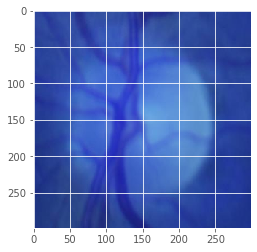

In [ ]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
plt.imshow(trainx[0], interpolation='nearest')
plt.show()

#img = Image.fromarray(trainx[0], 'RGB')
#img.save('my.png')
#img.show()

In [ ]:
model_obj = HIGH_LEVEL_MODEL('NasNetLarge')

343621632/343610240 [==============================] - 12s 0us/step


# Explore Base Learner

In [ ]:
MODEL_LIST = ['vgg16','vgg19','DenseNet121','MobileNet','InceptionV3','InceptionResNetV2','xception']

RIM-ONE v2

In [ ]:
(trainx1,trainy1),(testx1,testy1) = get_rim_one_db_r2(width = 299,height = 299,test_train_ratio = 0.2)

Height:299 Width:299


A_False_Split_0.2_lr_0.0001
 Training:RIM-ONE_v2_A_False_0.2_0.0001_vgg16,Aug:False

Epoch 1: val_loss improved from inf to 0.67939, saving model to vgg16_a.hdf5

Epoch 2: val_loss did not improve from 0.67939

Epoch 3: val_loss improved from 0.67939 to 0.66210, saving model to vgg16_a.hdf5

Epoch 4: val_loss improved from 0.66210 to 0.64105, saving model to vgg16_a.hdf5

Epoch 5: val_loss improved from 0.64105 to 0.62860, saving model to vgg16_a.hdf5

Epoch 6: val_loss did not improve from 0.62860

Epoch 7: val_loss improved from 0.62860 to 0.62536, saving model to vgg16_a.hdf5

Epoch 8: val_loss did not improve from 0.62536

Epoch 9: val_loss improved from 0.62536 to 0.59089, saving model to vgg16_a.hdf5

Epoch 10: val_loss improved from 0.59089 to 0.58190, saving model to vgg16_a.hdf5

Epoch 11: val_loss improved from 0.58190 to 0.57604, saving model to vgg16_a.hdf5

Epoch 12: val_loss did not improve from 0.57604

Epoch 13: val_loss did not improve from 0.57604

Epoch 14: val_loss 

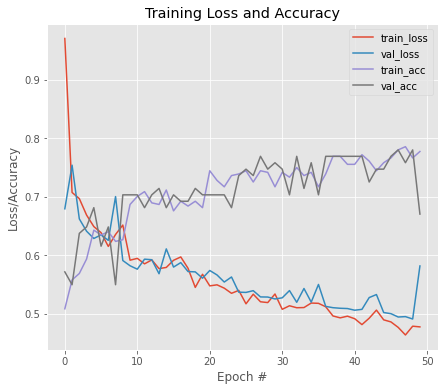


Model Performance Summary:

Best Validation accuracy:0.7802197933197021 at EPOCH:47
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.4706 - accuracy: 0.7775
Epoch 1: val_loss improved from inf to 0.49099, saving model to vgg16_wt.hdf5
12/12 [==============================] - 2s 150ms/step - loss: 0.4706 - accuracy: 0.7775 - val_loss: 0.4910 - val_accuracy: 0.7582
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.4497 - accuracy: 0.7967
Epoch 2: val_loss improved from 0.49099 to 0.47221, saving model to vgg16_wt.hdf5
12/12 [==============================] - 2s 126ms/step - loss: 0.4497 - accuracy: 0.7967 - val_loss: 0.4722 - val_accuracy: 0.7912
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.4449 - accuracy: 0.7912
Epoch 3: val_loss improved from 0.47221 to 0.46963, saving model to vgg16_wt.hdf5
12/12 [==============================] - 2s 128ms/step - loss: 0.4449 - accuracy: 0.7912 - val_loss: 0.4696 - val_accuracy: 0.769

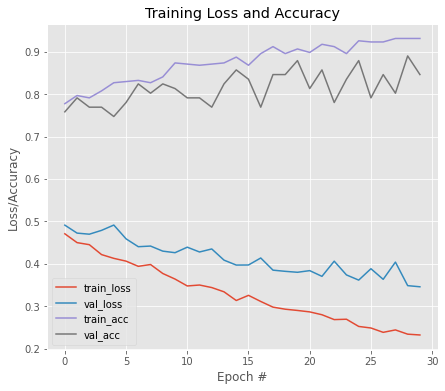


Model Performance Summary:

Best Validation accuracy:0.8901098966598511 at EPOCH:29
3/3 [==============================] - 0s 77ms/step
Accuracy: 0.8461538461538461
Sensitivity: 0.8048780487804879


Model  Accuracy  Precision    Recall     F1  \
0  RIM-ONE_v2_A_False_0.2_0.0001_vgg16  0.846154   0.846154  0.804878  0.825   

        AUC  Sensitivity  Specificity     Kappa  
0  0.842439     0.804878         0.88  0.687898

A_False_Split_0.2_lr_0.0001
80150528/80134624 [==============================] - 2s 0us/step
 Training:RIM-ONE_v2_A_False_0.2_0.0001_vgg19,Aug:False

Epoch 1: val_loss improved from inf to 0.69572, saving model to vgg19_a.hdf5

Epoch 2: val_loss improved from 0.69572 to 0.66247, saving model to vgg19_a.hdf5

Epoch 3: val_loss improved from 0.66247 to 0.63816, saving model to vgg19_a.hdf5

Epoch 4: val_loss did not improve from 0.63816

Epoch 5: val_loss improved from 0.63816 to 0.62867, saving model to vgg19_a.hdf5

Epoch 6: val_loss improved from 0.62867 to 0.60069, saving model to vgg19_a.hdf5

Epoch 7: val_loss did not improve from 0.60069

Epoch 8: val_loss improved from 0.60069 to 0.58223, saving model to vgg19_a.hdf5

Epoch 9: val_loss improved from 0.58223 to 0.57647, saving model to vgg19_a.hdf5

Epoch 10: val_loss improved from 0.57647 to 0.57063, saving model to vgg19_a.hdf5

Epoch 11: val_loss did not improve from 0.57063

Epoch 12: val_loss improved from 0.57063 to 0.56552,

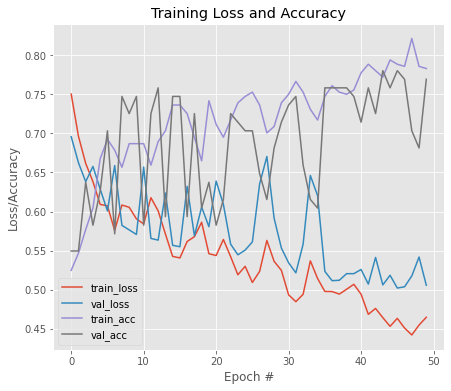


Model Performance Summary:

Best Validation accuracy:0.7802197933197021 at EPOCH:44
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.4765 - accuracy: 0.7500
Epoch 1: val_loss improved from inf to 0.52100, saving model to vgg19_wt.hdf5
12/12 [==============================] - 3s 164ms/step - loss: 0.4765 - accuracy: 0.7500 - val_loss: 0.5210 - val_accuracy: 0.7582
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.4306 - accuracy: 0.8077
Epoch 2: val_loss improved from 0.52100 to 0.48897, saving model to vgg19_wt.hdf5
12/12 [==============================] - 2s 149ms/step - loss: 0.4306 - accuracy: 0.8077 - val_loss: 0.4890 - val_accuracy: 0.7582
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.4547 - accuracy: 0.7775
Epoch 3: val_loss improved from 0.48897 to 0.48420, saving model to vgg19_wt.hdf5
12/12 [==============================] - 2s 149ms/step - loss: 0.4547 - accuracy: 0.7775 - val_loss: 0.4842 - val_accuracy: 0.780

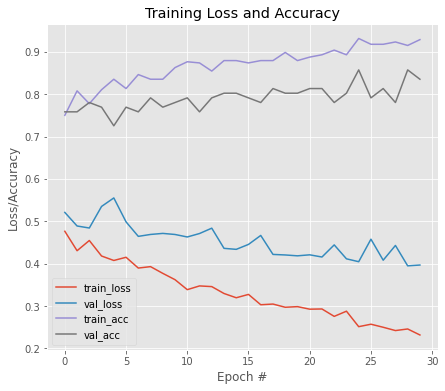


Model Performance Summary:

Best Validation accuracy:0.8571428656578064 at EPOCH:25
3/3 [==============================] - 0s 90ms/step
Accuracy: 0.8571428571428571
Sensitivity: 0.8292682926829268


Model  Accuracy  Precision    Recall  \
0  RIM-ONE_v2_A_False_0.2_0.0001_vgg19  0.857143       0.85  0.829268   

         F1       AUC  Sensitivity  Specificity     Kappa  
0  0.839506  0.854634     0.829268         0.88  0.710829

A_False_Split_0.2_lr_0.0001
 Training:RIM-ONE_v2_A_False_0.2_0.0001_DenseNet121,Aug:False

Epoch 1: val_loss improved from inf to 0.47092, saving model to DenseNet121_a.hdf5

Epoch 2: val_loss improved from 0.47092 to 0.42557, saving model to DenseNet121_a.hdf5

Epoch 3: val_loss did not improve from 0.42557

Epoch 4: val_loss improved from 0.42557 to 0.39583, saving model to DenseNet121_a.hdf5

Epoch 5: val_loss improved from 0.39583 to 0.34911, saving model to DenseNet121_a.hdf5

Epoch 6: val_loss improved from 0.34911 to 0.32362, saving model to DenseNet121_a.hdf5

Epoch 7: val_loss improved from 0.32362 to 0.32355, saving model to DenseNet121_a.hdf5

Epoch 8: val_loss improved from 0.32355 to 0.30579, saving model to DenseNet121_a.hdf5

Epoch 9: val_loss did not improve from 0.30579

Epoch 10: val_loss did not improve from 0.30579

Epoch 11: val_loss did not improve from 0.30579

Epoch 12: val_loss did not improve from 0.30579

Epoch 13: val_loss improved from 0.30579 to 0.29565, s

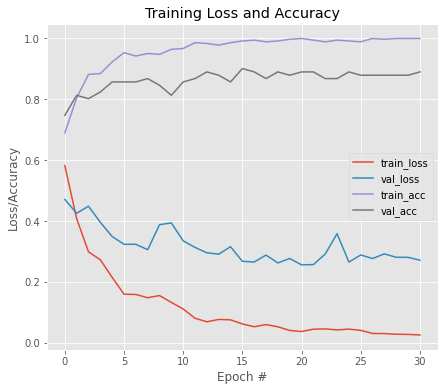


Model Performance Summary:

Best Validation accuracy:0.901098906993866 at EPOCH:16
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.1175 - accuracy: 0.9451
Epoch 1: val_loss improved from inf to 0.35838, saving model to DenseNet121_wt.hdf5
12/12 [==============================] - 8s 287ms/step - loss: 0.1175 - accuracy: 0.9451 - val_loss: 0.3584 - val_accuracy: 0.8571
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.0489 - accuracy: 0.9890
Epoch 2: val_loss improved from 0.35838 to 0.27675, saving model to DenseNet121_wt.hdf5
12/12 [==============================] - 2s 140ms/step - loss: 0.0489 - accuracy: 0.9890 - val_loss: 0.2768 - val_accuracy: 0.8791
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.0370 - accuracy: 0.9890
Epoch 3: val_loss improved from 0.27675 to 0.27619, saving model to DenseNet121_wt.hdf5
12/12 [==============================] - 2s 144ms/step - loss: 0.0370 - accuracy: 0.9890 - val_loss: 0.2762 - va

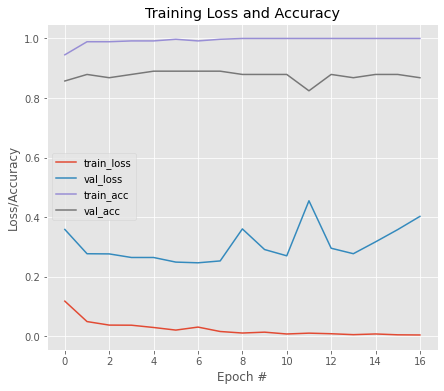


Model Performance Summary:

Best Validation accuracy:0.8901098966598511 at EPOCH:5
3/3 [==============================] - 2s 57ms/step
Accuracy: 0.8901098901098901
Sensitivity: 0.8292682926829268


Model  Accuracy  Precision    Recall  \
0  RIM-ONE_v2_A_False_0.2_0.0001_DenseNet121   0.89011   0.918919  0.829268   

         F1       AUC  Sensitivity  Specificity     Kappa  
0  0.871795  0.884634     0.829268         0.94  0.776083

A_False_Split_0.2_lr_0.0001
 Training:RIM-ONE_v2_A_False_0.2_0.0001_MobileNet,Aug:False

Epoch 1: val_loss improved from inf to 0.57223, saving model to MobileNet_a.hdf5

Epoch 2: val_loss improved from 0.57223 to 0.39918, saving model to MobileNet_a.hdf5

Epoch 3: val_loss did not improve from 0.39918

Epoch 4: val_loss improved from 0.39918 to 0.34057, saving model to MobileNet_a.hdf5

Epoch 5: val_loss improved from 0.34057 to 0.33844, saving model to MobileNet_a.hdf5

Epoch 6: val_loss did not improve from 0.33844

Epoch 7: val_loss did not improve from 0.33844

Epoch 8: val_loss did not improve from 0.33844

Epoch 9: val_loss did not improve from 0.33844

Epoch 10: val_loss did not improve from 0.33844

Epoch 11: val_loss did not improve from 0.33844

Epoch 12: val_loss did not improve from 0.33844

Epoch 13: val_loss did not improve from 0.33844

Epoch 14: val_loss did not improve from 0.33844

Epoch 15: val_loss did not improve from 0.33844


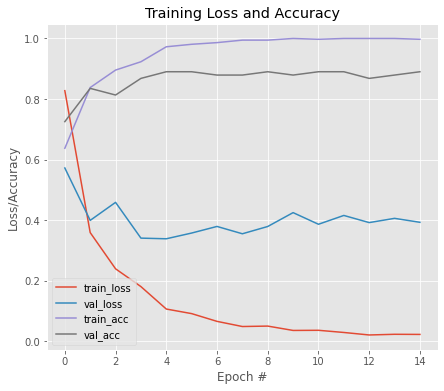


Model Performance Summary:

Best Validation accuracy:0.8901098966598511 at EPOCH:5
Epoch 1/30
11/12 [==========================>...] - ETA: 0s - loss: 0.3255 - accuracy: 0.8705
Epoch 1: val_loss improved from inf to 0.46585, saving model to MobileNet_wt.hdf5
12/12 [==============================] - 3s 108ms/step - loss: 0.3094 - accuracy: 0.8791 - val_loss: 0.4659 - val_accuracy: 0.8462
Epoch 2/30
11/12 [==========================>...] - ETA: 0s - loss: 0.1148 - accuracy: 0.9608
Epoch 2: val_loss did not improve from 0.46585
12/12 [==============================] - 1s 47ms/step - loss: 0.1137 - accuracy: 0.9588 - val_loss: 0.4899 - val_accuracy: 0.8352
Epoch 3/30
11/12 [==========================>...] - ETA: 0s - loss: 0.0685 - accuracy: 0.9699
Epoch 3: val_loss improved from 0.46585 to 0.36597, saving model to MobileNet_wt.hdf5
12/12 [==============================] - 1s 69ms/step - loss: 0.0770 - accuracy: 0.9615 - val_loss: 0.3660 - val_accuracy: 0.8791
Epoch 4/30
11/12 [==========

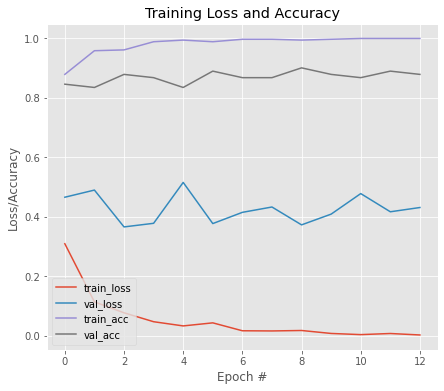


Model Performance Summary:

Best Validation accuracy:0.901098906993866 at EPOCH:9
3/3 [==============================] - 0s 26ms/step
Accuracy: 0.8791208791208791
Sensitivity: 0.8048780487804879


Model  Accuracy  Precision    Recall  \
0  RIM-ONE_v2_A_False_0.2_0.0001_MobileNet  0.879121   0.916667  0.804878   

         F1       AUC  Sensitivity  Specificity     Kappa  
0  0.857143  0.872439     0.804878         0.94  0.753144

A_False_Split_0.2_lr_0.0001
 Training:RIM-ONE_v2_A_False_0.2_0.0001_InceptionV3,Aug:False

Epoch 1: val_loss improved from inf to 0.56731, saving model to InceptionV3_a.hdf5

Epoch 2: val_loss improved from 0.56731 to 0.44546, saving model to InceptionV3_a.hdf5

Epoch 3: val_loss improved from 0.44546 to 0.38935, saving model to InceptionV3_a.hdf5

Epoch 4: val_loss did not improve from 0.38935

Epoch 5: val_loss did not improve from 0.38935

Epoch 6: val_loss improved from 0.38935 to 0.38124, saving model to InceptionV3_a.hdf5

Epoch 7: val_loss did not improve from 0.38124

Epoch 8: val_loss improved from 0.38124 to 0.37241, saving model to InceptionV3_a.hdf5

Epoch 9: val_loss did not improve from 0.37241

Epoch 10: val_loss did not improve from 0.37241

Epoch 11: val_loss improved from 0.37241 to 0.37115, saving model to InceptionV3_a.hdf5

Epoch 12: val_loss did not improve from 0.37115

Epoch 13: val_loss did not improve from 0.37115

Epoch 14: val_loss did not improve from 0.371

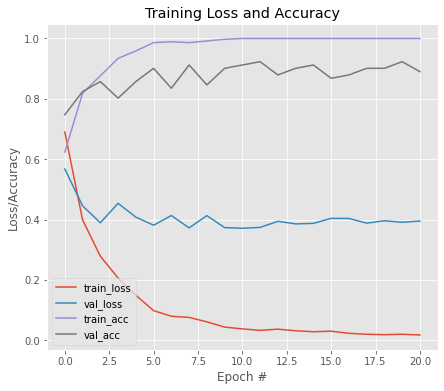


Model Performance Summary:

Best Validation accuracy:0.9230769276618958 at EPOCH:12
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.2853 - accuracy: 0.9396
Epoch 1: val_loss improved from inf to 0.37277, saving model to InceptionV3_wt.hdf5
12/12 [==============================] - 7s 335ms/step - loss: 0.2853 - accuracy: 0.9396 - val_loss: 0.3728 - val_accuracy: 0.8901
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.0274 - accuracy: 1.0000
Epoch 2: val_loss did not improve from 0.37277
12/12 [==============================] - 1s 101ms/step - loss: 0.0274 - accuracy: 1.0000 - val_loss: 0.3806 - val_accuracy: 0.8901
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 0.37277
12/12 [==============================] - 1s 101ms/step - loss: 0.0249 - accuracy: 1.0000 - val_loss: 0.4625 - val_accuracy: 0.8352
Epoch 4/30
12/12 [==============================] - ETA: 0s - 

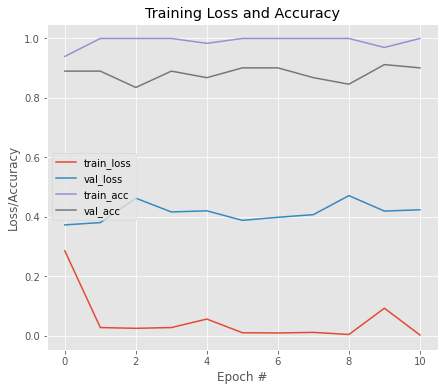


Model Performance Summary:

Best Validation accuracy:0.9120879173278809 at EPOCH:10
3/3 [==============================] - 1s 70ms/step
Accuracy: 0.8901098901098901
Sensitivity: 0.8536585365853658


Model  Accuracy  Precision    Recall  \
0  RIM-ONE_v2_A_False_0.2_0.0001_InceptionV3   0.89011   0.897436  0.853659   

      F1       AUC  Sensitivity  Specificity    Kappa  
0  0.875  0.886829     0.853659         0.92  0.77707

A_False_Split_0.2_lr_0.0001
219070464/219055592 [==============================] - 3s 0us/step
 Training:RIM-ONE_v2_A_False_0.2_0.0001_InceptionResNetV2,Aug:False

Epoch 1: val_loss improved from inf to 0.76411, saving model to InceptionResNetV2_a.hdf5

Epoch 2: val_loss improved from 0.76411 to 0.56862, saving model to InceptionResNetV2_a.hdf5

Epoch 3: val_loss improved from 0.56862 to 0.56771, saving model to InceptionResNetV2_a.hdf5

Epoch 4: val_loss improved from 0.56771 to 0.52974, saving model to InceptionResNetV2_a.hdf5

Epoch 5: val_loss improved from 0.52974 to 0.52115, saving model to InceptionResNetV2_a.hdf5

Epoch 6: val_loss improved from 0.52115 to 0.51887, saving model to InceptionResNetV2_a.hdf5

Epoch 7: val_loss did not improve from 0.51887

Epoch 8: val_loss improved from 0.51887 to 0.51350, saving model to InceptionResNetV2_a.hdf5

Epoch 9: val_loss did not improve from 0.51350

Epoch 10: val_loss improved from 0.51350 to 0.50783, saving model to InceptionResNetV2

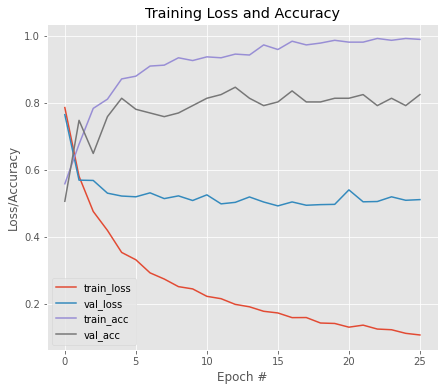


Model Performance Summary:

Best Validation accuracy:0.8461538553237915 at EPOCH:13
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.2843 - accuracy: 0.8984
Epoch 1: val_loss improved from inf to 0.49730, saving model to InceptionResNetV2_wt.hdf5
12/12 [==============================] - 16s 576ms/step - loss: 0.2843 - accuracy: 0.8984 - val_loss: 0.4973 - val_accuracy: 0.7912
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.1699 - accuracy: 0.9505
Epoch 2: val_loss did not improve from 0.49730
12/12 [==============================] - 3s 227ms/step - loss: 0.1699 - accuracy: 0.9505 - val_loss: 0.5020 - val_accuracy: 0.7912
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.1277 - accuracy: 0.9725
Epoch 3: val_loss improved from 0.49730 to 0.49072, saving model to InceptionResNetV2_wt.hdf5
12/12 [==============================] - 4s 341ms/step - loss: 0.1277 - accuracy: 0.9725 - val_loss: 0.4907 - val_accuracy: 0.7912
Epoch 4/

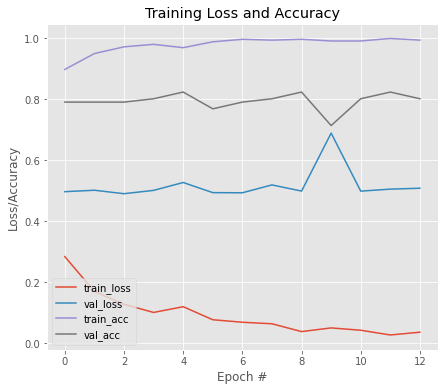


Model Performance Summary:

Best Validation accuracy:0.8241758346557617 at EPOCH:5
3/3 [==============================] - 3s 173ms/step
Accuracy: 0.7912087912087912
Sensitivity: 0.7317073170731707


Model  Accuracy  Precision  \
0  RIM-ONE_v2_A_False_0.2_0.0001_InceptionResNetV2  0.791209   0.789474   

     Recall        F1       AUC  Sensitivity  Specificity     Kappa  
0  0.731707  0.759494  0.785854     0.731707         0.84  0.575497

A_False_Split_0.2_lr_0.0001
 Training:RIM-ONE_v2_A_False_0.2_0.0001_xception,Aug:False

Epoch 1: val_loss improved from inf to 0.55125, saving model to xception_a.hdf5

Epoch 2: val_loss improved from 0.55125 to 0.53316, saving model to xception_a.hdf5

Epoch 3: val_loss improved from 0.53316 to 0.49879, saving model to xception_a.hdf5

Epoch 4: val_loss improved from 0.49879 to 0.49236, saving model to xception_a.hdf5

Epoch 5: val_loss improved from 0.49236 to 0.44392, saving model to xception_a.hdf5

Epoch 6: val_loss improved from 0.44392 to 0.41247, saving model to xception_a.hdf5

Epoch 7: val_loss did not improve from 0.41247

Epoch 8: val_loss did not improve from 0.41247

Epoch 9: val_loss did not improve from 0.41247

Epoch 10: val_loss did not improve from 0.41247

Epoch 11: val_loss did not improve from 0.41247

Epoch 12: val_loss improved from 0.41247 to 0.41125, saving model to xception_a.hdf5

Epoch 13: val_loss improved from 0.41125 to 0.40601, saving model to xception_

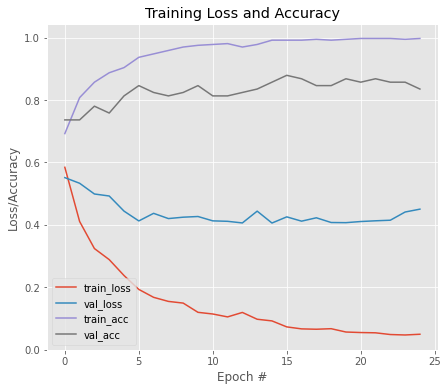


Model Performance Summary:

Best Validation accuracy:0.8791208863258362 at EPOCH:16
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.1475 - accuracy: 0.9368
Epoch 1: val_loss improved from inf to 0.68360, saving model to xception_wt.hdf5
12/12 [==============================] - 6s 305ms/step - loss: 0.1475 - accuracy: 0.9368 - val_loss: 0.6836 - val_accuracy: 0.7143
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.0981 - accuracy: 0.9643
Epoch 2: val_loss improved from 0.68360 to 0.50215, saving model to xception_wt.hdf5
12/12 [==============================] - 3s 233ms/step - loss: 0.0981 - accuracy: 0.9643 - val_loss: 0.5022 - val_accuracy: 0.7802
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.0437 - accuracy: 0.9918
Epoch 3: val_loss did not improve from 0.50215
12/12 [==============================] - 2s 176ms/step - loss: 0.0437 - accuracy: 0.9918 - val_loss: 0.7051 - val_accuracy: 0.7143
Epoch 4/30
12/12 [=========

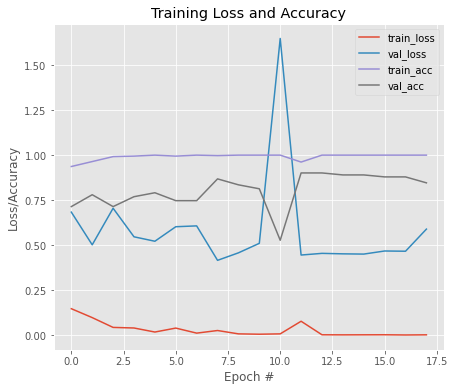


Model Performance Summary:

Best Validation accuracy:0.901098906993866 at EPOCH:12
3/3 [==============================] - 1s 130ms/step
Accuracy: 0.8681318681318682
Sensitivity: 0.8292682926829268


Model  Accuracy  Precision    Recall  \
0  RIM-ONE_v2_A_False_0.2_0.0001_xception  0.868132   0.871795  0.829268   

     F1       AUC  Sensitivity  Specificity     Kappa  
0  0.85  0.864634     0.829268          0.9  0.732484

In [ ]:
set_seed()
for model in MODEL_LIST:
  set_seed()
  print(f"A_{False}_Split_{0.2}_lr_{0.0001}")
  model_obj = HIGH_LEVEL_MODEL(model)
  name = f"RIM-ONE_v2_A_{False}_{0.2}_{0.0001}_{model}"
  model_obj.train_phase(trainx1,trainy1,testx1,testy1,data_aug=False,model_name = name)

Model  Accuracy  Precision  \
0               RIM-ONE_v2_A_False_0.2_0.0001_vgg16  0.846154   0.846154   
1               RIM-ONE_v2_A_False_0.2_0.0001_vgg19  0.857143   0.850000   
2            RIM-ONE_v2_A_False_0.2_0.0001_resnet50  0.450549   0.450549   
3         RIM-ONE_v2_A_False_0.2_0.0001_DenseNet121  0.890110   0.918919   
4           RIM-ONE_v2_A_False_0.2_0.0001_MobileNet  0.879121   0.916667   
5         RIM-ONE_v2_A_False_0.2_0.0001_InceptionV3  0.890110   0.897436   
6   RIM-ONE_v2_A_False_0.2_0.0001_InceptionResNetV2  0.791209   0.789474   
7            RIM-ONE_v2_A_False_0.2_0.0001_xception  0.868132   0.871795   
8                                          vgg16_BL  0.868132   0.853659   
9                                    DenseNet121_BL  0.912088   0.902439   
10                                         vgg19_BL  0.835165   0.825000   
11                                      xception_BL  0.901099   0.880952   
12                                     MobileNet_BL  0.934066   0.972973   
13                                   InceptionV3_BL  0.879121   0.857143   

      Recall        F1       AUC  Sensitivity  Specificity     kappa  
0   0.804878  0.825000  0.842439     0.804878         0.88  0.687898  
1   0.829268  0.839506  0.854634     0.829268         0.88  0.710829  
2   1.000000  0.621212  0.500000     1.000000         0.00  0.000000  
3   0.829268  0.871795  0.884634     0.829268         0.94  0.776083  
4   0.804878  0.857143  0.872439     0.804878         0.94  0.753144  
5   0.853659  0.875000  0.886829     0.853659         0.92  0.777070  
6   0.731707  0.759494  0.785854     0.731707         0.84  0.575497  
7   0.829268  0.850000  0.864634     0.829268         0.90  0.732484  
8   0.853659  0.853659  0.866829     0.853659         0.88  0.733659  
9   0.902439  0.902439  0.911220     0.902439         0.92  0.822439  
10  0.804878  0.814815  0.832439     0.804878         0.86  0.666341  
11  0.902439  0.891566  0.901220     0.902439         0.90  0.800681  
12  0.878049  0.923077  0.929024     0.878049         0.98  0.865650  
13  0.878049  0.867470  0.879024     0.878049         0.88  0.756388

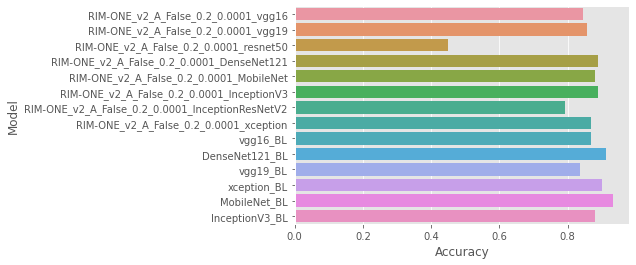

\begin{tabular}{lrrrrrrrr}
\toprule
                                          Model &  Accuracy &  Precision &   Recall &       F1 &      AUC &  Sensitivity &  Specificity &    kappa \\
\midrule
            RIM-ONE\_v2\_A\_False\_0.2\_0.0001\_vgg16 &  0.846154 &   0.846154 & 0.804878 & 0.825000 & 0.842439 &     0.804878 &         0.88 & 0.687898 \\
            RIM-ONE\_v2\_A\_False\_0.2\_0.0001\_vgg19 &  0.857143 &   0.850000 & 0.829268 & 0.839506 & 0.854634 &     0.829268 &         0.88 & 0.710829 \\
         RIM-ONE\_v2\_A\_False\_0.2\_0.0001\_resnet50 &  0.450549 &   0.450549 & 1.000000 & 0.621212 & 0.500000 &     1.000000 &         0.00 & 0.000000 \\
      RIM-ONE\_v2\_A\_False\_0.2\_0.0001\_DenseNet121 &  0.890110 &   0.918919 & 0.829268 & 0.871795 & 0.884634 &     0.829268 &         0.94 & 0.776083 \\
        RIM-ONE\_v2\_A\_False\_0.2\_0.0001\_MobileNet &  0.879121 &   0.916667 & 0.804878 & 0.857143 & 0.872439 &     0.804878 &         0.94 & 0.753144 \\
      RIM-ONE\_v2\_A\_Fal

In [ ]:
plot_performance()

ACRIMA 

In [ ]:
(trainx2,trainy2),(testx2,testy2) = get_acrima_dataset(width = 299,height = 299,test_train_ratio = 0.2)

Height:299 Width:299


A_False_Split_0.2_lr_0.0001
 Training:ACRIMA_A_False_0.2_0.0001_vgg16,Aug:False

Epoch 1: val_loss improved from inf to 0.69623, saving model to vgg16_a.hdf5

Epoch 2: val_loss improved from 0.69623 to 0.65264, saving model to vgg16_a.hdf5

Epoch 3: val_loss improved from 0.65264 to 0.63850, saving model to vgg16_a.hdf5

Epoch 4: val_loss improved from 0.63850 to 0.63096, saving model to vgg16_a.hdf5

Epoch 5: val_loss improved from 0.63096 to 0.60911, saving model to vgg16_a.hdf5

Epoch 6: val_loss improved from 0.60911 to 0.60268, saving model to vgg16_a.hdf5

Epoch 7: val_loss improved from 0.60268 to 0.57692, saving model to vgg16_a.hdf5

Epoch 8: val_loss improved from 0.57692 to 0.55965, saving model to vgg16_a.hdf5

Epoch 9: val_loss improved from 0.55965 to 0.55947, saving model to vgg16_a.hdf5

Epoch 10: val_loss improved from 0.55947 to 0.55183, saving model to vgg16_a.hdf5

Epoch 11: val_loss improved from 0.55183 to 0.52746, saving model to vgg16_a.hdf5

Epoch 12: val_loss 

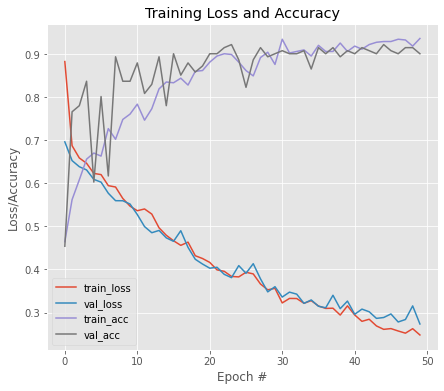


Model Performance Summary:

Best Validation accuracy:0.9219858050346375 at EPOCH:24
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.2487 - accuracy: 0.9220
Epoch 1: val_loss improved from inf to 0.26021, saving model to vgg16_wt.hdf5
18/18 [==============================] - 3s 138ms/step - loss: 0.2487 - accuracy: 0.9220 - val_loss: 0.2602 - val_accuracy: 0.9007
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.2307 - accuracy: 0.9326
Epoch 2: val_loss did not improve from 0.26021
18/18 [==============================] - 2s 112ms/step - loss: 0.2307 - accuracy: 0.9326 - val_loss: 0.2642 - val_accuracy: 0.9149
Epoch 3/30
18/18 [==============================] - ETA: 0s - loss: 0.2053 - accuracy: 0.9504
Epoch 3: val_loss improved from 0.26021 to 0.25712, saving model to vgg16_wt.hdf5
18/18 [==============================] - 2s 124ms/step - loss: 0.2053 - accuracy: 0.9504 - val_loss: 0.2571 - val_accuracy: 0.9220
Epoch 4/30
18/18 [===============

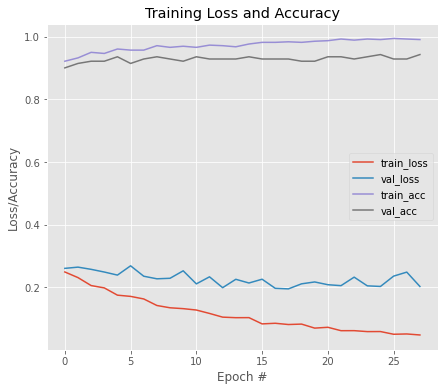


Model Performance Summary:

Best Validation accuracy:0.9432623982429504 at EPOCH:25
5/5 [==============================] - 0s 78ms/step
Accuracy: 0.9290780141843972
Sensitivity: 0.9310344827586207


Model  Accuracy  Precision    Recall        F1  \
0  ACRIMA_A_False_0.2_0.0001_vgg16  0.929078        0.9  0.931034  0.915254   

        AUC  Sensitivity  Specificity     Kappa  
0  0.929373     0.931034     0.927711  0.854309

A_False_Split_0.2_lr_0.0001
 Training:ACRIMA_A_False_0.2_0.0001_vgg19,Aug:False

Epoch 1: val_loss improved from inf to 0.67901, saving model to vgg19_a.hdf5

Epoch 2: val_loss improved from 0.67901 to 0.65225, saving model to vgg19_a.hdf5

Epoch 3: val_loss did not improve from 0.65225

Epoch 4: val_loss improved from 0.65225 to 0.60574, saving model to vgg19_a.hdf5

Epoch 5: val_loss improved from 0.60574 to 0.57943, saving model to vgg19_a.hdf5

Epoch 6: val_loss did not improve from 0.57943

Epoch 7: val_loss did not improve from 0.57943

Epoch 8: val_loss did not improve from 0.57943

Epoch 9: val_loss improved from 0.57943 to 0.53997, saving model to vgg19_a.hdf5

Epoch 10: val_loss did not improve from 0.53997

Epoch 11: val_loss improved from 0.53997 to 0.50434, saving model to vgg19_a.hdf5

Epoch 12: val_loss improved from 0.50434 to 0.48766, saving model to vgg19_a.hdf5

Epoch 13: val_loss did not improve from 0.48766

Epoch 14: val_loss improved from 0.48766 to 0.46855, savi

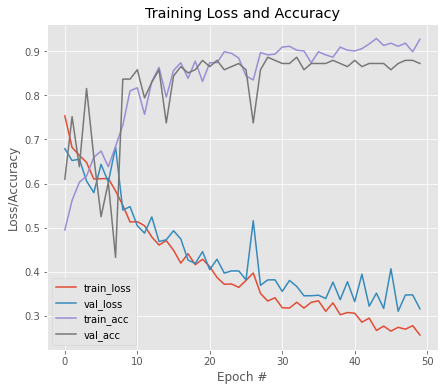


Model Performance Summary:

Best Validation accuracy:0.8865247964859009 at EPOCH:29
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.2701 - accuracy: 0.9167
Epoch 1: val_loss improved from inf to 0.30530, saving model to vgg19_wt.hdf5
18/18 [==============================] - 4s 157ms/step - loss: 0.2701 - accuracy: 0.9167 - val_loss: 0.3053 - val_accuracy: 0.8794
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.2523 - accuracy: 0.9149
Epoch 2: val_loss did not improve from 0.30530
18/18 [==============================] - 2s 127ms/step - loss: 0.2523 - accuracy: 0.9149 - val_loss: 0.3492 - val_accuracy: 0.8723
Epoch 3/30
18/18 [==============================] - ETA: 0s - loss: 0.2244 - accuracy: 0.9504
Epoch 3: val_loss improved from 0.30530 to 0.28370, saving model to vgg19_wt.hdf5
18/18 [==============================] - 3s 142ms/step - loss: 0.2244 - accuracy: 0.9504 - val_loss: 0.2837 - val_accuracy: 0.8723
Epoch 4/30
18/18 [===============

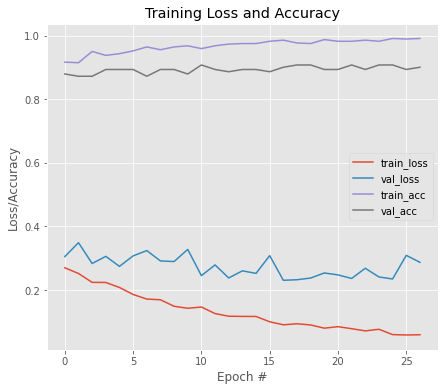


Model Performance Summary:

Best Validation accuracy:0.9078013896942139 at EPOCH:11
5/5 [==============================] - 1s 90ms/step
Accuracy: 0.900709219858156
Sensitivity: 0.896551724137931


Model  Accuracy  Precision    Recall        F1  \
0  ACRIMA_A_False_0.2_0.0001_vgg19  0.900709   0.866667  0.896552  0.881356   

        AUC  Sensitivity  Specificity     Kappa  
0  0.900083     0.896552     0.903614  0.796032

A_False_Split_0.2_lr_0.0001
 Training:ACRIMA_A_False_0.2_0.0001_DenseNet121,Aug:False

Epoch 1: val_loss improved from inf to 0.39905, saving model to DenseNet121_a.hdf5

Epoch 2: val_loss improved from 0.39905 to 0.34622, saving model to DenseNet121_a.hdf5

Epoch 3: val_loss improved from 0.34622 to 0.29985, saving model to DenseNet121_a.hdf5

Epoch 4: val_loss did not improve from 0.29985

Epoch 5: val_loss improved from 0.29985 to 0.24079, saving model to DenseNet121_a.hdf5

Epoch 6: val_loss did not improve from 0.24079

Epoch 7: val_loss did not improve from 0.24079

Epoch 8: val_loss did not improve from 0.24079

Epoch 9: val_loss did not improve from 0.24079

Epoch 10: val_loss did not improve from 0.24079

Epoch 11: val_loss did not improve from 0.24079

Epoch 12: val_loss did not improve from 0.24079

Epoch 13: val_loss did not improve from 0.24079

Epoch 14: val_loss did not improve from 0.24079

Epoch 15: val_loss did not improve from 0.24079


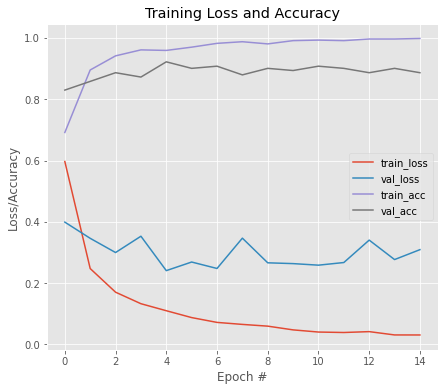


Model Performance Summary:

Best Validation accuracy:0.9219858050346375 at EPOCH:5
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.1454 - accuracy: 0.9521
Epoch 1: val_loss improved from inf to 0.31733, saving model to DenseNet121_wt.hdf5
18/18 [==============================] - 10s 215ms/step - loss: 0.1454 - accuracy: 0.9521 - val_loss: 0.3173 - val_accuracy: 0.8794
Epoch 2/30
17/18 [===========================>..] - ETA: 0s - loss: 0.0865 - accuracy: 0.9743
Epoch 2: val_loss did not improve from 0.31733
18/18 [==============================] - 2s 83ms/step - loss: 0.0894 - accuracy: 0.9734 - val_loss: 0.3680 - val_accuracy: 0.8794
Epoch 3/30
18/18 [==============================] - ETA: 0s - loss: 0.0747 - accuracy: 0.9787
Epoch 3: val_loss did not improve from 0.31733
18/18 [==============================] - 2s 87ms/step - loss: 0.0747 - accuracy: 0.9787 - val_loss: 0.5123 - val_accuracy: 0.8227
Epoch 4/30
18/18 [==============================] - ETA: 0s - lo

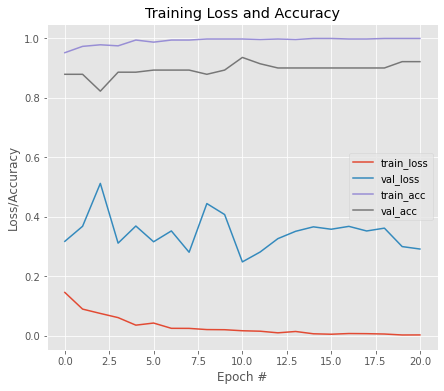


Model Performance Summary:

Best Validation accuracy:0.936170220375061 at EPOCH:11
5/5 [==============================] - 2s 58ms/step
Accuracy: 0.9361702127659575
Sensitivity: 0.9655172413793104


Model  Accuracy  Precision    Recall  \
0  ACRIMA_A_False_0.2_0.0001_DenseNet121   0.93617   0.888889  0.965517   

        F1      AUC  Sensitivity  Specificity     Kappa  
0  0.92562  0.94059     0.965517     0.915663  0.869886

A_False_Split_0.2_lr_0.0001
 Training:ACRIMA_A_False_0.2_0.0001_MobileNet,Aug:False

Epoch 1: val_loss improved from inf to 0.65813, saving model to MobileNet_a.hdf5

Epoch 2: val_loss improved from 0.65813 to 0.53802, saving model to MobileNet_a.hdf5

Epoch 3: val_loss improved from 0.53802 to 0.52592, saving model to MobileNet_a.hdf5

Epoch 4: val_loss improved from 0.52592 to 0.45948, saving model to MobileNet_a.hdf5

Epoch 5: val_loss improved from 0.45948 to 0.38313, saving model to MobileNet_a.hdf5

Epoch 6: val_loss did not improve from 0.38313

Epoch 7: val_loss improved from 0.38313 to 0.35158, saving model to MobileNet_a.hdf5

Epoch 8: val_loss improved from 0.35158 to 0.35004, saving model to MobileNet_a.hdf5

Epoch 9: val_loss did not improve from 0.35004

Epoch 10: val_loss did not improve from 0.35004

Epoch 11: val_loss improved from 0.35004 to 0.34671, saving model to MobileNet_a.hdf5

Epoch 12: val_loss did not improve from 0.34671

Epoch 13: val_loss did not improve f

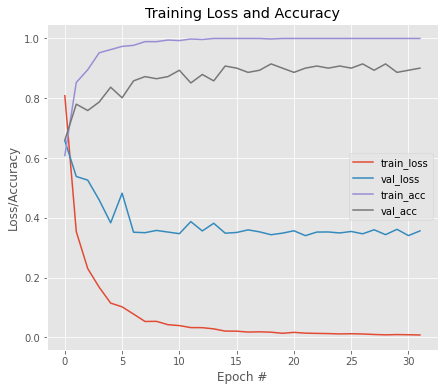


Model Performance Summary:

Best Validation accuracy:0.914893627166748 at EPOCH:19
Epoch 1/30
17/18 [===========================>..] - ETA: 0s - loss: 0.1042 - accuracy: 0.9530
Epoch 1: val_loss improved from inf to 0.37218, saving model to MobileNet_wt.hdf5
18/18 [==============================] - 3s 84ms/step - loss: 0.1001 - accuracy: 0.9557 - val_loss: 0.3722 - val_accuracy: 0.8723
Epoch 2/30
17/18 [===========================>..] - ETA: 0s - loss: 0.0399 - accuracy: 0.9925
Epoch 2: val_loss improved from 0.37218 to 0.34641, saving model to MobileNet_wt.hdf5
18/18 [==============================] - 1s 60ms/step - loss: 0.0485 - accuracy: 0.9840 - val_loss: 0.3464 - val_accuracy: 0.9078
Epoch 3/30
17/18 [===========================>..] - ETA: 0s - loss: 0.0365 - accuracy: 0.9887
Epoch 3: val_loss did not improve from 0.34641
18/18 [==============================] - 1s 45ms/step - loss: 0.0398 - accuracy: 0.9858 - val_loss: 0.3720 - val_accuracy: 0.8652
Epoch 4/30
17/18 [===========

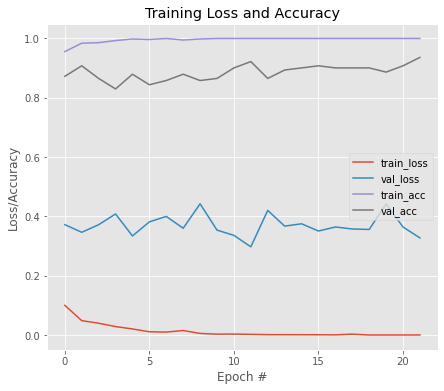


Model Performance Summary:

Best Validation accuracy:0.936170220375061 at EPOCH:22
5/5 [==============================] - 0s 25ms/step
Accuracy: 0.9219858156028369
Sensitivity: 0.9310344827586207


Model  Accuracy  Precision    Recall  \
0  ACRIMA_A_False_0.2_0.0001_MobileNet  0.921986   0.885246  0.931034   

         F1       AUC  Sensitivity  Specificity     Kappa  
0  0.907563  0.923349     0.931034     0.915663  0.840153

A_False_Split_0.2_lr_0.0001
 Training:ACRIMA_A_False_0.2_0.0001_InceptionV3,Aug:False

Epoch 1: val_loss improved from inf to 0.51380, saving model to InceptionV3_a.hdf5

Epoch 2: val_loss improved from 0.51380 to 0.40251, saving model to InceptionV3_a.hdf5

Epoch 3: val_loss improved from 0.40251 to 0.36031, saving model to InceptionV3_a.hdf5

Epoch 4: val_loss improved from 0.36031 to 0.35302, saving model to InceptionV3_a.hdf5

Epoch 5: val_loss improved from 0.35302 to 0.33780, saving model to InceptionV3_a.hdf5

Epoch 6: val_loss did not improve from 0.33780

Epoch 7: val_loss improved from 0.33780 to 0.32485, saving model to InceptionV3_a.hdf5

Epoch 8: val_loss did not improve from 0.32485

Epoch 9: val_loss did not improve from 0.32485

Epoch 10: val_loss improved from 0.32485 to 0.30972, saving model to InceptionV3_a.hdf5

Epoch 11: val_loss did not improve from 0.30972

Epoch 12: val_loss improved from 0.30972 to 0.30607, saving model to InceptionV3_a.hdf5

Epoch 13: val_loss

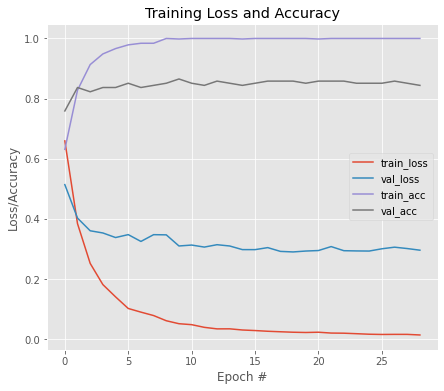


Model Performance Summary:

Best Validation accuracy:0.8652482032775879 at EPOCH:10
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.1709 - accuracy: 0.9610
Epoch 1: val_loss improved from inf to 0.29826, saving model to InceptionV3_wt.hdf5
18/18 [==============================] - 8s 216ms/step - loss: 0.1709 - accuracy: 0.9610 - val_loss: 0.2983 - val_accuracy: 0.8652
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.0250 - accuracy: 1.0000
Epoch 2: val_loss improved from 0.29826 to 0.28260, saving model to InceptionV3_wt.hdf5
18/18 [==============================] - 3s 141ms/step - loss: 0.0250 - accuracy: 1.0000 - val_loss: 0.2826 - val_accuracy: 0.8652
Epoch 3/30
18/18 [==============================] - ETA: 0s - loss: 0.0626 - accuracy: 0.9752
Epoch 3: val_loss did not improve from 0.28260
18/18 [==============================] - 2s 103ms/step - loss: 0.0626 - accuracy: 0.9752 - val_loss: 0.3396 - val_accuracy: 0.8582
Epoch 4/30
18/18 [===

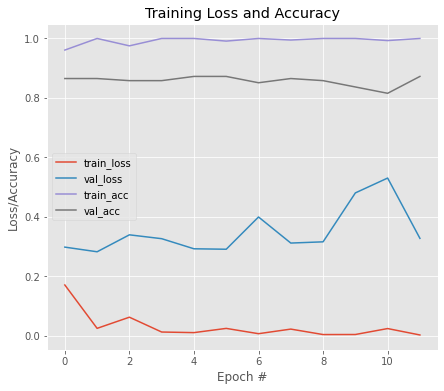


Model Performance Summary:

Best Validation accuracy:0.8723404407501221 at EPOCH:5
5/5 [==============================] - 1s 69ms/step
Accuracy: 0.8652482269503546
Sensitivity: 0.8448275862068966


Model  Accuracy  Precision    Recall  \
0  ACRIMA_A_False_0.2_0.0001_InceptionV3  0.865248   0.830508  0.844828   

         F1       AUC  Sensitivity  Specificity    Kappa  
0  0.837607  0.862173     0.844828     0.879518  0.72247

A_False_Split_0.2_lr_0.0001
 Training:ACRIMA_A_False_0.2_0.0001_InceptionResNetV2,Aug:False

Epoch 1: val_loss improved from inf to 0.62898, saving model to InceptionResNetV2_a.hdf5

Epoch 2: val_loss improved from 0.62898 to 0.57112, saving model to InceptionResNetV2_a.hdf5

Epoch 3: val_loss improved from 0.57112 to 0.57074, saving model to InceptionResNetV2_a.hdf5

Epoch 4: val_loss improved from 0.57074 to 0.51549, saving model to InceptionResNetV2_a.hdf5

Epoch 5: val_loss improved from 0.51549 to 0.48472, saving model to InceptionResNetV2_a.hdf5

Epoch 6: val_loss did not improve from 0.48472

Epoch 7: val_loss improved from 0.48472 to 0.48143, saving model to InceptionResNetV2_a.hdf5

Epoch 8: val_loss did not improve from 0.48143

Epoch 9: val_loss improved from 0.48143 to 0.47560, saving model to InceptionResNetV2_a.hdf5

Epoch 10: val_loss did not improve from 0.47560

Epoch 11: val_loss improved from 0.47560 to 0.47344, saving model to InceptionResNetV2_a.hdf5

Epoch 12: val

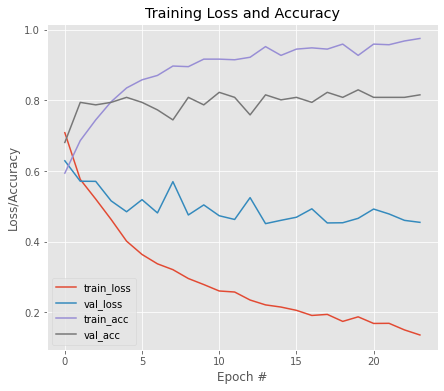


Model Performance Summary:

Best Validation accuracy:0.8297872543334961 at EPOCH:20
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.2648 - accuracy: 0.8901
Epoch 1: val_loss improved from inf to 0.47727, saving model to InceptionResNetV2_wt.hdf5
18/18 [==============================] - 17s 461ms/step - loss: 0.2648 - accuracy: 0.8901 - val_loss: 0.4773 - val_accuracy: 0.8156
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.2240 - accuracy: 0.9149
Epoch 2: val_loss did not improve from 0.47727
18/18 [==============================] - 4s 231ms/step - loss: 0.2240 - accuracy: 0.9149 - val_loss: 0.4975 - val_accuracy: 0.8227
Epoch 3/30
18/18 [==============================] - ETA: 0s - loss: 0.1679 - accuracy: 0.9539
Epoch 3: val_loss did not improve from 0.47727
18/18 [==============================] - 4s 230ms/step - loss: 0.1679 - accuracy: 0.9539 - val_loss: 0.4944 - val_accuracy: 0.8156
Epoch 4/30
18/18 [==============================] - ETA

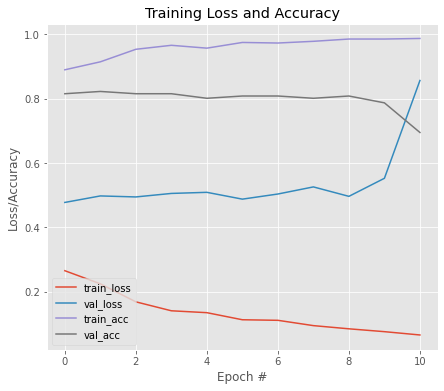


Model Performance Summary:

Best Validation accuracy:0.8226950168609619 at EPOCH:2
5/5 [==============================] - 3s 171ms/step
Accuracy: 0.8156028368794326
Sensitivity: 0.6724137931034483


Model  Accuracy  Precision    Recall  \
0  ACRIMA_A_False_0.2_0.0001_InceptionResNetV2  0.815603   0.847826  0.672414   

     F1       AUC  Sensitivity  Specificity    Kappa  
0  0.75  0.794038     0.672414     0.915663  0.60699

A_False_Split_0.2_lr_0.0001
 Training:ACRIMA_A_False_0.2_0.0001_xception,Aug:False

Epoch 1: val_loss improved from inf to 0.52642, saving model to xception_a.hdf5

Epoch 2: val_loss improved from 0.52642 to 0.43724, saving model to xception_a.hdf5

Epoch 3: val_loss improved from 0.43724 to 0.42215, saving model to xception_a.hdf5

Epoch 4: val_loss improved from 0.42215 to 0.39296, saving model to xception_a.hdf5

Epoch 5: val_loss did not improve from 0.39296

Epoch 6: val_loss improved from 0.39296 to 0.36298, saving model to xception_a.hdf5

Epoch 7: val_loss improved from 0.36298 to 0.34402, saving model to xception_a.hdf5

Epoch 8: val_loss improved from 0.34402 to 0.34024, saving model to xception_a.hdf5

Epoch 9: val_loss did not improve from 0.34024

Epoch 10: val_loss did not improve from 0.34024

Epoch 11: val_loss improved from 0.34024 to 0.33404, saving model to xception_a.hdf5

Epoch 12: val_loss did not improve from 0.33404

Epoch 13: val_loss improved from 0.33404 to 0

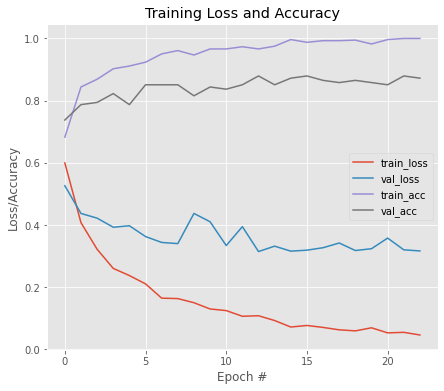


Model Performance Summary:

Best Validation accuracy:0.8794326186180115 at EPOCH:13
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.2165 - accuracy: 0.9362
Epoch 1: val_loss improved from inf to 0.57950, saving model to xception_wt.hdf5
18/18 [==============================] - 7s 262ms/step - loss: 0.2165 - accuracy: 0.9362 - val_loss: 0.5795 - val_accuracy: 0.7518
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.0818 - accuracy: 0.9734
Epoch 2: val_loss did not improve from 0.57950
18/18 [==============================] - 3s 179ms/step - loss: 0.0818 - accuracy: 0.9734 - val_loss: 0.9444 - val_accuracy: 0.6667
Epoch 3/30
18/18 [==============================] - ETA: 0s - loss: 0.0752 - accuracy: 0.9770
Epoch 3: val_loss did not improve from 0.57950
18/18 [==============================] - 3s 178ms/step - loss: 0.0752 - accuracy: 0.9770 - val_loss: 1.1073 - val_accuracy: 0.6525
Epoch 4/30
18/18 [==============================] - ETA: 0s - los

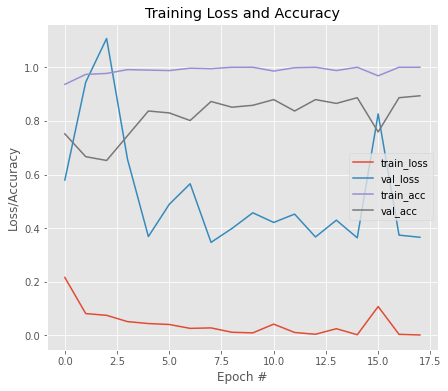


Model Performance Summary:

Best Validation accuracy:0.8936170339584351 at EPOCH:18
5/5 [==============================] - 1s 130ms/step
Accuracy: 0.8723404255319149
Sensitivity: 0.8275862068965517


Model  Accuracy  Precision    Recall  \
0  ACRIMA_A_False_0.2_0.0001_xception   0.87234   0.857143  0.827586   

         F1     AUC  Sensitivity  Specificity     Kappa  
0  0.842105  0.8656     0.827586     0.903614  0.735018

In [ ]:
set_seed()
for model in MODEL_LIST:
  set_seed()
  print(f"A_{False}_Split_{0.2}_lr_{0.0001}")
  model_obj = HIGH_LEVEL_MODEL(model)
  name = f"ACRIMA_A_{False}_{0.2}_{0.0001}_{model}"
  model_obj.train_phase(trainx2,trainy2,testx2,testy2,data_aug=False,model_name = name)

Model  Accuracy  Precision  \
0               RIM-ONE_v2_A_False_0.2_0.0001_vgg16  0.846154   0.846154   
1               RIM-ONE_v2_A_False_0.2_0.0001_vgg19  0.857143   0.850000   
2            RIM-ONE_v2_A_False_0.2_0.0001_resnet50  0.450549   0.450549   
3         RIM-ONE_v2_A_False_0.2_0.0001_DenseNet121  0.890110   0.918919   
4           RIM-ONE_v2_A_False_0.2_0.0001_MobileNet  0.879121   0.916667   
5         RIM-ONE_v2_A_False_0.2_0.0001_InceptionV3  0.890110   0.897436   
6   RIM-ONE_v2_A_False_0.2_0.0001_InceptionResNetV2  0.791209   0.789474   
7            RIM-ONE_v2_A_False_0.2_0.0001_xception  0.868132   0.871795   
8                                          vgg16_BL  0.868132   0.853659   
9                                    DenseNet121_BL  0.912088   0.902439   
10                                         vgg19_BL  0.835165   0.825000   
11                                      xception_BL  0.901099   0.880952   
12                                     MobileNet_BL  0.934066   0.972973   
13                                   InceptionV3_BL  0.879121   0.857143   
14                  ACRIMA_A_False_0.2_0.0001_vgg16  0.929078   0.900000   
15                  ACRIMA_A_False_0.2_0.0001_vgg19  0.900709   0.866667   
16            ACRIMA_A_False_0.2_0.0001_DenseNet121  0.936170   0.888889   
17              ACRIMA_A_False_0.2_0.0001_MobileNet  0.921986   0.885246   
18            ACRIMA_A_False_0.2_0.0001_InceptionV3  0.865248   0.830508   
19      ACRIMA_A_False_0.2_0.0001_InceptionResNetV2  0.815603   0.847826   
20               ACRIMA_A_False_0.2_0.0001_xception  0.872340   0.857143   

      Recall        F1       AUC  Sensitivity  Specificity     kappa  
0   0.804878  0.825000  0.842439     0.804878     0.880000  0.687898  
1   0.829268  0.839506  0.854634     0.829268     0.880000  0.710829  
2   1.000000  0.621212  0.500000     1.000000     0.000000  0.000000  
3   0.829268  0.871795  0.884634     0.829268     0.940000  0.776083  
4   0.804878  0.857143  0.872439     0.804878     0.940000  0.753144  
5   0.853659  0.875000  0.886829     0.853659     0.920000  0.777070  
6   0.731707  0.759494  0.785854     0.731707     0.840000  0.575497  
7   0.829268  0.850000  0.864634     0.829268     0.900000  0.732484  
8   0.853659  0.853659  0.866829     0.853659     0.880000  0.733659  
9   0.902439  0.902439  0.911220     0.902439     0.920000  0.822439  
10  0.804878  0.814815  0.832439     0.804878     0.860000  0.666341  
11  0.902439  0.891566  0.901220     0.902439     0.900000  0.800681  
12  0.878049  0.923077  0.929024     0.878049     0.980000  0.865650  
13  0.878049  0.867470  0.879024     0.878049     0.880000  0.756388  
14  0.931034  0.915254  0.929373     0.931034     0.927711  0.854309  
15  0.896552  0.881356  0.900083     0.896552     0.903614  0.796032  
16  0.965517  0.925620  0.940590     0.965517     0.915663  0.869886  
17  0.931034  0.907563  0.923349     0.931034     0.915663  0.840153  
18  0.844828  0.837607  0.862173     0.844828     0.879518  0.722470  
19  0.672414  0.750000  0.794038     0.672414     0.915663  0.606990  
20  0.827586  0.842105  0.865600     0.827586     0.903614  0.735018

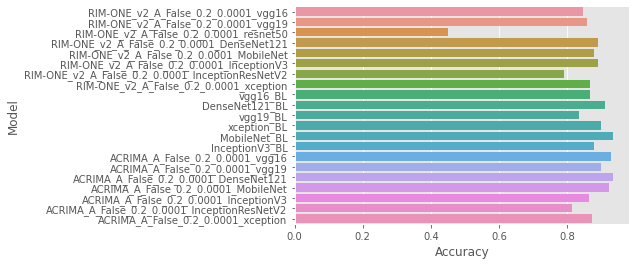

\begin{tabular}{lrrrrrrrr}
\toprule
                                          Model &  Accuracy &  Precision &   Recall &       F1 &      AUC &  Sensitivity &  Specificity &    kappa \\
\midrule
            RIM-ONE\_v2\_A\_False\_0.2\_0.0001\_vgg16 &  0.846154 &   0.846154 & 0.804878 & 0.825000 & 0.842439 &     0.804878 &     0.880000 & 0.687898 \\
            RIM-ONE\_v2\_A\_False\_0.2\_0.0001\_vgg19 &  0.857143 &   0.850000 & 0.829268 & 0.839506 & 0.854634 &     0.829268 &     0.880000 & 0.710829 \\
         RIM-ONE\_v2\_A\_False\_0.2\_0.0001\_resnet50 &  0.450549 &   0.450549 & 1.000000 & 0.621212 & 0.500000 &     1.000000 &     0.000000 & 0.000000 \\
      RIM-ONE\_v2\_A\_False\_0.2\_0.0001\_DenseNet121 &  0.890110 &   0.918919 & 0.829268 & 0.871795 & 0.884634 &     0.829268 &     0.940000 & 0.776083 \\
        RIM-ONE\_v2\_A\_False\_0.2\_0.0001\_MobileNet &  0.879121 &   0.916667 & 0.804878 & 0.857143 & 0.872439 &     0.804878 &     0.940000 & 0.753144 \\
      RIM-ONE\_v2\_A\_Fal

In [ ]:
plot_performance()

RIM-ONE DL

In [ ]:
(trainx3,trainy3),(testx3,testy3) = get_rim_one_dl(width = 299,height = 299)

A_False_Split_0.2_lr_0.0001
 Training:RIM-ONE_dl_A_False_0.2_0.0001_vgg16,Aug:False

Epoch 1: val_loss improved from inf to 0.65386, saving model to vgg16_a.hdf5

Epoch 2: val_loss improved from 0.65386 to 0.64890, saving model to vgg16_a.hdf5

Epoch 3: val_loss improved from 0.64890 to 0.61871, saving model to vgg16_a.hdf5

Epoch 4: val_loss improved from 0.61871 to 0.60442, saving model to vgg16_a.hdf5

Epoch 5: val_loss did not improve from 0.60442

Epoch 6: val_loss improved from 0.60442 to 0.58444, saving model to vgg16_a.hdf5

Epoch 7: val_loss improved from 0.58444 to 0.57727, saving model to vgg16_a.hdf5

Epoch 8: val_loss improved from 0.57727 to 0.57381, saving model to vgg16_a.hdf5

Epoch 9: val_loss improved from 0.57381 to 0.56939, saving model to vgg16_a.hdf5

Epoch 10: val_loss did not improve from 0.56939

Epoch 11: val_loss did not improve from 0.56939

Epoch 12: val_loss improved from 0.56939 to 0.55458, saving model to vgg16_a.hdf5

Epoch 13: val_loss did not improve

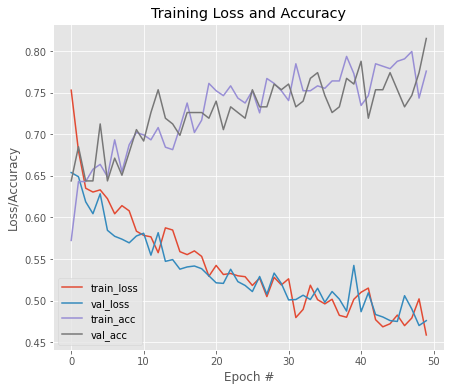


Model Performance Summary:

Best Validation accuracy:0.8150684833526611 at EPOCH:50
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 0.4455 - accuracy: 0.8171
Epoch 1: val_loss improved from inf to 0.46487, saving model to vgg16_wt.hdf5
11/11 [==============================] - 3s 174ms/step - loss: 0.4455 - accuracy: 0.8171 - val_loss: 0.4649 - val_accuracy: 0.7740
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 0.4263 - accuracy: 0.8201
Epoch 2: val_loss improved from 0.46487 to 0.45171, saving model to vgg16_wt.hdf5
11/11 [==============================] - 2s 146ms/step - loss: 0.4263 - accuracy: 0.8201 - val_loss: 0.4517 - val_accuracy: 0.8425
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.4204 - accuracy: 0.8171
Epoch 3: val_loss improved from 0.45171 to 0.44544, saving model to vgg16_wt.hdf5
11/11 [==============================] - 2s 151ms/step - loss: 0.4204 - accuracy: 0.8171 - val_loss: 0.4454 - val_accuracy: 0.828

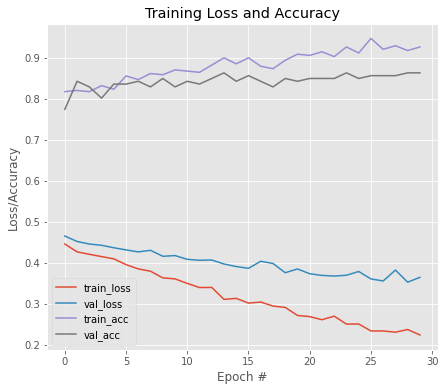


Model Performance Summary:

Best Validation accuracy:0.8630136847496033 at EPOCH:14
5/5 [==============================] - 0s 77ms/step
Accuracy: 0.863013698630137
Sensitivity: 0.9148936170212766


Model  Accuracy  Precision    Recall  \
0  RIM-ONE_dl_A_False_0.2_0.0001_vgg16  0.863014   0.877551  0.914894   

         F1       AUC  Sensitivity  Specificity     Kappa  
0  0.895833  0.842062     0.914894     0.769231  0.696087

A_False_Split_0.2_lr_0.0001
 Training:RIM-ONE_dl_A_False_0.2_0.0001_vgg19,Aug:False

Epoch 1: val_loss improved from inf to 0.66793, saving model to vgg19_a.hdf5

Epoch 2: val_loss did not improve from 0.66793

Epoch 3: val_loss did not improve from 0.66793

Epoch 4: val_loss improved from 0.66793 to 0.63661, saving model to vgg19_a.hdf5

Epoch 5: val_loss improved from 0.63661 to 0.62989, saving model to vgg19_a.hdf5

Epoch 6: val_loss improved from 0.62989 to 0.62052, saving model to vgg19_a.hdf5

Epoch 7: val_loss improved from 0.62052 to 0.61617, saving model to vgg19_a.hdf5

Epoch 8: val_loss improved from 0.61617 to 0.61528, saving model to vgg19_a.hdf5

Epoch 9: val_loss improved from 0.61528 to 0.61081, saving model to vgg19_a.hdf5

Epoch 10: val_loss did not improve from 0.61081

Epoch 11: val_loss did not improve from 0.61081

Epoch 12: val_loss improved from 0.61081 to 0.60265, saving model to vgg19_a.hdf5

Epoch 13: val_loss did not improve from 0.60265

Epoch 14: val_loss 

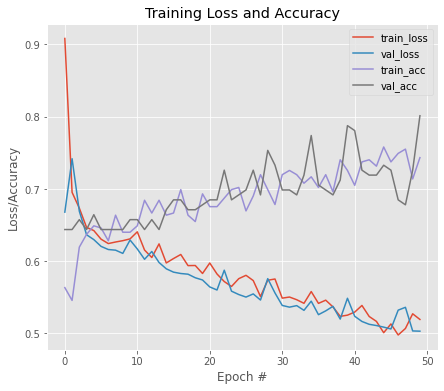


Model Performance Summary:

Best Validation accuracy:0.801369845867157 at EPOCH:50
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 0.5000 - accuracy: 0.7611
Epoch 1: val_loss improved from inf to 0.50109, saving model to vgg19_wt.hdf5
11/11 [==============================] - 3s 210ms/step - loss: 0.5000 - accuracy: 0.7611 - val_loss: 0.5011 - val_accuracy: 0.7329
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 0.4755 - accuracy: 0.7611
Epoch 2: val_loss improved from 0.50109 to 0.48172, saving model to vgg19_wt.hdf5
11/11 [==============================] - 2s 174ms/step - loss: 0.4755 - accuracy: 0.7611 - val_loss: 0.4817 - val_accuracy: 0.7671
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.4726 - accuracy: 0.7699
Epoch 3: val_loss improved from 0.48172 to 0.47535, saving model to vgg19_wt.hdf5
11/11 [==============================] - 2s 172ms/step - loss: 0.4726 - accuracy: 0.7699 - val_loss: 0.4754 - val_accuracy: 0.7945

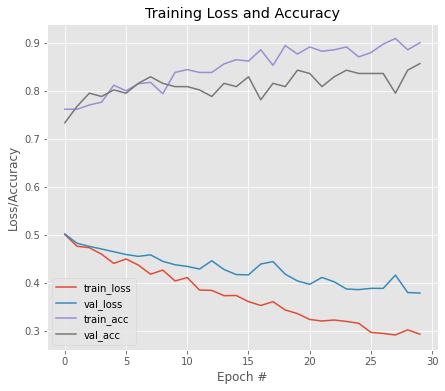


Model Performance Summary:

Best Validation accuracy:0.8561643958091736 at EPOCH:30
5/5 [==============================] - 1s 90ms/step
Accuracy: 0.8561643835616438
Sensitivity: 0.8829787234042553


Model  Accuracy  Precision    Recall  \
0  RIM-ONE_dl_A_False_0.2_0.0001_vgg19  0.856164   0.892473  0.882979   

         F1       AUC  Sensitivity  Specificity     Kappa  
0  0.887701  0.845336     0.882979     0.807692  0.687716

A_False_Split_0.2_lr_0.0001
 Training:RIM-ONE_dl_A_False_0.2_0.0001_DenseNet121,Aug:False

Epoch 1: val_loss improved from inf to 0.53184, saving model to DenseNet121_a.hdf5

Epoch 2: val_loss improved from 0.53184 to 0.40787, saving model to DenseNet121_a.hdf5

Epoch 3: val_loss did not improve from 0.40787

Epoch 4: val_loss improved from 0.40787 to 0.35213, saving model to DenseNet121_a.hdf5

Epoch 5: val_loss improved from 0.35213 to 0.34925, saving model to DenseNet121_a.hdf5

Epoch 6: val_loss did not improve from 0.34925

Epoch 7: val_loss did not improve from 0.34925

Epoch 8: val_loss improved from 0.34925 to 0.33230, saving model to DenseNet121_a.hdf5

Epoch 9: val_loss did not improve from 0.33230

Epoch 10: val_loss did not improve from 0.33230

Epoch 11: val_loss did not improve from 0.33230

Epoch 12: val_loss improved from 0.33230 to 0.32724, saving model to DenseNet121_a.hdf5

Epoch 13: val_loss did not improve from 0.32724

Epoch 14: val_loss did not improve from 0.327

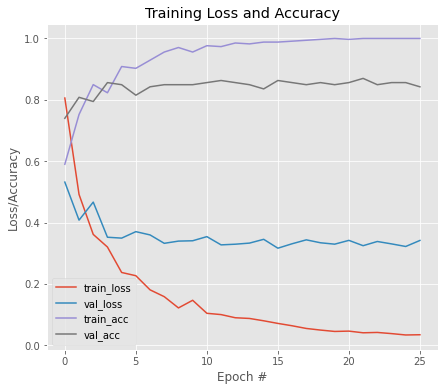


Model Performance Summary:

Best Validation accuracy:0.8698630332946777 at EPOCH:22
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 0.1220 - accuracy: 0.9558
Epoch 1: val_loss improved from inf to 0.34309, saving model to DenseNet121_wt.hdf5
11/11 [==============================] - 9s 328ms/step - loss: 0.1220 - accuracy: 0.9558 - val_loss: 0.3431 - val_accuracy: 0.8562
Epoch 2/30
10/11 [==========================>...] - ETA: 0s - loss: 0.0545 - accuracy: 0.9781
Epoch 2: val_loss improved from 0.34309 to 0.31718, saving model to DenseNet121_wt.hdf5
11/11 [==============================] - 2s 165ms/step - loss: 0.0619 - accuracy: 0.9705 - val_loss: 0.3172 - val_accuracy: 0.8562
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.0518 - accuracy: 0.9882
Epoch 3: val_loss did not improve from 0.31718
11/11 [==============================] - 1s 99ms/step - loss: 0.0518 - accuracy: 0.9882 - val_loss: 0.3696 - val_accuracy: 0.8356
Epoch 4/30
11/11 [====

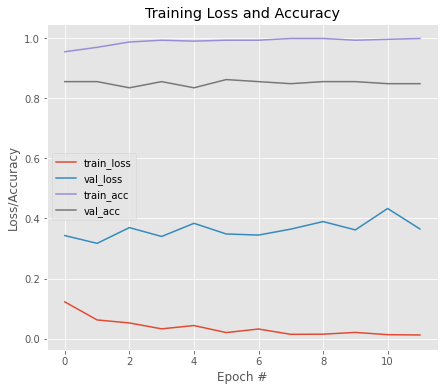


Model Performance Summary:

Best Validation accuracy:0.8630136847496033 at EPOCH:6
5/5 [==============================] - 2s 57ms/step
Accuracy: 0.8561643835616438
Sensitivity: 0.9042553191489362


Model  Accuracy  Precision    Recall  \
0  RIM-ONE_dl_A_False_0.2_0.0001_DenseNet121  0.856164   0.876289  0.904255   

         F1       AUC  Sensitivity  Specificity    Kappa  
0  0.890052  0.836743     0.904255     0.769231  0.68228

A_False_Split_0.2_lr_0.0001
 Training:RIM-ONE_dl_A_False_0.2_0.0001_MobileNet,Aug:False

Epoch 1: val_loss improved from inf to 0.53492, saving model to MobileNet_a.hdf5

Epoch 2: val_loss improved from 0.53492 to 0.44894, saving model to MobileNet_a.hdf5

Epoch 3: val_loss improved from 0.44894 to 0.36720, saving model to MobileNet_a.hdf5

Epoch 4: val_loss did not improve from 0.36720

Epoch 5: val_loss improved from 0.36720 to 0.36568, saving model to MobileNet_a.hdf5

Epoch 6: val_loss did not improve from 0.36568

Epoch 7: val_loss did not improve from 0.36568

Epoch 8: val_loss did not improve from 0.36568

Epoch 9: val_loss did not improve from 0.36568

Epoch 10: val_loss did not improve from 0.36568

Epoch 11: val_loss did not improve from 0.36568

Epoch 12: val_loss did not improve from 0.36568

Epoch 13: val_loss did not improve from 0.36568

Epoch 14: val_loss did not improve from 0.36568

Epoch 15: val_loss did not improve from 0.36568


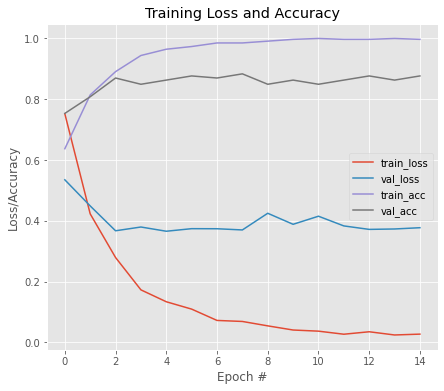


Model Performance Summary:

Best Validation accuracy:0.8835616707801819 at EPOCH:8
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 0.2488 - accuracy: 0.8879
Epoch 1: val_loss improved from inf to 0.36851, saving model to MobileNet_wt.hdf5
11/11 [==============================] - 3s 127ms/step - loss: 0.2488 - accuracy: 0.8879 - val_loss: 0.3685 - val_accuracy: 0.8562
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 0.0961 - accuracy: 0.9646
Epoch 2: val_loss did not improve from 0.36851
11/11 [==============================] - 1s 55ms/step - loss: 0.0961 - accuracy: 0.9646 - val_loss: 0.4091 - val_accuracy: 0.8562
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.0784 - accuracy: 0.9735
Epoch 3: val_loss did not improve from 0.36851
11/11 [==============================] - 1s 53ms/step - loss: 0.0784 - accuracy: 0.9735 - val_loss: 0.3751 - val_accuracy: 0.8767
Epoch 4/30
11/11 [==============================] - ETA: 0s - loss:

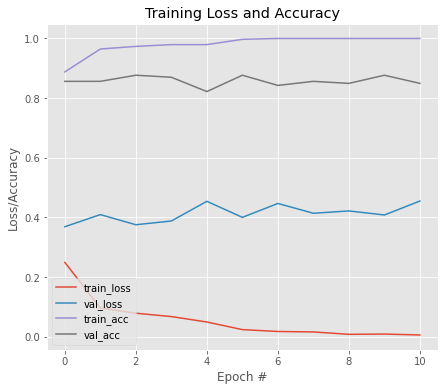


Model Performance Summary:

Best Validation accuracy:0.8767123222351074 at EPOCH:3
5/5 [==============================] - 1s 26ms/step
Accuracy: 0.8561643835616438
Sensitivity: 0.8829787234042553


Model  Accuracy  Precision    Recall  \
0  RIM-ONE_dl_A_False_0.2_0.0001_MobileNet  0.856164   0.892473  0.882979   

         F1       AUC  Sensitivity  Specificity     Kappa  
0  0.887701  0.845336     0.882979     0.807692  0.687716

A_False_Split_0.2_lr_0.0001
 Training:RIM-ONE_dl_A_False_0.2_0.0001_InceptionV3,Aug:False

Epoch 1: val_loss improved from inf to 0.47608, saving model to InceptionV3_a.hdf5

Epoch 2: val_loss improved from 0.47608 to 0.40287, saving model to InceptionV3_a.hdf5

Epoch 3: val_loss did not improve from 0.40287

Epoch 4: val_loss improved from 0.40287 to 0.37159, saving model to InceptionV3_a.hdf5

Epoch 5: val_loss improved from 0.37159 to 0.35745, saving model to InceptionV3_a.hdf5

Epoch 6: val_loss improved from 0.35745 to 0.35262, saving model to InceptionV3_a.hdf5

Epoch 7: val_loss improved from 0.35262 to 0.34157, saving model to InceptionV3_a.hdf5

Epoch 8: val_loss did not improve from 0.34157

Epoch 9: val_loss did not improve from 0.34157

Epoch 10: val_loss did not improve from 0.34157

Epoch 11: val_loss did not improve from 0.34157

Epoch 12: val_loss did not improve from 0.34157

Epoch 13: val_loss did not improve from 0.34157

Epoch 14: val_loss did not improve from 0.341

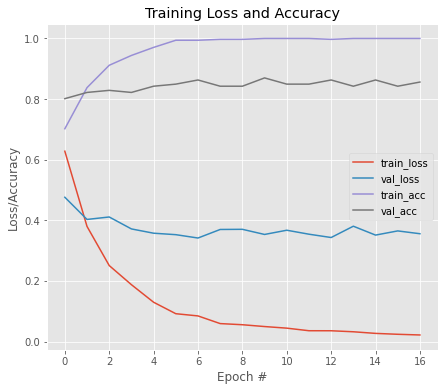


Model Performance Summary:

Best Validation accuracy:0.8698630332946777 at EPOCH:10
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 0.3367 - accuracy: 0.8938
Epoch 1: val_loss improved from inf to 0.38144, saving model to InceptionV3_wt.hdf5
11/11 [==============================] - 7s 303ms/step - loss: 0.3367 - accuracy: 0.8938 - val_loss: 0.3814 - val_accuracy: 0.8493
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 0.0554 - accuracy: 0.9941
Epoch 2: val_loss improved from 0.38144 to 0.35529, saving model to InceptionV3_wt.hdf5
11/11 [==============================] - 3s 261ms/step - loss: 0.0554 - accuracy: 0.9941 - val_loss: 0.3553 - val_accuracy: 0.8630
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.0370 - accuracy: 1.0000
Epoch 3: val_loss improved from 0.35529 to 0.34869, saving model to InceptionV3_wt.hdf5
11/11 [==============================] - 2s 191ms/step - loss: 0.0370 - accuracy: 1.0000 - val_loss: 0.3487 - v

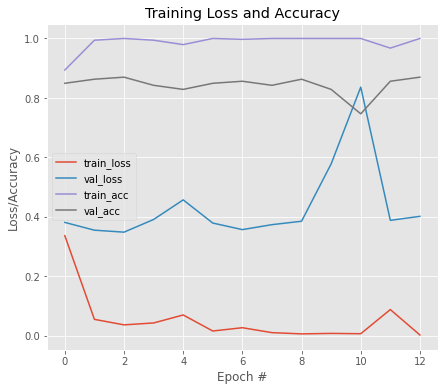


Model Performance Summary:

Best Validation accuracy:0.8698630332946777 at EPOCH:3
5/5 [==============================] - 1s 69ms/step
Accuracy: 0.8698630136986302
Sensitivity: 0.9042553191489362


Model  Accuracy  Precision    Recall  \
0  RIM-ONE_dl_A_False_0.2_0.0001_InceptionV3  0.869863   0.894737  0.904255   

         F1       AUC  Sensitivity  Specificity    Kappa  
0  0.899471  0.855974     0.904255     0.807692  0.71502

A_False_Split_0.2_lr_0.0001
 Training:RIM-ONE_dl_A_False_0.2_0.0001_InceptionResNetV2,Aug:False

Epoch 1: val_loss improved from inf to 0.58102, saving model to InceptionResNetV2_a.hdf5

Epoch 2: val_loss improved from 0.58102 to 0.53453, saving model to InceptionResNetV2_a.hdf5

Epoch 3: val_loss improved from 0.53453 to 0.52738, saving model to InceptionResNetV2_a.hdf5

Epoch 4: val_loss improved from 0.52738 to 0.48826, saving model to InceptionResNetV2_a.hdf5

Epoch 5: val_loss did not improve from 0.48826

Epoch 6: val_loss did not improve from 0.48826

Epoch 7: val_loss improved from 0.48826 to 0.47182, saving model to InceptionResNetV2_a.hdf5

Epoch 8: val_loss improved from 0.47182 to 0.45359, saving model to InceptionResNetV2_a.hdf5

Epoch 9: val_loss did not improve from 0.45359

Epoch 10: val_loss improved from 0.45359 to 0.44758, saving model to InceptionResNetV2_a.hdf5

Epoch 11: val_loss did not improve from 0.44758

Epoch 12: val_loss improved from 0.44758 to 0.43499, sa

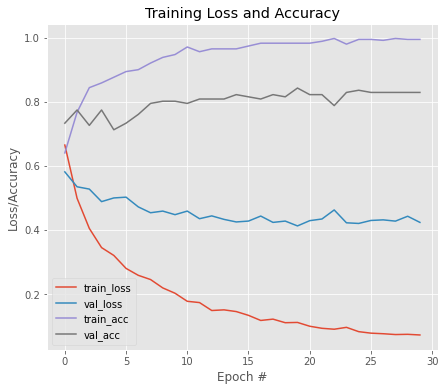


Model Performance Summary:

Best Validation accuracy:0.8424657583236694 at EPOCH:20
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 0.2083 - accuracy: 0.9233
Epoch 1: val_loss improved from inf to 0.48489, saving model to InceptionResNetV2_wt.hdf5
11/11 [==============================] - 16s 675ms/step - loss: 0.2083 - accuracy: 0.9233 - val_loss: 0.4849 - val_accuracy: 0.8014
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 0.1101 - accuracy: 0.9735
Epoch 2: val_loss improved from 0.48489 to 0.46120, saving model to InceptionResNetV2_wt.hdf5
11/11 [==============================] - 4s 397ms/step - loss: 0.1101 - accuracy: 0.9735 - val_loss: 0.4612 - val_accuracy: 0.8014
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.0758 - accuracy: 0.9912
Epoch 3: val_loss improved from 0.46120 to 0.45225, saving model to InceptionResNetV2_wt.hdf5
11/11 [==============================] - 4s 395ms/step - loss: 0.0758 - accuracy: 0.9912 - v

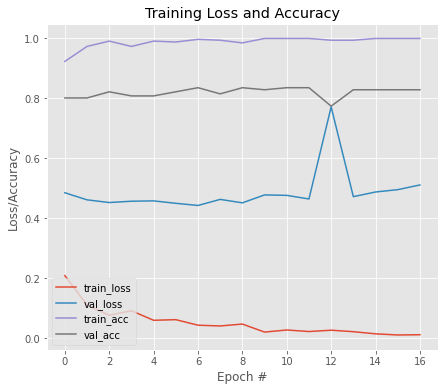


Model Performance Summary:

Best Validation accuracy:0.835616409778595 at EPOCH:7
5/5 [==============================] - 3s 168ms/step
Accuracy: 0.8356164383561644
Sensitivity: 0.9042553191489362


Model  Accuracy  Precision  \
0  RIM-ONE_dl_A_False_0.2_0.0001_InceptionResNetV2  0.835616       0.85   

     Recall        F1       AUC  Sensitivity  Specificity     Kappa  
0  0.904255  0.876289  0.807897     0.904255     0.711538  0.632087

A_False_Split_0.2_lr_0.0001
 Training:RIM-ONE_dl_A_False_0.2_0.0001_xception,Aug:False

Epoch 1: val_loss improved from inf to 0.52072, saving model to xception_a.hdf5

Epoch 2: val_loss improved from 0.52072 to 0.47257, saving model to xception_a.hdf5

Epoch 3: val_loss improved from 0.47257 to 0.46236, saving model to xception_a.hdf5

Epoch 4: val_loss improved from 0.46236 to 0.40998, saving model to xception_a.hdf5

Epoch 5: val_loss improved from 0.40998 to 0.39320, saving model to xception_a.hdf5

Epoch 6: val_loss improved from 0.39320 to 0.39020, saving model to xception_a.hdf5

Epoch 7: val_loss improved from 0.39020 to 0.36937, saving model to xception_a.hdf5

Epoch 8: val_loss did not improve from 0.36937

Epoch 9: val_loss did not improve from 0.36937

Epoch 10: val_loss did not improve from 0.36937

Epoch 11: val_loss improved from 0.36937 to 0.36159, saving model to xception_a.hdf5

Epoch 12: val_loss did not improve from 0.36159

Epoch 13: val_loss did not improve from 0

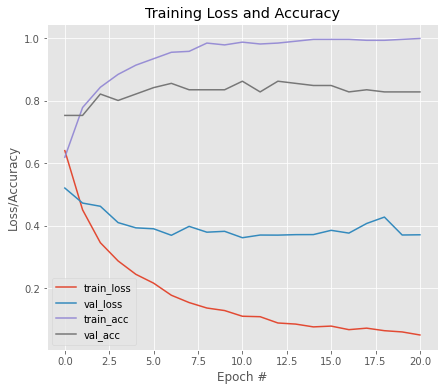


Model Performance Summary:

Best Validation accuracy:0.8630136847496033 at EPOCH:11
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 0.3064 - accuracy: 0.9086
Epoch 1: val_loss improved from inf to 0.42162, saving model to xception_wt.hdf5
11/11 [==============================] - 6s 350ms/step - loss: 0.3064 - accuracy: 0.9086 - val_loss: 0.4216 - val_accuracy: 0.8288
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 0.1227 - accuracy: 0.9469
Epoch 2: val_loss improved from 0.42162 to 0.38837, saving model to xception_wt.hdf5
11/11 [==============================] - 4s 362ms/step - loss: 0.1227 - accuracy: 0.9469 - val_loss: 0.3884 - val_accuracy: 0.8356
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.0408 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 0.38837
11/11 [==============================] - 2s 205ms/step - loss: 0.0408 - accuracy: 1.0000 - val_loss: 0.5846 - val_accuracy: 0.8014
Epoch 4/30
11/11 [=========

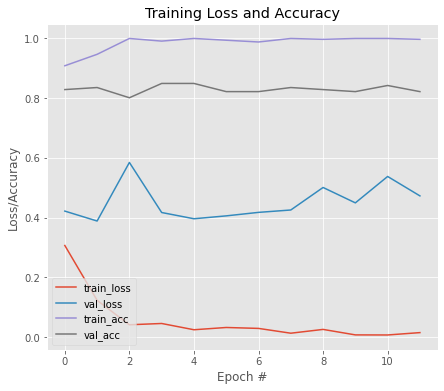


Model Performance Summary:

Best Validation accuracy:0.8493150472640991 at EPOCH:4
5/5 [==============================] - 1s 129ms/step
Accuracy: 0.8356164383561644
Sensitivity: 0.8617021276595744


Model  Accuracy  Precision    Recall  \
0  RIM-ONE_dl_A_False_0.2_0.0001_xception  0.835616   0.880435  0.861702   

         F1       AUC  Sensitivity  Specificity     Kappa  
0  0.870968  0.825082     0.861702     0.788462  0.644625

In [ ]:
set_seed()
for model in MODEL_LIST:
  set_seed()
  print(f"A_{False}_Split_{0.2}_lr_{0.0001}")
  model_obj = HIGH_LEVEL_MODEL(model)
  name = f"RIM-ONE_dl_A_{False}_{0.2}_{0.0001}_{model}"
  model_obj.train_phase(trainx3,trainy3,testx3,testy3,data_aug=False,model_name = name)

Model  Accuracy  Precision  \
0               RIM-ONE_v2_A_False_0.2_0.0001_vgg16  0.846154   0.846154   
1               RIM-ONE_v2_A_False_0.2_0.0001_vgg19  0.857143   0.850000   
2            RIM-ONE_v2_A_False_0.2_0.0001_resnet50  0.450549   0.450549   
3         RIM-ONE_v2_A_False_0.2_0.0001_DenseNet121  0.890110   0.918919   
4           RIM-ONE_v2_A_False_0.2_0.0001_MobileNet  0.879121   0.916667   
5         RIM-ONE_v2_A_False_0.2_0.0001_InceptionV3  0.890110   0.897436   
6   RIM-ONE_v2_A_False_0.2_0.0001_InceptionResNetV2  0.791209   0.789474   
7            RIM-ONE_v2_A_False_0.2_0.0001_xception  0.868132   0.871795   
8                                          vgg16_BL  0.868132   0.853659   
9                                    DenseNet121_BL  0.912088   0.902439   
10                                         vgg19_BL  0.835165   0.825000   
11                                      xception_BL  0.901099   0.880952   
12                                     MobileNet_BL  0.934066   0.972973   
13                                   InceptionV3_BL  0.879121   0.857143   
14                  ACRIMA_A_False_0.2_0.0001_vgg16  0.929078   0.900000   
15                  ACRIMA_A_False_0.2_0.0001_vgg19  0.900709   0.866667   
16            ACRIMA_A_False_0.2_0.0001_DenseNet121  0.936170   0.888889   
17              ACRIMA_A_False_0.2_0.0001_MobileNet  0.921986   0.885246   
18            ACRIMA_A_False_0.2_0.0001_InceptionV3  0.865248   0.830508   
19      ACRIMA_A_False_0.2_0.0001_InceptionResNetV2  0.815603   0.847826   
20               ACRIMA_A_False_0.2_0.0001_xception  0.872340   0.857143   
21              RIM-ONE_dl_A_False_0.2_0.0001_vgg16  0.863014   0.877551   
22              RIM-ONE_dl_A_False_0.2_0.0001_vgg19  0.856164   0.892473   
23        RIM-ONE_dl_A_False_0.2_0.0001_DenseNet121  0.856164   0.876289   
24          RIM-ONE_dl_A_False_0.2_0.0001_MobileNet  0.856164   0.892473   
25        RIM-ONE_dl_A_False_0.2_0.0001_InceptionV3  0.869863   0.894737   
26  RIM-ONE_dl_A_False_0.2_0.0001_InceptionResNetV2  0.835616   0.850000   
27           RIM-ONE_dl_A_False_0.2_0.0001_xception  0.835616   0.880435   

      Recall        F1       AUC  Sensitivity  Specificity     kappa  
0   0.804878  0.825000  0.842439     0.804878     0.880000  0.687898  
1   0.829268  0.839506  0.854634     0.829268     0.880000  0.710829  
2   1.000000  0.621212  0.500000     1.000000     0.000000  0.000000  
3   0.829268  0.871795  0.884634     0.829268     0.940000  0.776083  
4   0.804878  0.857143  0.872439     0.804878     0.940000  0.753144  
5   0.853659  0.875000  0.886829     0.853659     0.920000  0.777070  
6   0.731707  0.759494  0.785854     0.731707     0.840000  0.575497  
7   0.829268  0.850000  0.864634     0.829268     0.900000  0.732484  
8   0.853659  0.853659  0.866829     0.853659     0.880000  0.733659  
9   0.902439  0.902439  0.911220     0.902439     0.920000  0.822439  
10  0.804878  0.814815  0.832439     0.804878     0.860000  0.666341  
11  0.902439  0.891566  0.901220     0.902439     0.900000  0.800681  
12  0.878049  0.923077  0.929024     0.878049     0.980000  0.865650  
13  0.878049  0.867470  0.879024     0.878049     0.880000  0.756388  
14  0.931034  0.915254  0.929373     0.931034     0.927711  0.854309  
15  0.896552  0.881356  0.900083     0.896552     0.903614  0.796032  
16  0.965517  0.925620  0.940590     0.965517     0.915663  0.869886  
17  0.931034  0.907563  0.923349     0.931034     0.915663  0.840153  
18  0.844828  0.837607  0.862173     0.844828     0.879518  0.722470  
19  0.672414  0.750000  0.794038     0.672414     0.915663  0.606990  
20  0.827586  0.842105  0.865600     0.827586     0.903614  0.735018  
21  0.914894  0.895833  0.842062     0.914894     0.769231  0.696087  
22  0.882979  0.887701  0.845336     0.882979     0.807692  0.687716  
23  0.904255  0.890052  0.836743     0.904255     0.769231  0.682280  
24  0.882979  0.887701  0.845336     0.882979     0.807692  0.6877

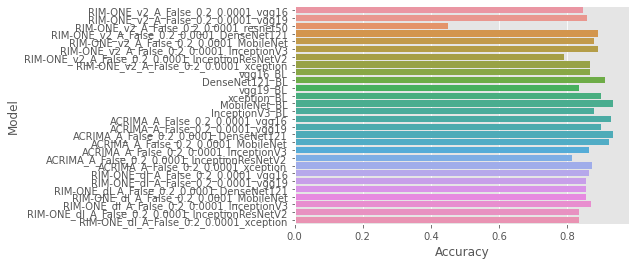

\begin{tabular}{lrrrrrrrr}
\toprule
                                          Model &  Accuracy &  Precision &   Recall &       F1 &      AUC &  Sensitivity &  Specificity &    kappa \\
\midrule
            RIM-ONE\_v2\_A\_False\_0.2\_0.0001\_vgg16 &  0.846154 &   0.846154 & 0.804878 & 0.825000 & 0.842439 &     0.804878 &     0.880000 & 0.687898 \\
            RIM-ONE\_v2\_A\_False\_0.2\_0.0001\_vgg19 &  0.857143 &   0.850000 & 0.829268 & 0.839506 & 0.854634 &     0.829268 &     0.880000 & 0.710829 \\
         RIM-ONE\_v2\_A\_False\_0.2\_0.0001\_resnet50 &  0.450549 &   0.450549 & 1.000000 & 0.621212 & 0.500000 &     1.000000 &     0.000000 & 0.000000 \\
      RIM-ONE\_v2\_A\_False\_0.2\_0.0001\_DenseNet121 &  0.890110 &   0.918919 & 0.829268 & 0.871795 & 0.884634 &     0.829268 &     0.940000 & 0.776083 \\
        RIM-ONE\_v2\_A\_False\_0.2\_0.0001\_MobileNet &  0.879121 &   0.916667 & 0.804878 & 0.857143 & 0.872439 &     0.804878 &     0.940000 & 0.753144 \\
      RIM-ONE\_v2\_A\_Fal

In [ ]:
plot_performance()

# NEW ENSEMBLE

In [ ]:
class ENSEMBLE:
  def __init__(self,pre_trained_model_list,inputshape = (299,299,3)):
     self.pre_trained_model = pre_trained_model_list#['vgg16','DenseNet121','InceptionV3','InceptionResNetV2', 'MobileNet']
     self.base_learners = []
     self.base_learners_acc = {}
     self.dataset = get_rim_one_db_r2(width=inputshape[0],height=inputshape[0])
     for model in self.pre_trained_model:
       self.base_learners.append(HIGH_LEVEL_MODEL(model))
     self.y_en_y_class = np.zeros(self.dataset[1][1].shape[0], dtype=int)

     self.ensemble_acc = {}

  def train_baselearner(self,data_aug=False):

    (trainx,trainy),(testx,testy) = self.dataset
    for index in range(0,len(self.pre_trained_model)):
       self.base_learners_acc[self.pre_trained_model[index]] = self.base_learners[index].train_phase(trainx,trainy,testx,testy,f'{self.pre_trained_model[index]}_BL',data_aug=data_aug)
    
    cumulative_wt = 0.0
    for index in range(0,len(self.pre_trained_model)):
       cumulative_wt = cumulative_wt +  self.base_learners[index].accuracy
       if index ==0:
          self.predicted_val = self.base_learners[index].predicted_val
          self.y_en_y_class = np.sum((self.y_en_y_class,self.base_learners[index].y_classes),axis = 0)  
          self.w_predicted_val = self.base_learners[index].predicted_val * self.base_learners[index].accuracy
       else:
          self.y_en_y_class = np.column_stack((self.y_en_y_class,self.base_learners[index].y_classes))
          self.predicted_val = np.sum((self.predicted_val,self.base_learners[index].predicted_val),axis = 0)
          self.w_predicted_val = np.sum((self.w_predicted_val,self.base_learners[index].predicted_val * self.base_learners[index].accuracy),axis = 0)
      
       self.w_predicted_val = self.w_predicted_val/cumulative_wt

  def get_ensemble_acc(self):

     actual_val = self.dataset[1][1].argmax(axis=-1)
     mv_predicted_val = self.y_en_y_class.sum(axis = -1 )
     mv_predicted_val = np.array([1 if item>len(self.pre_trained_model)//2 else 0 for item in mv_predicted_val])
     self.ensemble_acc['MajorityVoting'] = utilfuncs(actual_val,mv_predicted_val)

     av_predicted_val = np.argmax(self.predicted_val/len(self.pre_trained_model),axis=-1)
     self.ensemble_acc['Averaging'] = utilfuncs(actual_val,av_predicted_val)

     w_predicted_val = np.argmax(self.w_predicted_val,axis=-1)
     self.ensemble_acc['WeightedAveraging'] = utilfuncs(actual_val,w_predicted_val) 

  def print_ensemble_performance(self):
    
    mv_result = self.ensemble_acc['MajorityVoting']
    model_performance = [('MV',mv_result[0],mv_result[1],mv_result[2],mv_result[3],mv_result[4],mv_result[5],mv_result[6],mv_result[7])]

    mv_result = self.ensemble_acc['Averaging']
    model_performance.append(['AV',mv_result[0],mv_result[1],mv_result[2],mv_result[3],mv_result[4],mv_result[5],mv_result[6],mv_result[7]])

    mv_result = self.ensemble_acc['WeightedAveraging']
    model_performance.append(['WAV',mv_result[0],mv_result[1],mv_result[2],mv_result[3],mv_result[4],mv_result[5],mv_result[6],mv_result[7]])

    for index in range(0,len(self.pre_trained_model)):
       base_lr = self.base_learners[index]
       model_performance.append([base_lr.model.name,base_lr.accuracy,base_lr.precision,base_lr.recall,base_lr.f1,base_lr.auc,base_lr.sensitivity,base_lr.specificity,base_lr.kappa])
    
    df = pd.DataFrame(model_performance, columns = ['Model', 'Accuracy','Precision','Recall','F1','AUC','Sensitivity','Specificity','Kappa'])
    display(df)  

In [ ]:
def utilfuncs(actual_val,predicted_val):
   tn, fp, fn, tp = confusion_matrix(actual_val, predicted_val).ravel()
   final_accuracy = accuracy_score(actual_val, predicted_val)
   final_sensitivity=tp/(tp+fn)
   specificity = tn/(tn+fp)
   kappa = cohen_kappa_score(actual_val, predicted_val)
   precision = precision_score(actual_val, predicted_val)
   recall = recall_score(actual_val, predicted_val)
   f1 = f1_score(actual_val, predicted_val)
   fpr, tpr, thresholds = metrics.roc_curve(actual_val, predicted_val)
   auc = metrics.auc(fpr, tpr)

   return (final_accuracy,precision,recall,f1,auc,final_sensitivity,specificity,kappa)

# Ensemble Result

Height:299 Width:299
 Training:vgg16_BL,Aug:False

Epoch 1: val_loss improved from inf to 0.73016, saving model to vgg16_a.hdf5

Epoch 2: val_loss improved from 0.73016 to 0.63265, saving model to vgg16_a.hdf5

Epoch 3: val_loss improved from 0.63265 to 0.62632, saving model to vgg16_a.hdf5

Epoch 4: val_loss improved from 0.62632 to 0.59753, saving model to vgg16_a.hdf5

Epoch 5: val_loss improved from 0.59753 to 0.59010, saving model to vgg16_a.hdf5

Epoch 6: val_loss did not improve from 0.59010

Epoch 7: val_loss did not improve from 0.59010

Epoch 8: val_loss improved from 0.59010 to 0.56939, saving model to vgg16_a.hdf5

Epoch 9: val_loss did not improve from 0.56939

Epoch 10: val_loss did not improve from 0.56939

Epoch 11: val_loss improved from 0.56939 to 0.56803, saving model to vgg16_a.hdf5

Epoch 12: val_loss improved from 0.56803 to 0.56137, saving model to vgg16_a.hdf5

Epoch 13: val_loss improved from 0.56137 to 0.54487, saving model to vgg16_a.hdf5

Epoch 14: val_loss 

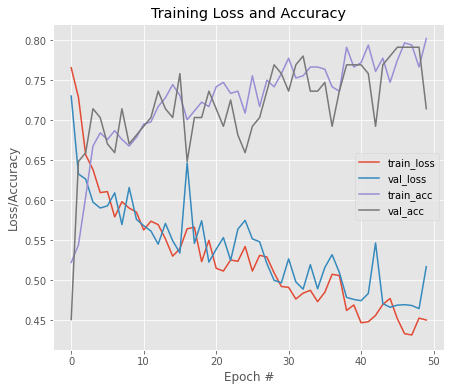


Model Performance Summary:

Best Validation accuracy:0.791208803653717 at EPOCH:46
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.4359 - accuracy: 0.8022
Epoch 1: val_loss improved from inf to 0.46125, saving model to vgg16_wt.hdf5
12/12 [==============================] - 3s 157ms/step - loss: 0.4359 - accuracy: 0.8022 - val_loss: 0.4612 - val_accuracy: 0.7582
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.4194 - accuracy: 0.8132
Epoch 2: val_loss improved from 0.46125 to 0.43927, saving model to vgg16_wt.hdf5
12/12 [==============================] - 2s 130ms/step - loss: 0.4194 - accuracy: 0.8132 - val_loss: 0.4393 - val_accuracy: 0.8132
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.4187 - accuracy: 0.8104
Epoch 3: val_loss improved from 0.43927 to 0.43905, saving model to vgg16_wt.hdf5
12/12 [==============================] - 2s 128ms/step - loss: 0.4187 - accuracy: 0.8104 - val_loss: 0.4390 - val_accuracy: 0.7912

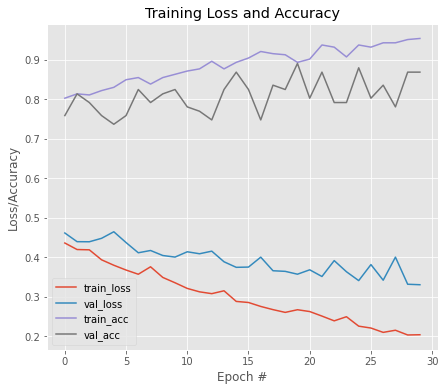


Model Performance Summary:

Best Validation accuracy:0.8901098966598511 at EPOCH:20
3/3 [==============================] - 0s 78ms/step
Accuracy: 0.8681318681318682
Sensitivity: 0.8536585365853658


Model  Accuracy  Precision    Recall        F1       AUC  Sensitivity  \
0  vgg16_BL  0.868132   0.853659  0.853659  0.853659  0.866829     0.853659   

   Specificity     Kappa  
0         0.88  0.733659

 Training:DenseNet121_BL,Aug:False

Epoch 1: val_loss improved from inf to 0.58815, saving model to DenseNet121_a.hdf5

Epoch 2: val_loss improved from 0.58815 to 0.51412, saving model to DenseNet121_a.hdf5

Epoch 3: val_loss improved from 0.51412 to 0.45524, saving model to DenseNet121_a.hdf5

Epoch 4: val_loss improved from 0.45524 to 0.42964, saving model to DenseNet121_a.hdf5

Epoch 5: val_loss improved from 0.42964 to 0.39417, saving model to DenseNet121_a.hdf5

Epoch 6: val_loss improved from 0.39417 to 0.38075, saving model to DenseNet121_a.hdf5

Epoch 7: val_loss did not improve from 0.38075

Epoch 8: val_loss improved from 0.38075 to 0.37147, saving model to DenseNet121_a.hdf5

Epoch 9: val_loss did not improve from 0.37147

Epoch 10: val_loss did not improve from 0.37147

Epoch 11: val_loss did not improve from 0.37147

Epoch 12: val_loss improved from 0.37147 to 0.36896, saving model to DenseNet121_a.hdf5

Epoch 13: val_loss did not improve from 0.36896

Epoch 14: val_loss i

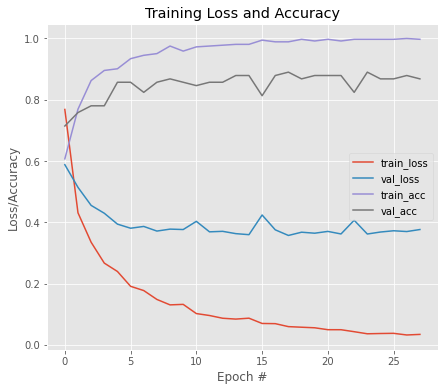


Model Performance Summary:

Best Validation accuracy:0.8901098966598511 at EPOCH:18
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.1271 - accuracy: 0.9478
Epoch 1: val_loss improved from inf to 0.53404, saving model to DenseNet121_wt.hdf5
12/12 [==============================] - 11s 360ms/step - loss: 0.1271 - accuracy: 0.9478 - val_loss: 0.5340 - val_accuracy: 0.8022
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.1013 - accuracy: 0.9615
Epoch 2: val_loss improved from 0.53404 to 0.50309, saving model to DenseNet121_wt.hdf5
12/12 [==============================] - 2s 167ms/step - loss: 0.1013 - accuracy: 0.9615 - val_loss: 0.5031 - val_accuracy: 0.8022
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.9918
Epoch 3: val_loss improved from 0.50309 to 0.44451, saving model to DenseNet121_wt.hdf5
12/12 [==============================] - 2s 165ms/step - loss: 0.0389 - accuracy: 0.9918 - val_loss: 0.4445 - 

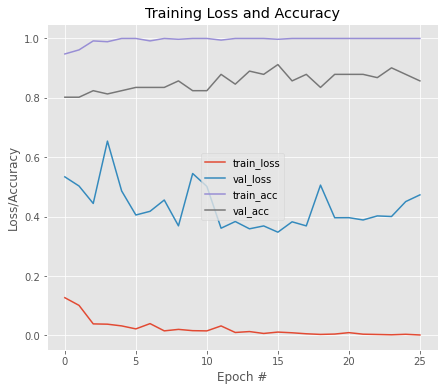


Model Performance Summary:

Best Validation accuracy:0.9120879173278809 at EPOCH:16
3/3 [==============================] - 2s 60ms/step
Accuracy: 0.9120879120879121
Sensitivity: 0.9024390243902439


Model  Accuracy  Precision    Recall        F1      AUC  \
0  DenseNet121_BL  0.912088   0.902439  0.902439  0.902439  0.91122   

   Sensitivity  Specificity     Kappa  
0     0.902439         0.92  0.822439

 Training:InceptionV3_BL,Aug:False

Epoch 1: val_loss improved from inf to 0.57316, saving model to InceptionV3_a.hdf5

Epoch 2: val_loss improved from 0.57316 to 0.48057, saving model to InceptionV3_a.hdf5

Epoch 3: val_loss improved from 0.48057 to 0.40474, saving model to InceptionV3_a.hdf5

Epoch 4: val_loss improved from 0.40474 to 0.37748, saving model to InceptionV3_a.hdf5

Epoch 5: val_loss did not improve from 0.37748

Epoch 6: val_loss did not improve from 0.37748

Epoch 7: val_loss did not improve from 0.37748

Epoch 8: val_loss did not improve from 0.37748

Epoch 9: val_loss did not improve from 0.37748

Epoch 10: val_loss did not improve from 0.37748

Epoch 11: val_loss did not improve from 0.37748

Epoch 12: val_loss did not improve from 0.37748

Epoch 13: val_loss did not improve from 0.37748

Epoch 14: val_loss did not improve from 0.37748


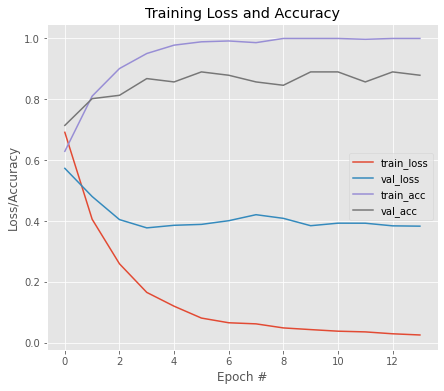


Model Performance Summary:

Best Validation accuracy:0.8901098966598511 at EPOCH:6
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.2485 - accuracy: 0.9121
Epoch 1: val_loss improved from inf to 0.45305, saving model to InceptionV3_wt.hdf5
12/12 [==============================] - 9s 321ms/step - loss: 0.2485 - accuracy: 0.9121 - val_loss: 0.4530 - val_accuracy: 0.8132
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.0861 - accuracy: 0.9753
Epoch 2: val_loss improved from 0.45305 to 0.42752, saving model to InceptionV3_wt.hdf5
12/12 [==============================] - 2s 188ms/step - loss: 0.0861 - accuracy: 0.9753 - val_loss: 0.4275 - val_accuracy: 0.8242
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.1200 - accuracy: 0.9560
Epoch 3: val_loss did not improve from 0.42752
12/12 [==============================] - 1s 104ms/step - loss: 0.1200 - accuracy: 0.9560 - val_loss: 0.9094 - val_accuracy: 0.6044
Epoch 4/30
12/12 [====

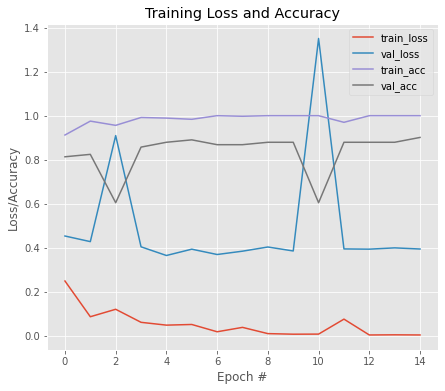


Model Performance Summary:

Best Validation accuracy:0.901098906993866 at EPOCH:15
3/3 [==============================] - 2s 74ms/step
Accuracy: 0.8791208791208791
Sensitivity: 0.8780487804878049


Model  Accuracy  Precision    Recall       F1       AUC  \
0  InceptionV3_BL  0.879121   0.857143  0.878049  0.86747  0.879024   

   Sensitivity  Specificity     Kappa  
0     0.878049         0.88  0.756388

 Training:InceptionResNetV2_BL,Aug:False

Epoch 1: val_loss improved from inf to 0.64325, saving model to InceptionResNetV2_a.hdf5

Epoch 2: val_loss improved from 0.64325 to 0.59244, saving model to InceptionResNetV2_a.hdf5

Epoch 3: val_loss improved from 0.59244 to 0.55816, saving model to InceptionResNetV2_a.hdf5

Epoch 4: val_loss improved from 0.55816 to 0.55260, saving model to InceptionResNetV2_a.hdf5

Epoch 5: val_loss improved from 0.55260 to 0.53037, saving model to InceptionResNetV2_a.hdf5

Epoch 6: val_loss did not improve from 0.53037

Epoch 7: val_loss improved from 0.53037 to 0.52229, saving model to InceptionResNetV2_a.hdf5

Epoch 8: val_loss improved from 0.52229 to 0.50799, saving model to InceptionResNetV2_a.hdf5

Epoch 9: val_loss improved from 0.50799 to 0.50546, saving model to InceptionResNetV2_a.hdf5

Epoch 10: val_loss did not improve from 0.50546

Epoch 11: val_loss did not improve from 0.50546

Epoch 12: val_loss did not improve from 0.50546

Epoch 13: val_l

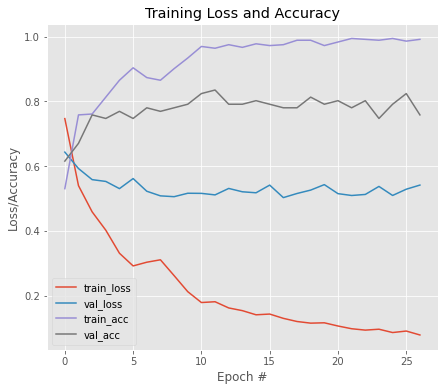


Model Performance Summary:

Best Validation accuracy:0.8351648449897766 at EPOCH:12
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.2144 - accuracy: 0.9231
Epoch 1: val_loss improved from inf to 0.52710, saving model to InceptionResNetV2_wt.hdf5
12/12 [==============================] - 20s 702ms/step - loss: 0.2144 - accuracy: 0.9231 - val_loss: 0.5271 - val_accuracy: 0.7802
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.1251 - accuracy: 0.9588
Epoch 2: val_loss improved from 0.52710 to 0.52586, saving model to InceptionResNetV2_wt.hdf5
12/12 [==============================] - 4s 381ms/step - loss: 0.1251 - accuracy: 0.9588 - val_loss: 0.5259 - val_accuracy: 0.7802
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.1019 - accuracy: 0.9780
Epoch 3: val_loss improved from 0.52586 to 0.51939, saving model to InceptionResNetV2_wt.hdf5
12/12 [==============================] - 4s 384ms/step - loss: 0.1019 - accuracy: 0.9780 - v

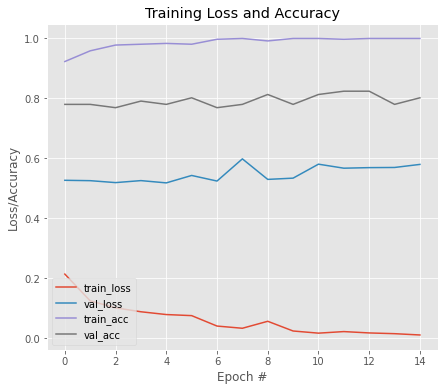


Model Performance Summary:

Best Validation accuracy:0.8241758346557617 at EPOCH:12
3/3 [==============================] - 4s 177ms/step
Accuracy: 0.7802197802197802
Sensitivity: 0.7560975609756098


Model  Accuracy  Precision    Recall        F1       AUC  \
0  InceptionResNetV2_BL   0.78022   0.756098  0.756098  0.756098  0.778049   

   Sensitivity  Specificity     Kappa  
0     0.756098          0.8  0.556098

 Training:MobileNet_BL,Aug:False

Epoch 1: val_loss improved from inf to 0.60089, saving model to MobileNet_a.hdf5

Epoch 2: val_loss improved from 0.60089 to 0.46318, saving model to MobileNet_a.hdf5

Epoch 3: val_loss improved from 0.46318 to 0.46010, saving model to MobileNet_a.hdf5

Epoch 4: val_loss improved from 0.46010 to 0.36838, saving model to MobileNet_a.hdf5

Epoch 5: val_loss did not improve from 0.36838

Epoch 6: val_loss improved from 0.36838 to 0.34418, saving model to MobileNet_a.hdf5

Epoch 7: val_loss did not improve from 0.34418

Epoch 8: val_loss did not improve from 0.34418

Epoch 9: val_loss did not improve from 0.34418

Epoch 10: val_loss did not improve from 0.34418

Epoch 11: val_loss did not improve from 0.34418

Epoch 12: val_loss did not improve from 0.34418

Epoch 13: val_loss did not improve from 0.34418

Epoch 14: val_loss did not improve from 0.34418

Epoch 15: val_loss did not improve from 0.34418

Epoch 16: val_loss did not improve from 0.34418


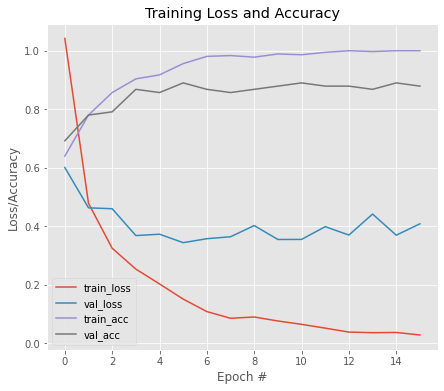


Model Performance Summary:

Best Validation accuracy:0.8901098966598511 at EPOCH:6
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.2988 - accuracy: 0.8901
Epoch 1: val_loss improved from inf to 0.57440, saving model to MobileNet_wt.hdf5
12/12 [==============================] - 3s 135ms/step - loss: 0.2988 - accuracy: 0.8901 - val_loss: 0.5744 - val_accuracy: 0.7473
Epoch 2/30
11/12 [==========================>...] - ETA: 0s - loss: 0.1293 - accuracy: 0.9639
Epoch 2: val_loss improved from 0.57440 to 0.48878, saving model to MobileNet_wt.hdf5
12/12 [==============================] - 1s 80ms/step - loss: 0.1278 - accuracy: 0.9643 - val_loss: 0.4888 - val_accuracy: 0.8132
Epoch 3/30
11/12 [==========================>...] - ETA: 0s - loss: 0.1093 - accuracy: 0.9578
Epoch 3: val_loss improved from 0.48878 to 0.40671, saving model to MobileNet_wt.hdf5
12/12 [==============================] - 1s 80ms/step - loss: 0.1042 - accuracy: 0.9615 - val_loss: 0.4067 - val_accura

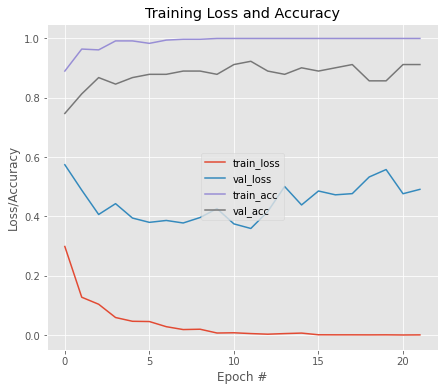


Model Performance Summary:

Best Validation accuracy:0.9230769276618958 at EPOCH:12
3/3 [==============================] - 1s 25ms/step
Accuracy: 0.9230769230769231
Sensitivity: 0.8536585365853658


Model  Accuracy  Precision    Recall        F1       AUC  \
0  MobileNet_BL  0.923077   0.972222  0.853659  0.909091  0.916829   

   Sensitivity  Specificity    Kappa  
0     0.853659         0.98  0.84291

Model  Accuracy  Precision    Recall        F1       AUC  \
0                 MV  0.934066   0.926829  0.926829  0.926829  0.933415   
1                 AV  0.934066   0.926829  0.926829  0.926829  0.933415   
2                WAV  0.912088   0.923077  0.878049  0.900000  0.909024   
3              vgg16  0.868132   0.853659  0.853659  0.853659  0.866829   
4        DenseNet121  0.912088   0.902439  0.902439  0.902439  0.911220   
5        InceptionV3  0.879121   0.857143  0.878049  0.867470  0.879024   
6  InceptionResNetV2  0.780220   0.756098  0.756098  0.756098  0.778049   
7          MobileNet  0.923077   0.972222  0.853659  0.909091  0.916829   

   Sensitivity  Specificity     Kappa  
0     0.926829         0.94  0.866829  
1     0.926829         0.94  0.866829  
2     0.878049         0.94  0.821656  
3     0.853659         0.88  0.733659  
4     0.902439         0.92  0.822439  
5     0.878049         0.88  0.756388  
6     0.756098         0.80  0.556098  
7     0.853659         0.98  0.842910

In [ ]:
en_obj = ENSEMBLE(['vgg16','DenseNet121','InceptionV3','InceptionResNetV2', 'MobileNet'])
en_obj.train_baselearner(data_aug=False)
en_obj.get_ensemble_acc()
en_obj.print_ensemble_performance()

Height:299 Width:299
80150528/80134624 [==============================] - 1s 0us/step
 Training:vgg16_BL,Aug:False

Epoch 1: val_loss improved from inf to 0.73016, saving model to vgg16_a.hdf5

Epoch 2: val_loss improved from 0.73016 to 0.63265, saving model to vgg16_a.hdf5

Epoch 3: val_loss improved from 0.63265 to 0.62632, saving model to vgg16_a.hdf5

Epoch 4: val_loss improved from 0.62632 to 0.59753, saving model to vgg16_a.hdf5

Epoch 5: val_loss improved from 0.59753 to 0.59010, saving model to vgg16_a.hdf5

Epoch 6: val_loss did not improve from 0.59010

Epoch 7: val_loss did not improve from 0.59010

Epoch 8: val_loss improved from 0.59010 to 0.56939, saving model to vgg16_a.hdf5

Epoch 9: val_loss did not improve from 0.56939

Epoch 10: val_loss did not improve from 0.56939

Epoch 11: val_loss improved from 0.56939 to 0.56803, saving model to vgg16_a.hdf5

Epoch 12: val_loss improved from 0.56803 to 0.56137, saving model to vgg16_a.hdf5

Epoch 13: val_loss improved from 0.56

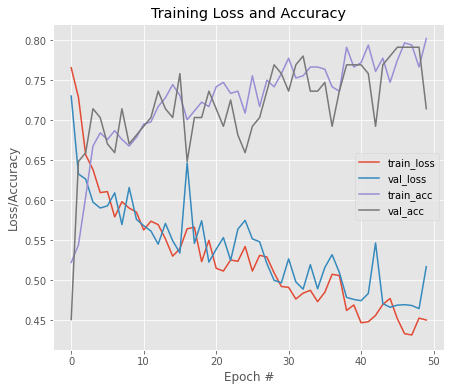


Model Performance Summary:

Best Validation accuracy:0.791208803653717 at EPOCH:46
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.4359 - accuracy: 0.8022
Epoch 1: val_loss improved from inf to 0.46125, saving model to vgg16_wt.hdf5
12/12 [==============================] - 3s 184ms/step - loss: 0.4359 - accuracy: 0.8022 - val_loss: 0.4612 - val_accuracy: 0.7582
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.4194 - accuracy: 0.8132
Epoch 2: val_loss improved from 0.46125 to 0.43927, saving model to vgg16_wt.hdf5
12/12 [==============================] - 2s 129ms/step - loss: 0.4194 - accuracy: 0.8132 - val_loss: 0.4393 - val_accuracy: 0.8132
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.4187 - accuracy: 0.8104
Epoch 3: val_loss improved from 0.43927 to 0.43905, saving model to vgg16_wt.hdf5
12/12 [==============================] - 2s 131ms/step - loss: 0.4187 - accuracy: 0.8104 - val_loss: 0.4390 - val_accuracy: 0.7912

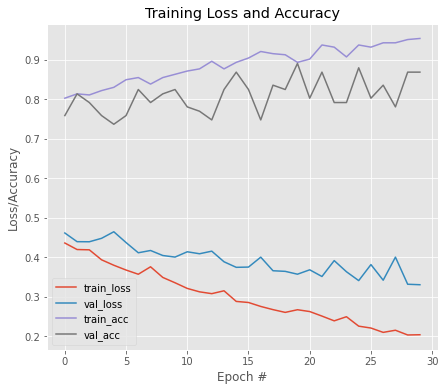


Model Performance Summary:

Best Validation accuracy:0.8901098966598511 at EPOCH:20
3/3 [==============================] - 0s 82ms/step
Accuracy: 0.8681318681318682
Sensitivity: 0.8536585365853658


Model  Accuracy  Precision    Recall        F1       AUC  Sensitivity  \
0  vgg16_BL  0.868132   0.853659  0.853659  0.853659  0.866829     0.853659   

   Specificity     Kappa  
0         0.88  0.733659

 Training:DenseNet121_BL,Aug:False

Epoch 1: val_loss improved from inf to 0.58815, saving model to DenseNet121_a.hdf5

Epoch 2: val_loss improved from 0.58815 to 0.51412, saving model to DenseNet121_a.hdf5

Epoch 3: val_loss improved from 0.51412 to 0.45524, saving model to DenseNet121_a.hdf5

Epoch 4: val_loss improved from 0.45524 to 0.42964, saving model to DenseNet121_a.hdf5

Epoch 5: val_loss improved from 0.42964 to 0.39417, saving model to DenseNet121_a.hdf5

Epoch 6: val_loss improved from 0.39417 to 0.38075, saving model to DenseNet121_a.hdf5

Epoch 7: val_loss did not improve from 0.38075

Epoch 8: val_loss improved from 0.38075 to 0.37147, saving model to DenseNet121_a.hdf5

Epoch 9: val_loss did not improve from 0.37147

Epoch 10: val_loss did not improve from 0.37147

Epoch 11: val_loss did not improve from 0.37147

Epoch 12: val_loss improved from 0.37147 to 0.36896, saving model to DenseNet121_a.hdf5

Epoch 13: val_loss did not improve from 0.36896

Epoch 14: val_loss i

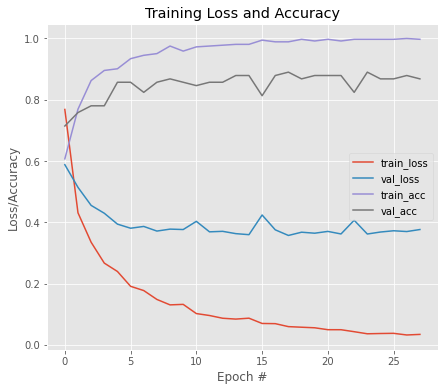


Model Performance Summary:

Best Validation accuracy:0.8901098966598511 at EPOCH:18
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.1271 - accuracy: 0.9478
Epoch 1: val_loss improved from inf to 0.53404, saving model to DenseNet121_wt.hdf5
12/12 [==============================] - 11s 356ms/step - loss: 0.1271 - accuracy: 0.9478 - val_loss: 0.5340 - val_accuracy: 0.8022
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.1013 - accuracy: 0.9615
Epoch 2: val_loss improved from 0.53404 to 0.50309, saving model to DenseNet121_wt.hdf5
12/12 [==============================] - 2s 164ms/step - loss: 0.1013 - accuracy: 0.9615 - val_loss: 0.5031 - val_accuracy: 0.8022
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.9918
Epoch 3: val_loss improved from 0.50309 to 0.44451, saving model to DenseNet121_wt.hdf5
12/12 [==============================] - 2s 168ms/step - loss: 0.0389 - accuracy: 0.9918 - val_loss: 0.4445 - 

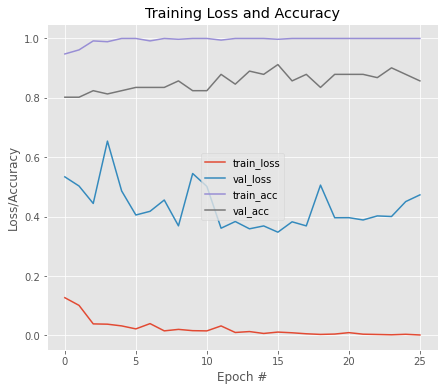


Model Performance Summary:

Best Validation accuracy:0.9120879173278809 at EPOCH:16
3/3 [==============================] - 2s 61ms/step
Accuracy: 0.9120879120879121
Sensitivity: 0.9024390243902439


Model  Accuracy  Precision    Recall        F1      AUC  \
0  DenseNet121_BL  0.912088   0.902439  0.902439  0.902439  0.91122   

   Sensitivity  Specificity     Kappa  
0     0.902439         0.92  0.822439

 Training:InceptionV3_BL,Aug:False

Epoch 1: val_loss improved from inf to 0.57316, saving model to InceptionV3_a.hdf5

Epoch 2: val_loss improved from 0.57316 to 0.48057, saving model to InceptionV3_a.hdf5

Epoch 3: val_loss improved from 0.48057 to 0.40474, saving model to InceptionV3_a.hdf5

Epoch 4: val_loss improved from 0.40474 to 0.37748, saving model to InceptionV3_a.hdf5

Epoch 5: val_loss did not improve from 0.37748

Epoch 6: val_loss did not improve from 0.37748

Epoch 7: val_loss did not improve from 0.37748

Epoch 8: val_loss did not improve from 0.37748

Epoch 9: val_loss did not improve from 0.37748

Epoch 10: val_loss did not improve from 0.37748

Epoch 11: val_loss did not improve from 0.37748

Epoch 12: val_loss did not improve from 0.37748

Epoch 13: val_loss did not improve from 0.37748

Epoch 14: val_loss did not improve from 0.37748


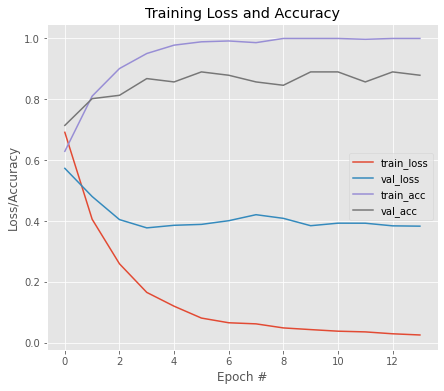


Model Performance Summary:

Best Validation accuracy:0.8901098966598511 at EPOCH:6
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.2485 - accuracy: 0.9121
Epoch 1: val_loss improved from inf to 0.45305, saving model to InceptionV3_wt.hdf5
12/12 [==============================] - 9s 320ms/step - loss: 0.2485 - accuracy: 0.9121 - val_loss: 0.4530 - val_accuracy: 0.8132
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.0861 - accuracy: 0.9753
Epoch 2: val_loss improved from 0.45305 to 0.42752, saving model to InceptionV3_wt.hdf5
12/12 [==============================] - 2s 208ms/step - loss: 0.0861 - accuracy: 0.9753 - val_loss: 0.4275 - val_accuracy: 0.8242
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.1200 - accuracy: 0.9560
Epoch 3: val_loss did not improve from 0.42752
12/12 [==============================] - 1s 102ms/step - loss: 0.1200 - accuracy: 0.9560 - val_loss: 0.9094 - val_accuracy: 0.6044
Epoch 4/30
12/12 [====

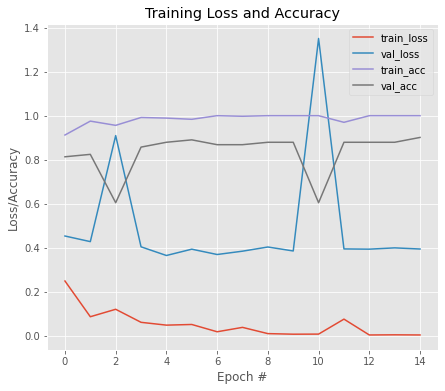


Model Performance Summary:

Best Validation accuracy:0.901098906993866 at EPOCH:15
3/3 [==============================] - 2s 72ms/step
Accuracy: 0.8791208791208791
Sensitivity: 0.8780487804878049


Model  Accuracy  Precision    Recall       F1       AUC  \
0  InceptionV3_BL  0.879121   0.857143  0.878049  0.86747  0.879024   

   Sensitivity  Specificity     Kappa  
0     0.878049         0.88  0.756388

 Training:vgg19_BL,Aug:False

Epoch 1: val_loss improved from inf to 0.70810, saving model to vgg19_a.hdf5

Epoch 2: val_loss improved from 0.70810 to 0.69526, saving model to vgg19_a.hdf5

Epoch 3: val_loss improved from 0.69526 to 0.64707, saving model to vgg19_a.hdf5

Epoch 4: val_loss improved from 0.64707 to 0.63605, saving model to vgg19_a.hdf5

Epoch 5: val_loss improved from 0.63605 to 0.62569, saving model to vgg19_a.hdf5

Epoch 6: val_loss did not improve from 0.62569

Epoch 7: val_loss improved from 0.62569 to 0.60860, saving model to vgg19_a.hdf5

Epoch 8: val_loss did not improve from 0.60860

Epoch 9: val_loss did not improve from 0.60860

Epoch 10: val_loss did not improve from 0.60860

Epoch 11: val_loss improved from 0.60860 to 0.59950, saving model to vgg19_a.hdf5

Epoch 12: val_loss improved from 0.59950 to 0.58804, saving model to vgg19_a.hdf5

Epoch 13: val_loss did not improve from 0.58804

Epoch 14: val_loss did not improve from 0.58804

Epoch 15: val_loss improv

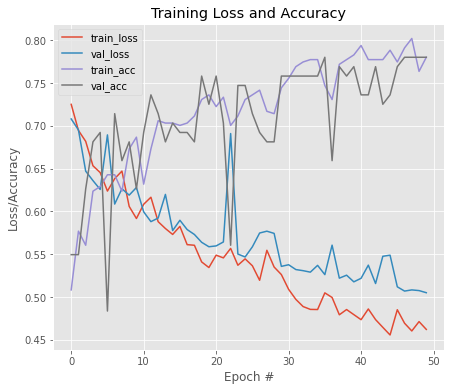


Model Performance Summary:

Best Validation accuracy:0.7802197933197021 at EPOCH:36
Epoch 1/30
11/12 [==========================>...] - ETA: 0s - loss: 0.4498 - accuracy: 0.7812
Epoch 1: val_loss improved from inf to 0.51473, saving model to vgg19_wt.hdf5
12/12 [==============================] - 3s 175ms/step - loss: 0.4537 - accuracy: 0.7747 - val_loss: 0.5147 - val_accuracy: 0.7473
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.4430 - accuracy: 0.8022
Epoch 2: val_loss improved from 0.51473 to 0.49361, saving model to vgg19_wt.hdf5
12/12 [==============================] - 2s 151ms/step - loss: 0.4430 - accuracy: 0.8022 - val_loss: 0.4936 - val_accuracy: 0.7582
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.4247 - accuracy: 0.8269
Epoch 3: val_loss improved from 0.49361 to 0.48718, saving model to vgg19_wt.hdf5
12/12 [==============================] - 2s 151ms/step - loss: 0.4247 - accuracy: 0.8269 - val_loss: 0.4872 - val_accuracy: 0.780

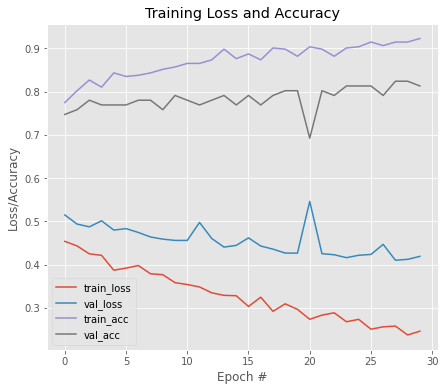


Model Performance Summary:

Best Validation accuracy:0.8241758346557617 at EPOCH:28
3/3 [==============================] - 0s 90ms/step
Accuracy: 0.8241758241758241
Sensitivity: 0.7804878048780488


Model  Accuracy  Precision    Recall   F1       AUC  Sensitivity  \
0  vgg19_BL  0.824176   0.820513  0.780488  0.8  0.820244     0.780488   

   Specificity     Kappa  
0         0.86  0.643312

 Training:MobileNet_BL,Aug:False

Epoch 1: val_loss improved from inf to 0.58278, saving model to MobileNet_a.hdf5

Epoch 2: val_loss improved from 0.58278 to 0.45450, saving model to MobileNet_a.hdf5

Epoch 3: val_loss improved from 0.45450 to 0.40622, saving model to MobileNet_a.hdf5

Epoch 4: val_loss improved from 0.40622 to 0.36660, saving model to MobileNet_a.hdf5

Epoch 5: val_loss did not improve from 0.36660

Epoch 6: val_loss improved from 0.36660 to 0.32963, saving model to MobileNet_a.hdf5

Epoch 7: val_loss did not improve from 0.32963

Epoch 8: val_loss did not improve from 0.32963

Epoch 9: val_loss did not improve from 0.32963

Epoch 10: val_loss did not improve from 0.32963

Epoch 11: val_loss did not improve from 0.32963

Epoch 12: val_loss did not improve from 0.32963

Epoch 13: val_loss did not improve from 0.32963

Epoch 14: val_loss did not improve from 0.32963

Epoch 15: val_loss did not improve from 0.32963

Epoch 16: val_loss did not improve from 0.32963


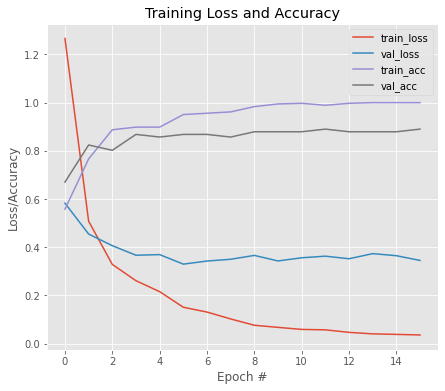


Model Performance Summary:

Best Validation accuracy:0.8901098966598511 at EPOCH:12
Epoch 1/30
11/12 [==========================>...] - ETA: 0s - loss: 0.2575 - accuracy: 0.8976
Epoch 1: val_loss improved from inf to 0.48058, saving model to MobileNet_wt.hdf5
12/12 [==============================] - 3s 135ms/step - loss: 0.2542 - accuracy: 0.8956 - val_loss: 0.4806 - val_accuracy: 0.8462
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.1490 - accuracy: 0.9451
Epoch 2: val_loss improved from 0.48058 to 0.43099, saving model to MobileNet_wt.hdf5
12/12 [==============================] - 1s 82ms/step - loss: 0.1490 - accuracy: 0.9451 - val_loss: 0.4310 - val_accuracy: 0.8681
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.0822 - accuracy: 0.9753
Epoch 3: val_loss did not improve from 0.43099
12/12 [==============================] - 1s 53ms/step - loss: 0.0822 - accuracy: 0.9753 - val_loss: 0.5219 - val_accuracy: 0.8022
Epoch 4/30
12/12 [=========

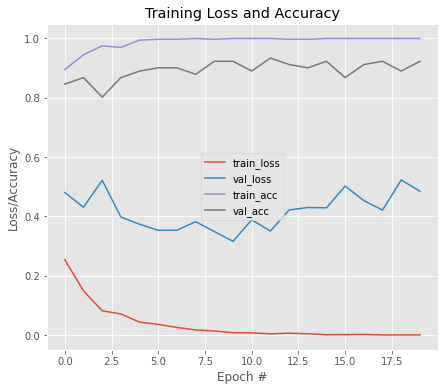


Model Performance Summary:

Best Validation accuracy:0.9340659379959106 at EPOCH:12
3/3 [==============================] - 1s 25ms/step
Accuracy: 0.9230769230769231
Sensitivity: 0.8536585365853658


Model  Accuracy  Precision    Recall        F1       AUC  \
0  MobileNet_BL  0.923077   0.972222  0.853659  0.909091  0.916829   

   Sensitivity  Specificity    Kappa  
0     0.853659         0.98  0.84291

Model  Accuracy  Precision    Recall        F1       AUC  \
0           MV  0.934066   0.926829  0.926829  0.926829  0.933415   
1           AV  0.923077   0.925000  0.902439  0.913580  0.921220   
2          WAV  0.912088   0.923077  0.878049  0.900000  0.909024   
3        vgg16  0.868132   0.853659  0.853659  0.853659  0.866829   
4  DenseNet121  0.912088   0.902439  0.902439  0.902439  0.911220   
5  InceptionV3  0.879121   0.857143  0.878049  0.867470  0.879024   
6        vgg19  0.824176   0.820513  0.780488  0.800000  0.820244   
7    MobileNet  0.923077   0.972222  0.853659  0.909091  0.916829   

   Sensitivity  Specificity     Kappa  
0     0.926829         0.94  0.866829  
1     0.902439         0.94  0.844292  
2     0.878049         0.94  0.821656  
3     0.853659         0.88  0.733659  
4     0.902439         0.92  0.822439  
5     0.878049         0.88  0.756388  
6     0.780488         0.86  0.643312  
7     0.853659         0.98  0.842910

In [ ]:
en_obj = ENSEMBLE(['vgg16','DenseNet121','InceptionV3','vgg19', 'MobileNet'])
en_obj.train_baselearner(data_aug=False)
en_obj.get_ensemble_acc()
en_obj.print_ensemble_performance()

Height:299 Width:299
83697664/83683744 [==============================] - 2s 0us/step
 Training:vgg16_BL,Aug:False

Epoch 1: val_loss improved from inf to 0.73016, saving model to vgg16_a.hdf5

Epoch 2: val_loss improved from 0.73016 to 0.63265, saving model to vgg16_a.hdf5

Epoch 3: val_loss improved from 0.63265 to 0.62632, saving model to vgg16_a.hdf5

Epoch 4: val_loss improved from 0.62632 to 0.59753, saving model to vgg16_a.hdf5

Epoch 5: val_loss improved from 0.59753 to 0.59010, saving model to vgg16_a.hdf5

Epoch 6: val_loss did not improve from 0.59010

Epoch 7: val_loss did not improve from 0.59010

Epoch 8: val_loss improved from 0.59010 to 0.56939, saving model to vgg16_a.hdf5

Epoch 9: val_loss did not improve from 0.56939

Epoch 10: val_loss did not improve from 0.56939

Epoch 11: val_loss improved from 0.56939 to 0.56803, saving model to vgg16_a.hdf5

Epoch 12: val_loss improved from 0.56803 to 0.56137, saving model to vgg16_a.hdf5

Epoch 13: val_loss improved from 0.56

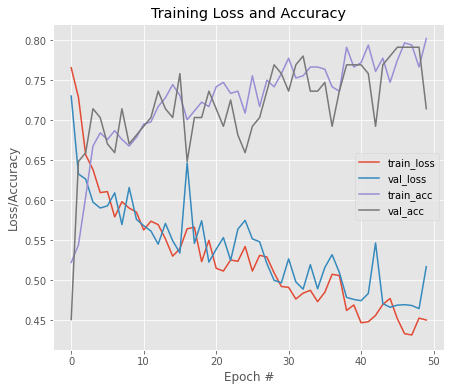


Model Performance Summary:

Best Validation accuracy:0.791208803653717 at EPOCH:46
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.4359 - accuracy: 0.8022
Epoch 1: val_loss improved from inf to 0.46125, saving model to vgg16_wt.hdf5
12/12 [==============================] - 3s 159ms/step - loss: 0.4359 - accuracy: 0.8022 - val_loss: 0.4612 - val_accuracy: 0.7582
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.4194 - accuracy: 0.8132
Epoch 2: val_loss improved from 0.46125 to 0.43927, saving model to vgg16_wt.hdf5
12/12 [==============================] - 2s 134ms/step - loss: 0.4194 - accuracy: 0.8132 - val_loss: 0.4393 - val_accuracy: 0.8132
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.4187 - accuracy: 0.8104
Epoch 3: val_loss improved from 0.43927 to 0.43905, saving model to vgg16_wt.hdf5
12/12 [==============================] - 2s 129ms/step - loss: 0.4187 - accuracy: 0.8104 - val_loss: 0.4390 - val_accuracy: 0.7912

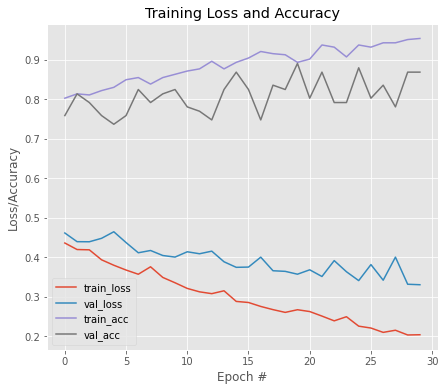


Model Performance Summary:

Best Validation accuracy:0.8901098966598511 at EPOCH:20
3/3 [==============================] - 0s 78ms/step
Accuracy: 0.8681318681318682
Sensitivity: 0.8536585365853658


Model  Accuracy  Precision    Recall        F1       AUC  Sensitivity  \
0  vgg16_BL  0.868132   0.853659  0.853659  0.853659  0.866829     0.853659   

   Specificity     Kappa  
0         0.88  0.733659

 Training:DenseNet121_BL,Aug:False

Epoch 1: val_loss improved from inf to 0.58815, saving model to DenseNet121_a.hdf5

Epoch 2: val_loss improved from 0.58815 to 0.51412, saving model to DenseNet121_a.hdf5

Epoch 3: val_loss improved from 0.51412 to 0.45524, saving model to DenseNet121_a.hdf5

Epoch 4: val_loss improved from 0.45524 to 0.42964, saving model to DenseNet121_a.hdf5

Epoch 5: val_loss improved from 0.42964 to 0.39417, saving model to DenseNet121_a.hdf5

Epoch 6: val_loss improved from 0.39417 to 0.38075, saving model to DenseNet121_a.hdf5

Epoch 7: val_loss did not improve from 0.38075

Epoch 8: val_loss improved from 0.38075 to 0.37147, saving model to DenseNet121_a.hdf5

Epoch 9: val_loss did not improve from 0.37147

Epoch 10: val_loss did not improve from 0.37147

Epoch 11: val_loss did not improve from 0.37147

Epoch 12: val_loss improved from 0.37147 to 0.36896, saving model to DenseNet121_a.hdf5

Epoch 13: val_loss did not improve from 0.36896

Epoch 14: val_loss i

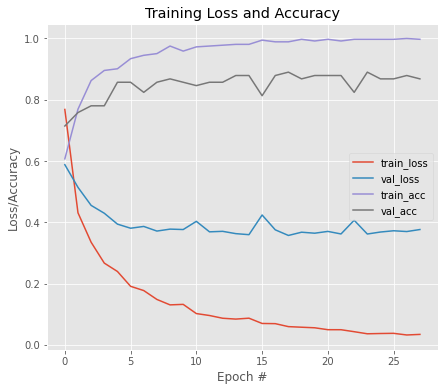


Model Performance Summary:

Best Validation accuracy:0.8901098966598511 at EPOCH:18
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.1271 - accuracy: 0.9478
Epoch 1: val_loss improved from inf to 0.53404, saving model to DenseNet121_wt.hdf5
12/12 [==============================] - 12s 363ms/step - loss: 0.1271 - accuracy: 0.9478 - val_loss: 0.5340 - val_accuracy: 0.8022
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.1013 - accuracy: 0.9615
Epoch 2: val_loss improved from 0.53404 to 0.50309, saving model to DenseNet121_wt.hdf5
12/12 [==============================] - 2s 168ms/step - loss: 0.1013 - accuracy: 0.9615 - val_loss: 0.5031 - val_accuracy: 0.8022
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.9918
Epoch 3: val_loss improved from 0.50309 to 0.44451, saving model to DenseNet121_wt.hdf5
12/12 [==============================] - 2s 163ms/step - loss: 0.0389 - accuracy: 0.9918 - val_loss: 0.4445 - 

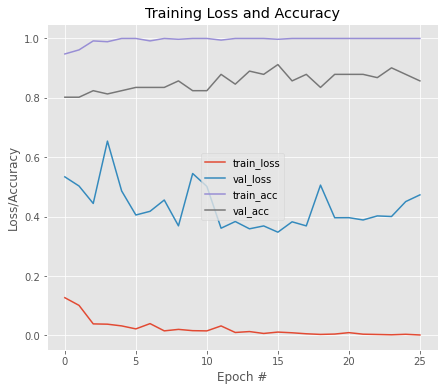


Model Performance Summary:

Best Validation accuracy:0.9120879173278809 at EPOCH:16
3/3 [==============================] - 2s 62ms/step
Accuracy: 0.9120879120879121
Sensitivity: 0.9024390243902439


Model  Accuracy  Precision    Recall        F1      AUC  \
0  DenseNet121_BL  0.912088   0.902439  0.902439  0.902439  0.91122   

   Sensitivity  Specificity     Kappa  
0     0.902439         0.92  0.822439

 Training:InceptionV3_BL,Aug:False

Epoch 1: val_loss improved from inf to 0.57316, saving model to InceptionV3_a.hdf5

Epoch 2: val_loss improved from 0.57316 to 0.48057, saving model to InceptionV3_a.hdf5

Epoch 3: val_loss improved from 0.48057 to 0.40474, saving model to InceptionV3_a.hdf5

Epoch 4: val_loss improved from 0.40474 to 0.37748, saving model to InceptionV3_a.hdf5

Epoch 5: val_loss did not improve from 0.37748

Epoch 6: val_loss did not improve from 0.37748

Epoch 7: val_loss did not improve from 0.37748

Epoch 8: val_loss did not improve from 0.37748

Epoch 9: val_loss did not improve from 0.37748

Epoch 10: val_loss did not improve from 0.37748

Epoch 11: val_loss did not improve from 0.37748

Epoch 12: val_loss did not improve from 0.37748

Epoch 13: val_loss did not improve from 0.37748

Epoch 14: val_loss did not improve from 0.37748


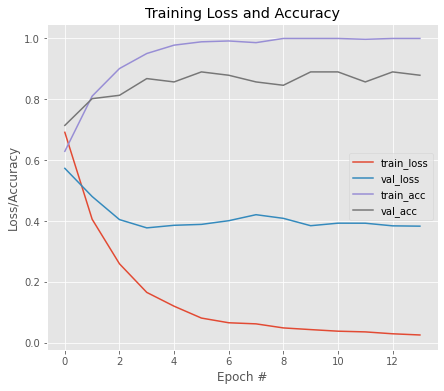


Model Performance Summary:

Best Validation accuracy:0.8901098966598511 at EPOCH:6
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.2485 - accuracy: 0.9121
Epoch 1: val_loss improved from inf to 0.45305, saving model to InceptionV3_wt.hdf5
12/12 [==============================] - 9s 323ms/step - loss: 0.2485 - accuracy: 0.9121 - val_loss: 0.4530 - val_accuracy: 0.8132
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.0861 - accuracy: 0.9753
Epoch 2: val_loss improved from 0.45305 to 0.42752, saving model to InceptionV3_wt.hdf5
12/12 [==============================] - 2s 215ms/step - loss: 0.0861 - accuracy: 0.9753 - val_loss: 0.4275 - val_accuracy: 0.8242
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.1200 - accuracy: 0.9560
Epoch 3: val_loss did not improve from 0.42752
12/12 [==============================] - 1s 104ms/step - loss: 0.1200 - accuracy: 0.9560 - val_loss: 0.9094 - val_accuracy: 0.6044
Epoch 4/30
12/12 [====

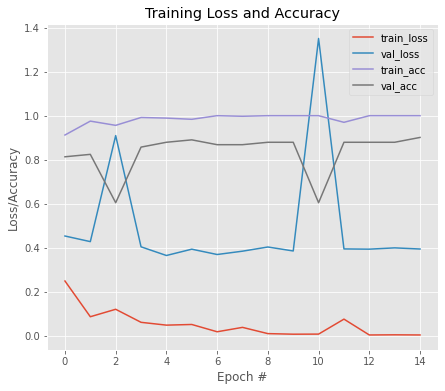


Model Performance Summary:

Best Validation accuracy:0.901098906993866 at EPOCH:15
3/3 [==============================] - 2s 71ms/step
Accuracy: 0.8791208791208791
Sensitivity: 0.8780487804878049


Model  Accuracy  Precision    Recall       F1       AUC  \
0  InceptionV3_BL  0.879121   0.857143  0.878049  0.86747  0.879024   

   Sensitivity  Specificity     Kappa  
0     0.878049         0.88  0.756388

 Training:xception_BL,Aug:False

Epoch 1: val_loss improved from inf to 0.55146, saving model to xception_a.hdf5

Epoch 2: val_loss improved from 0.55146 to 0.52583, saving model to xception_a.hdf5

Epoch 3: val_loss improved from 0.52583 to 0.47610, saving model to xception_a.hdf5

Epoch 4: val_loss improved from 0.47610 to 0.47359, saving model to xception_a.hdf5

Epoch 5: val_loss improved from 0.47359 to 0.42575, saving model to xception_a.hdf5

Epoch 6: val_loss improved from 0.42575 to 0.41443, saving model to xception_a.hdf5

Epoch 7: val_loss improved from 0.41443 to 0.39359, saving model to xception_a.hdf5

Epoch 8: val_loss improved from 0.39359 to 0.38735, saving model to xception_a.hdf5

Epoch 9: val_loss did not improve from 0.38735

Epoch 10: val_loss improved from 0.38735 to 0.37977, saving model to xception_a.hdf5

Epoch 11: val_loss did not improve from 0.37977

Epoch 12: val_loss did not improve from 0.37977

Epoch 13: val_loss improved from 0.37977 to 0.37288, saving

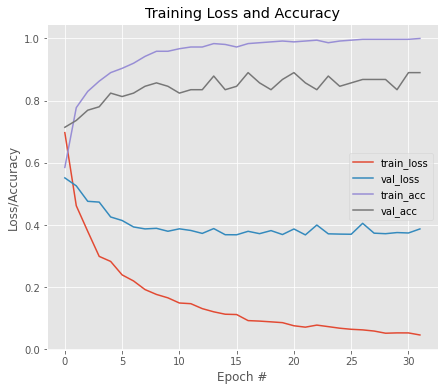


Model Performance Summary:

Best Validation accuracy:0.8901098966598511 at EPOCH:17
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.1737 - accuracy: 0.9396
Epoch 1: val_loss improved from inf to 0.47539, saving model to xception_wt.hdf5
12/12 [==============================] - 7s 325ms/step - loss: 0.1737 - accuracy: 0.9396 - val_loss: 0.4754 - val_accuracy: 0.8242
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.0503 - accuracy: 0.9918
Epoch 2: val_loss did not improve from 0.47539
12/12 [==============================] - 2s 176ms/step - loss: 0.0503 - accuracy: 0.9918 - val_loss: 0.5534 - val_accuracy: 0.7692
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.0297 - accuracy: 0.9973
Epoch 3: val_loss improved from 0.47539 to 0.41231, saving model to xception_wt.hdf5
12/12 [==============================] - 3s 251ms/step - loss: 0.0297 - accuracy: 0.9973 - val_loss: 0.4123 - val_accuracy: 0.8242
Epoch 4/30
12/12 [=========

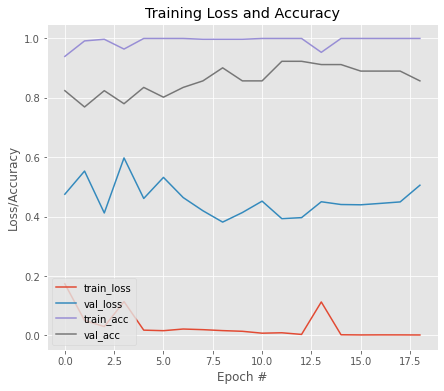


Model Performance Summary:

Best Validation accuracy:0.9230769276618958 at EPOCH:12
3/3 [==============================] - 1s 129ms/step
Accuracy: 0.9010989010989011
Sensitivity: 0.9024390243902439


Model  Accuracy  Precision    Recall        F1      AUC  Sensitivity  \
0  xception_BL  0.901099   0.880952  0.902439  0.891566  0.90122     0.902439   

   Specificity     Kappa  
0          0.9  0.800681

 Training:MobileNet_BL,Aug:False

Epoch 1: val_loss improved from inf to 0.55080, saving model to MobileNet_a.hdf5

Epoch 2: val_loss improved from 0.55080 to 0.51868, saving model to MobileNet_a.hdf5

Epoch 3: val_loss improved from 0.51868 to 0.48988, saving model to MobileNet_a.hdf5

Epoch 4: val_loss improved from 0.48988 to 0.39981, saving model to MobileNet_a.hdf5

Epoch 5: val_loss did not improve from 0.39981

Epoch 6: val_loss improved from 0.39981 to 0.37368, saving model to MobileNet_a.hdf5

Epoch 7: val_loss improved from 0.37368 to 0.34923, saving model to MobileNet_a.hdf5

Epoch 8: val_loss did not improve from 0.34923

Epoch 9: val_loss improved from 0.34923 to 0.33633, saving model to MobileNet_a.hdf5

Epoch 10: val_loss did not improve from 0.33633

Epoch 11: val_loss improved from 0.33633 to 0.32264, saving model to MobileNet_a.hdf5

Epoch 12: val_loss did not improve from 0.32264

Epoch 13: val_loss did not improve from 0.32264

Epoch 14: val_loss did not improve fro

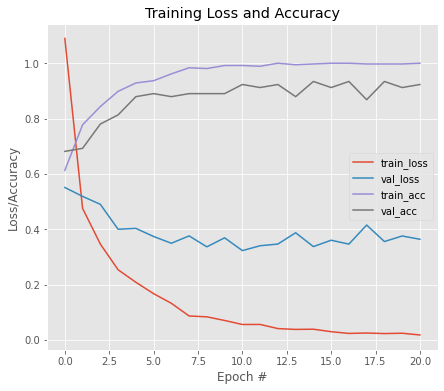


Model Performance Summary:

Best Validation accuracy:0.9340659379959106 at EPOCH:15
Epoch 1/30
11/12 [==========================>...] - ETA: 0s - loss: 0.1990 - accuracy: 0.8976
Epoch 1: val_loss improved from inf to 0.50890, saving model to MobileNet_wt.hdf5
12/12 [==============================] - 3s 134ms/step - loss: 0.1883 - accuracy: 0.9066 - val_loss: 0.5089 - val_accuracy: 0.8242
Epoch 2/30
11/12 [==========================>...] - ETA: 0s - loss: 0.1087 - accuracy: 0.9608
Epoch 2: val_loss improved from 0.50890 to 0.44822, saving model to MobileNet_wt.hdf5
12/12 [==============================] - 1s 83ms/step - loss: 0.1081 - accuracy: 0.9588 - val_loss: 0.4482 - val_accuracy: 0.8462
Epoch 3/30
11/12 [==========================>...] - ETA: 0s - loss: 0.0747 - accuracy: 0.9699
Epoch 3: val_loss did not improve from 0.44822
12/12 [==============================] - 1s 53ms/step - loss: 0.0723 - accuracy: 0.9698 - val_loss: 0.4528 - val_accuracy: 0.8352
Epoch 4/30
12/12 [=========

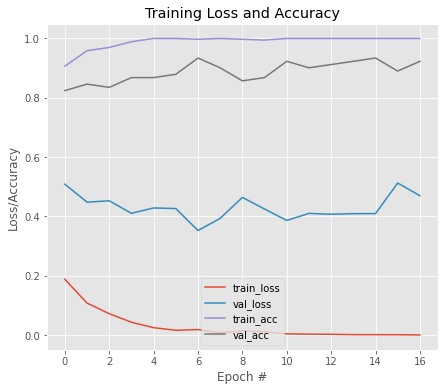


Model Performance Summary:

Best Validation accuracy:0.9340659379959106 at EPOCH:7
3/3 [==============================] - 1s 25ms/step
Accuracy: 0.9340659340659341
Sensitivity: 0.8780487804878049


Model  Accuracy  Precision    Recall        F1       AUC  \
0  MobileNet_BL  0.934066   0.972973  0.878049  0.923077  0.929024   

   Sensitivity  Specificity    Kappa  
0     0.878049         0.98  0.86565

Model  Accuracy  Precision    Recall        F1       AUC  \
0           MV  0.934066   0.926829  0.926829  0.926829  0.933415   
1           AV  0.934066   0.926829  0.926829  0.926829  0.933415   
2          WAV  0.934066   0.948718  0.902439  0.925000  0.931220   
3        vgg16  0.868132   0.853659  0.853659  0.853659  0.866829   
4  DenseNet121  0.912088   0.902439  0.902439  0.902439  0.911220   
5  InceptionV3  0.879121   0.857143  0.878049  0.867470  0.879024   
6     xception  0.901099   0.880952  0.902439  0.891566  0.901220   
7    MobileNet  0.934066   0.972973  0.878049  0.923077  0.929024   

   Sensitivity  Specificity     Kappa  
0     0.926829         0.94  0.866829  
1     0.926829         0.94  0.866829  
2     0.902439         0.96  0.866242  
3     0.853659         0.88  0.733659  
4     0.902439         0.92  0.822439  
5     0.878049         0.88  0.756388  
6     0.902439         0.90  0.800681  
7     0.878049         0.98  0.865650

In [ ]:
en_obj = ENSEMBLE(['vgg16','DenseNet121','InceptionV3','xception', 'MobileNet'])
en_obj.train_baselearner(data_aug=False)
en_obj.get_ensemble_acc()
en_obj.print_ensemble_performance()

Height:299 Width:299
 Training:DenseNet121_BL,Aug:False

Epoch 1: val_loss improved from inf to 0.51582, saving model to DenseNet121_a.hdf5

Epoch 2: val_loss improved from 0.51582 to 0.44082, saving model to DenseNet121_a.hdf5

Epoch 3: val_loss improved from 0.44082 to 0.44072, saving model to DenseNet121_a.hdf5

Epoch 4: val_loss did not improve from 0.44072

Epoch 5: val_loss improved from 0.44072 to 0.37694, saving model to DenseNet121_a.hdf5

Epoch 6: val_loss improved from 0.37694 to 0.34792, saving model to DenseNet121_a.hdf5

Epoch 7: val_loss improved from 0.34792 to 0.34174, saving model to DenseNet121_a.hdf5

Epoch 8: val_loss did not improve from 0.34174

Epoch 9: val_loss did not improve from 0.34174

Epoch 10: val_loss improved from 0.34174 to 0.33299, saving model to DenseNet121_a.hdf5

Epoch 11: val_loss improved from 0.33299 to 0.31348, saving model to DenseNet121_a.hdf5

Epoch 12: val_loss did not improve from 0.31348

Epoch 13: val_loss improved from 0.31348 to 0.30

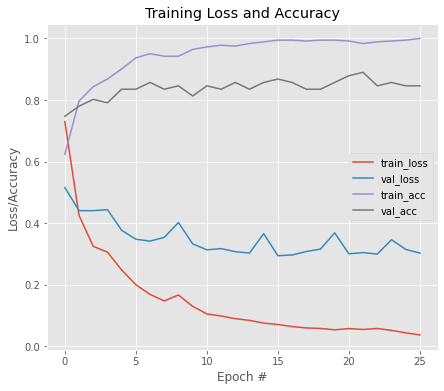


Model Performance Summary:

Best Validation accuracy:0.8901098966598511 at EPOCH:22
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.1953 - accuracy: 0.9258
Epoch 1: val_loss improved from inf to 0.31856, saving model to DenseNet121_wt.hdf5
12/12 [==============================] - 11s 363ms/step - loss: 0.1953 - accuracy: 0.9258 - val_loss: 0.3186 - val_accuracy: 0.8791
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.0653 - accuracy: 0.9863
Epoch 2: val_loss did not improve from 0.31856
12/12 [==============================] - 1s 90ms/step - loss: 0.0653 - accuracy: 0.9863 - val_loss: 0.3257 - val_accuracy: 0.8681
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.0865 - accuracy: 0.9588
Epoch 3: val_loss improved from 0.31856 to 0.31065, saving model to DenseNet121_wt.hdf5
12/12 [==============================] - 2s 167ms/step - loss: 0.0865 - accuracy: 0.9588 - val_loss: 0.3107 - val_accuracy: 0.8681
Epoch 4/30
12/12 [===

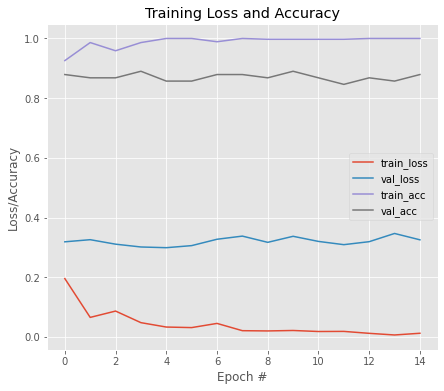


Model Performance Summary:

Best Validation accuracy:0.8901098966598511 at EPOCH:4
3/3 [==============================] - 2s 61ms/step
Accuracy: 0.8571428571428571
Sensitivity: 0.8536585365853658


Model  Accuracy  Precision    Recall        F1       AUC  \
0  DenseNet121_BL  0.857143   0.833333  0.853659  0.843373  0.856829   

   Sensitivity  Specificity     Kappa  
0     0.853659         0.86  0.712095

 Training:InceptionV3_BL,Aug:False

Epoch 1: val_loss improved from inf to 0.84675, saving model to InceptionV3_a.hdf5

Epoch 2: val_loss improved from 0.84675 to 0.46803, saving model to InceptionV3_a.hdf5

Epoch 3: val_loss improved from 0.46803 to 0.41312, saving model to InceptionV3_a.hdf5

Epoch 4: val_loss did not improve from 0.41312

Epoch 5: val_loss improved from 0.41312 to 0.38838, saving model to InceptionV3_a.hdf5

Epoch 6: val_loss improved from 0.38838 to 0.38340, saving model to InceptionV3_a.hdf5

Epoch 7: val_loss did not improve from 0.38340

Epoch 8: val_loss did not improve from 0.38340

Epoch 9: val_loss did not improve from 0.38340

Epoch 10: val_loss did not improve from 0.38340

Epoch 11: val_loss did not improve from 0.38340

Epoch 12: val_loss did not improve from 0.38340

Epoch 13: val_loss did not improve from 0.38340

Epoch 14: val_loss did not improve from 0.38340

Epoch 15: val_loss did not improve from 0.38340

Epoch 16: val_loss did not improve from 0.

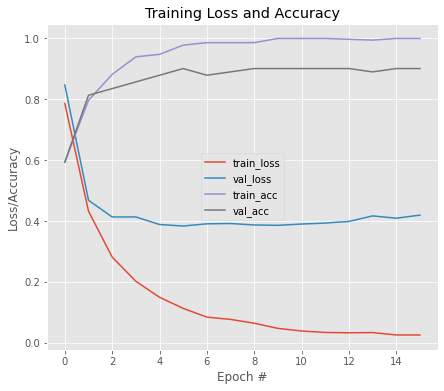


Model Performance Summary:

Best Validation accuracy:0.901098906993866 at EPOCH:6
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.2295 - accuracy: 0.8956
Epoch 1: val_loss improved from inf to 0.41143, saving model to InceptionV3_wt.hdf5
12/12 [==============================] - 9s 323ms/step - loss: 0.2295 - accuracy: 0.8956 - val_loss: 0.4114 - val_accuracy: 0.8901
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.0670 - accuracy: 0.9890
Epoch 2: val_loss improved from 0.41143 to 0.39844, saving model to InceptionV3_wt.hdf5
12/12 [==============================] - 2s 180ms/step - loss: 0.0670 - accuracy: 0.9890 - val_loss: 0.3984 - val_accuracy: 0.9121
Epoch 3/30
11/12 [==========================>...] - ETA: 0s - loss: 0.1149 - accuracy: 0.9545
Epoch 3: val_loss did not improve from 0.39844
12/12 [==============================] - 1s 104ms/step - loss: 0.1134 - accuracy: 0.9560 - val_loss: 0.5857 - val_accuracy: 0.7363
Epoch 4/30
12/12 [=====

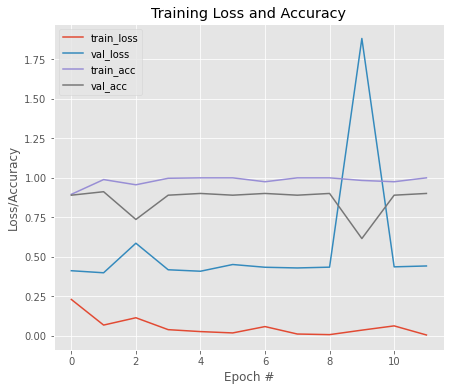


Model Performance Summary:

Best Validation accuracy:0.9120879173278809 at EPOCH:2
3/3 [==============================] - 2s 73ms/step
Accuracy: 0.9120879120879121
Sensitivity: 0.9024390243902439


Model  Accuracy  Precision    Recall        F1      AUC  \
0  InceptionV3_BL  0.912088   0.902439  0.902439  0.902439  0.91122   

   Sensitivity  Specificity     Kappa  
0     0.902439         0.92  0.822439

 Training:vgg19_BL,Aug:False

Epoch 1: val_loss improved from inf to 0.70957, saving model to vgg19_a.hdf5

Epoch 2: val_loss improved from 0.70957 to 0.69852, saving model to vgg19_a.hdf5

Epoch 3: val_loss improved from 0.69852 to 0.64050, saving model to vgg19_a.hdf5

Epoch 4: val_loss did not improve from 0.64050

Epoch 5: val_loss did not improve from 0.64050

Epoch 6: val_loss improved from 0.64050 to 0.60232, saving model to vgg19_a.hdf5

Epoch 7: val_loss improved from 0.60232 to 0.59028, saving model to vgg19_a.hdf5

Epoch 8: val_loss improved from 0.59028 to 0.58053, saving model to vgg19_a.hdf5

Epoch 9: val_loss improved from 0.58053 to 0.57886, saving model to vgg19_a.hdf5

Epoch 10: val_loss did not improve from 0.57886

Epoch 11: val_loss did not improve from 0.57886

Epoch 12: val_loss improved from 0.57886 to 0.56958, saving model to vgg19_a.hdf5

Epoch 13: val_loss improved from 0.56958 to 0.56898, saving model to vgg19_a.hdf5

Epoch 14: val_loss improved from 0.56898

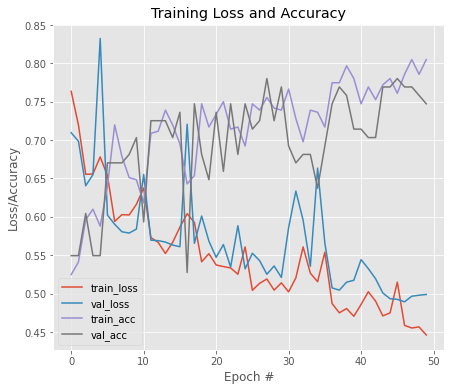


Model Performance Summary:

Best Validation accuracy:0.7802197933197021 at EPOCH:28
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.4676 - accuracy: 0.7802
Epoch 1: val_loss improved from inf to 0.48689, saving model to vgg19_wt.hdf5
12/12 [==============================] - 3s 180ms/step - loss: 0.4676 - accuracy: 0.7802 - val_loss: 0.4869 - val_accuracy: 0.7692
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.4381 - accuracy: 0.7995
Epoch 2: val_loss improved from 0.48689 to 0.48594, saving model to vgg19_wt.hdf5
12/12 [==============================] - 2s 153ms/step - loss: 0.4381 - accuracy: 0.7995 - val_loss: 0.4859 - val_accuracy: 0.7582
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.4265 - accuracy: 0.8187
Epoch 3: val_loss did not improve from 0.48594
12/12 [==============================] - 2s 127ms/step - loss: 0.4265 - accuracy: 0.8187 - val_loss: 0.5124 - val_accuracy: 0.7582
Epoch 4/30
12/12 [===============

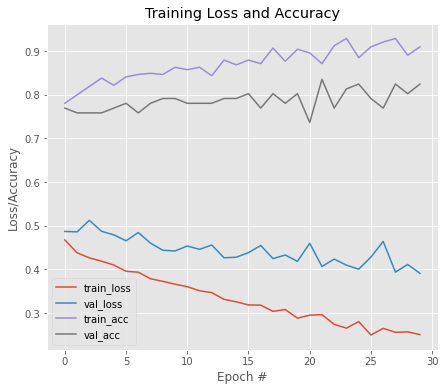


Model Performance Summary:

Best Validation accuracy:0.8351648449897766 at EPOCH:22
3/3 [==============================] - 0s 92ms/step
Accuracy: 0.8241758241758241
Sensitivity: 0.7804878048780488


Model  Accuracy  Precision    Recall   F1       AUC  Sensitivity  \
0  vgg19_BL  0.824176   0.820513  0.780488  0.8  0.820244     0.780488   

   Specificity     Kappa  
0         0.86  0.643312

Model  Accuracy  Precision    Recall        F1       AUC  \
0           MV  0.890110   0.918919  0.829268  0.871795  0.884634   
1           AV  0.901099   0.921053  0.853659  0.886076  0.896829   
2          WAV  0.901099   0.921053  0.853659  0.886076  0.896829   
3  DenseNet121  0.857143   0.833333  0.853659  0.843373  0.856829   
4  InceptionV3  0.912088   0.902439  0.902439  0.902439  0.911220   
5        vgg19  0.824176   0.820513  0.780488  0.800000  0.820244   

   Sensitivity  Specificity     Kappa  
0     0.829268         0.94  0.776083  
1     0.853659         0.94  0.798920  
2     0.853659         0.94  0.798920  
3     0.853659         0.86  0.712095  
4     0.902439         0.92  0.822439  
5     0.780488         0.86  0.643312

In [ ]:
en_obj = ENSEMBLE(['DenseNet121','InceptionV3','vgg19'])
en_obj.train_baselearner(data_aug=False)
en_obj.get_ensemble_acc()
en_obj.print_ensemble_performance()

Height:299 Width:299
 Training:vgg16_BL,Aug:False

Epoch 1: val_loss improved from inf to 0.70528, saving model to vgg16_a.hdf5

Epoch 2: val_loss improved from 0.70528 to 0.66279, saving model to vgg16_a.hdf5

Epoch 3: val_loss improved from 0.66279 to 0.63692, saving model to vgg16_a.hdf5

Epoch 4: val_loss improved from 0.63692 to 0.62623, saving model to vgg16_a.hdf5

Epoch 5: val_loss improved from 0.62623 to 0.61626, saving model to vgg16_a.hdf5

Epoch 6: val_loss improved from 0.61626 to 0.59517, saving model to vgg16_a.hdf5

Epoch 7: val_loss did not improve from 0.59517

Epoch 8: val_loss improved from 0.59517 to 0.57640, saving model to vgg16_a.hdf5

Epoch 9: val_loss improved from 0.57640 to 0.57546, saving model to vgg16_a.hdf5

Epoch 10: val_loss improved from 0.57546 to 0.56304, saving model to vgg16_a.hdf5

Epoch 11: val_loss did not improve from 0.56304

Epoch 12: val_loss improved from 0.56304 to 0.55538, saving model to vgg16_a.hdf5

Epoch 13: val_loss improved from 0

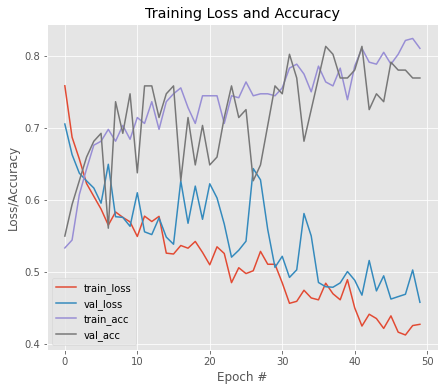


Model Performance Summary:

Best Validation accuracy:0.8131868243217468 at EPOCH:37
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.4144 - accuracy: 0.8104
Epoch 1: val_loss improved from inf to 0.47067, saving model to vgg16_wt.hdf5
12/12 [==============================] - 3s 160ms/step - loss: 0.4144 - accuracy: 0.8104 - val_loss: 0.4707 - val_accuracy: 0.7363
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.3885 - accuracy: 0.8352
Epoch 2: val_loss improved from 0.47067 to 0.43535, saving model to vgg16_wt.hdf5
12/12 [==============================] - 2s 144ms/step - loss: 0.3885 - accuracy: 0.8352 - val_loss: 0.4354 - val_accuracy: 0.8242
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.3905 - accuracy: 0.8269
Epoch 3: val_loss improved from 0.43535 to 0.43448, saving model to vgg16_wt.hdf5
12/12 [==============================] - 2s 132ms/step - loss: 0.3905 - accuracy: 0.8269 - val_loss: 0.4345 - val_accuracy: 0.802

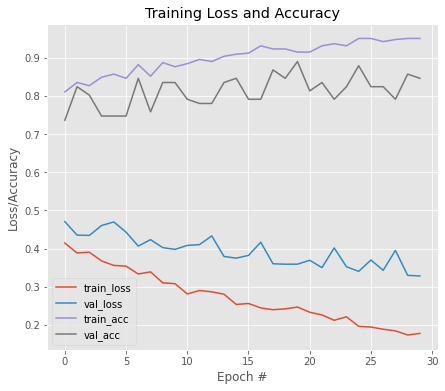


Model Performance Summary:

Best Validation accuracy:0.8901098966598511 at EPOCH:20
3/3 [==============================] - 0s 79ms/step
Accuracy: 0.8461538461538461
Sensitivity: 0.8048780487804879


Model  Accuracy  Precision    Recall     F1       AUC  Sensitivity  \
0  vgg16_BL  0.846154   0.846154  0.804878  0.825  0.842439     0.804878   

   Specificity     Kappa  
0         0.88  0.687898

 Training:DenseNet121_BL,Aug:False

Epoch 1: val_loss improved from inf to 0.58687, saving model to DenseNet121_a.hdf5

Epoch 2: val_loss improved from 0.58687 to 0.55618, saving model to DenseNet121_a.hdf5

Epoch 3: val_loss improved from 0.55618 to 0.46579, saving model to DenseNet121_a.hdf5

Epoch 4: val_loss improved from 0.46579 to 0.42761, saving model to DenseNet121_a.hdf5

Epoch 5: val_loss improved from 0.42761 to 0.40807, saving model to DenseNet121_a.hdf5

Epoch 6: val_loss improved from 0.40807 to 0.37710, saving model to DenseNet121_a.hdf5

Epoch 7: val_loss did not improve from 0.37710

Epoch 8: val_loss did not improve from 0.37710

Epoch 9: val_loss improved from 0.37710 to 0.36561, saving model to DenseNet121_a.hdf5

Epoch 10: val_loss improved from 0.36561 to 0.36106, saving model to DenseNet121_a.hdf5

Epoch 11: val_loss did not improve from 0.36106

Epoch 12: val_loss improved from 0.36106 to 0.35613, saving model to DenseNet121_a.hdf5

Epoch 13: val_loss improved f

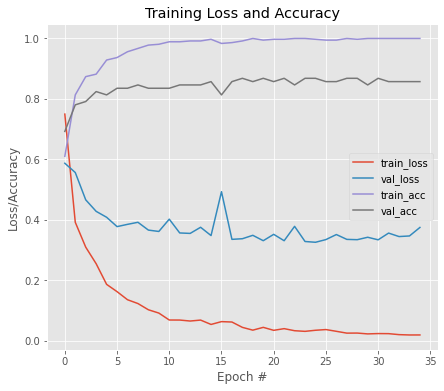


Model Performance Summary:

Best Validation accuracy:0.8681318759918213 at EPOCH:18
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.1142 - accuracy: 0.9505
Epoch 1: val_loss improved from inf to 0.53833, saving model to DenseNet121_wt.hdf5
12/12 [==============================] - 11s 393ms/step - loss: 0.1142 - accuracy: 0.9505 - val_loss: 0.5383 - val_accuracy: 0.8132
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.0271 - accuracy: 0.9973
Epoch 2: val_loss improved from 0.53833 to 0.45581, saving model to DenseNet121_wt.hdf5
12/12 [==============================] - 2s 167ms/step - loss: 0.0271 - accuracy: 0.9973 - val_loss: 0.4558 - val_accuracy: 0.8352
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.0273 - accuracy: 0.9918
Epoch 3: val_loss did not improve from 0.45581
12/12 [==============================] - 1s 92ms/step - loss: 0.0273 - accuracy: 0.9918 - val_loss: 0.6639 - val_accuracy: 0.7802
Epoch 4/30
12/12 [===

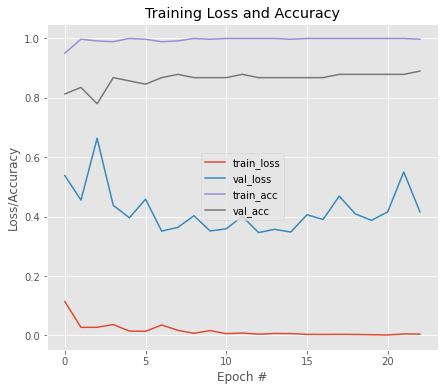


Model Performance Summary:

Best Validation accuracy:0.8901098966598511 at EPOCH:23
3/3 [==============================] - 2s 59ms/step
Accuracy: 0.8681318681318682
Sensitivity: 0.8536585365853658


Model  Accuracy  Precision    Recall        F1       AUC  \
0  DenseNet121_BL  0.868132   0.853659  0.853659  0.853659  0.866829   

   Sensitivity  Specificity     Kappa  
0     0.853659         0.88  0.733659

 Training:vgg19_BL,Aug:False

Epoch 1: val_loss improved from inf to 0.68625, saving model to vgg19_a.hdf5

Epoch 2: val_loss improved from 0.68625 to 0.64618, saving model to vgg19_a.hdf5

Epoch 3: val_loss improved from 0.64618 to 0.63812, saving model to vgg19_a.hdf5

Epoch 4: val_loss did not improve from 0.63812

Epoch 5: val_loss improved from 0.63812 to 0.63435, saving model to vgg19_a.hdf5

Epoch 6: val_loss improved from 0.63435 to 0.60456, saving model to vgg19_a.hdf5

Epoch 7: val_loss did not improve from 0.60456

Epoch 8: val_loss improved from 0.60456 to 0.59350, saving model to vgg19_a.hdf5

Epoch 9: val_loss improved from 0.59350 to 0.58724, saving model to vgg19_a.hdf5

Epoch 10: val_loss did not improve from 0.58724

Epoch 11: val_loss improved from 0.58724 to 0.57892, saving model to vgg19_a.hdf5

Epoch 12: val_loss improved from 0.57892 to 0.57767, saving model to vgg19_a.hdf5

Epoch 13: val_loss improved from 0.57767 to 0.57295, saving model to vgg19_a.hdf5

Epoch 

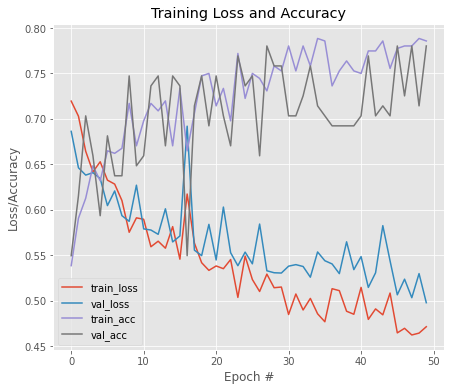


Model Performance Summary:

Best Validation accuracy:0.7802197933197021 at EPOCH:28
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.4521 - accuracy: 0.7857
Epoch 1: val_loss improved from inf to 0.49332, saving model to vgg19_wt.hdf5
12/12 [==============================] - 3s 183ms/step - loss: 0.4521 - accuracy: 0.7857 - val_loss: 0.4933 - val_accuracy: 0.7802
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.4396 - accuracy: 0.7940
Epoch 2: val_loss improved from 0.49332 to 0.48558, saving model to vgg19_wt.hdf5
12/12 [==============================] - 2s 163ms/step - loss: 0.4396 - accuracy: 0.7940 - val_loss: 0.4856 - val_accuracy: 0.7692
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.4326 - accuracy: 0.7912
Epoch 3: val_loss improved from 0.48558 to 0.48025, saving model to vgg19_wt.hdf5
12/12 [==============================] - 2s 154ms/step - loss: 0.4326 - accuracy: 0.7912 - val_loss: 0.4803 - val_accuracy: 0.758

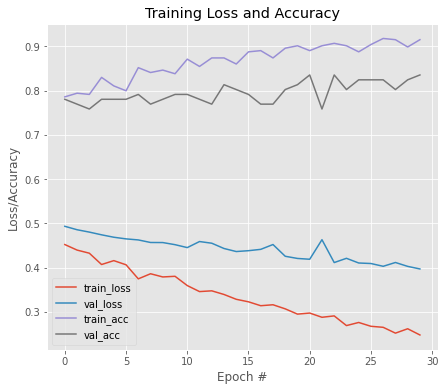


Model Performance Summary:

Best Validation accuracy:0.8351648449897766 at EPOCH:21
3/3 [==============================] - 0s 91ms/step
Accuracy: 0.8351648351648352
Sensitivity: 0.8048780487804879


Model  Accuracy  Precision    Recall        F1       AUC  Sensitivity  \
0  vgg19_BL  0.835165      0.825  0.804878  0.814815  0.832439     0.804878   

   Specificity     Kappa  
0         0.86  0.666341

Model  Accuracy  Precision    Recall        F1       AUC  \
0           MV  0.879121   0.857143  0.878049  0.867470  0.879024   
1           AV  0.912088   0.902439  0.902439  0.902439  0.911220   
2          WAV  0.890110   0.878049  0.878049  0.878049  0.889024   
3        vgg16  0.846154   0.846154  0.804878  0.825000  0.842439   
4  DenseNet121  0.868132   0.853659  0.853659  0.853659  0.866829   
5        vgg19  0.835165   0.825000  0.804878  0.814815  0.832439   

   Sensitivity  Specificity     Kappa  
0     0.878049         0.88  0.756388  
1     0.902439         0.92  0.822439  
2     0.878049         0.90  0.778049  
3     0.804878         0.88  0.687898  
4     0.853659         0.88  0.733659  
5     0.804878         0.86  0.666341

In [ ]:
en_obj = ENSEMBLE(['vgg16','DenseNet121','vgg19'])
en_obj.train_baselearner(data_aug=False)
en_obj.get_ensemble_acc()
en_obj.print_ensemble_performance()

Height:299 Width:299
 Training:DenseNet121_BL,Aug:False

Epoch 1: val_loss improved from inf to 0.54686, saving model to DenseNet121_a.hdf5

Epoch 2: val_loss improved from 0.54686 to 0.45095, saving model to DenseNet121_a.hdf5

Epoch 3: val_loss did not improve from 0.45095

Epoch 4: val_loss did not improve from 0.45095

Epoch 5: val_loss improved from 0.45095 to 0.37325, saving model to DenseNet121_a.hdf5

Epoch 6: val_loss improved from 0.37325 to 0.34685, saving model to DenseNet121_a.hdf5

Epoch 7: val_loss improved from 0.34685 to 0.33941, saving model to DenseNet121_a.hdf5

Epoch 8: val_loss improved from 0.33941 to 0.33654, saving model to DenseNet121_a.hdf5

Epoch 9: val_loss did not improve from 0.33654

Epoch 10: val_loss did not improve from 0.33654

Epoch 11: val_loss did not improve from 0.33654

Epoch 12: val_loss improved from 0.33654 to 0.31819, saving model to DenseNet121_a.hdf5

Epoch 13: val_loss improved from 0.31819 to 0.30415, saving model to DenseNet121_a.hdf5


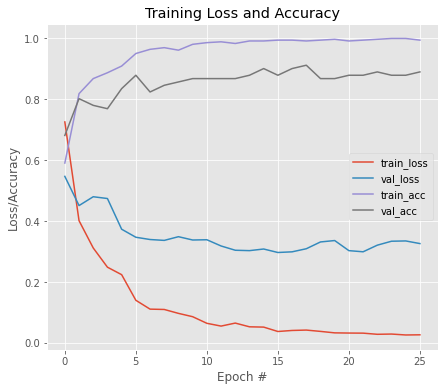


Model Performance Summary:

Best Validation accuracy:0.9120879173278809 at EPOCH:18
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.1635 - accuracy: 0.9286
Epoch 1: val_loss improved from inf to 0.42049, saving model to DenseNet121_wt.hdf5
12/12 [==============================] - 11s 363ms/step - loss: 0.1635 - accuracy: 0.9286 - val_loss: 0.4205 - val_accuracy: 0.8681
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.0296 - accuracy: 0.9918
Epoch 2: val_loss improved from 0.42049 to 0.34377, saving model to DenseNet121_wt.hdf5
12/12 [==============================] - 2s 201ms/step - loss: 0.0296 - accuracy: 0.9918 - val_loss: 0.3438 - val_accuracy: 0.8901
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.0488 - accuracy: 0.9890
Epoch 3: val_loss did not improve from 0.34377
12/12 [==============================] - 1s 91ms/step - loss: 0.0488 - accuracy: 0.9890 - val_loss: 0.3687 - val_accuracy: 0.8571
Epoch 4/30
12/12 [===

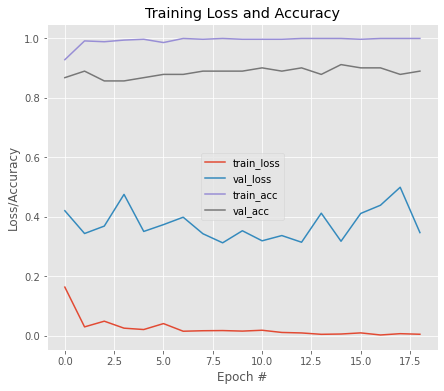


Model Performance Summary:

Best Validation accuracy:0.9120879173278809 at EPOCH:15
3/3 [==============================] - 2s 59ms/step
Accuracy: 0.8901098901098901
Sensitivity: 0.8780487804878049


Model  Accuracy  Precision    Recall        F1       AUC  \
0  DenseNet121_BL   0.89011   0.878049  0.878049  0.878049  0.889024   

   Sensitivity  Specificity     Kappa  
0     0.878049          0.9  0.778049

 Training:InceptionV3_BL,Aug:False

Epoch 1: val_loss improved from inf to 0.58301, saving model to InceptionV3_a.hdf5

Epoch 2: val_loss did not improve from 0.58301

Epoch 3: val_loss improved from 0.58301 to 0.45431, saving model to InceptionV3_a.hdf5

Epoch 4: val_loss improved from 0.45431 to 0.43950, saving model to InceptionV3_a.hdf5

Epoch 5: val_loss improved from 0.43950 to 0.40569, saving model to InceptionV3_a.hdf5

Epoch 6: val_loss did not improve from 0.40569

Epoch 7: val_loss did not improve from 0.40569

Epoch 8: val_loss improved from 0.40569 to 0.39004, saving model to InceptionV3_a.hdf5

Epoch 9: val_loss improved from 0.39004 to 0.38858, saving model to InceptionV3_a.hdf5

Epoch 10: val_loss did not improve from 0.38858

Epoch 11: val_loss did not improve from 0.38858

Epoch 12: val_loss did not improve from 0.38858

Epoch 13: val_loss did not improve from 0.38858

Epoch 14: val_loss did not improve from 0.38858

Epoch 15: val_loss did not improve from 0.38858

Ep

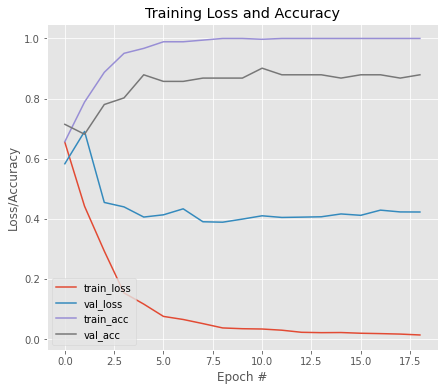


Model Performance Summary:

Best Validation accuracy:0.901098906993866 at EPOCH:11
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.2646 - accuracy: 0.9093
Epoch 1: val_loss improved from inf to 0.40599, saving model to InceptionV3_wt.hdf5
12/12 [==============================] - 9s 330ms/step - loss: 0.2646 - accuracy: 0.9093 - val_loss: 0.4060 - val_accuracy: 0.8901
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 0.9918
Epoch 2: val_loss did not improve from 0.40599
12/12 [==============================] - 1s 103ms/step - loss: 0.0388 - accuracy: 0.9918 - val_loss: 0.4090 - val_accuracy: 0.9121
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 0.40599
12/12 [==============================] - 1s 104ms/step - loss: 0.0198 - accuracy: 1.0000 - val_loss: 0.4393 - val_accuracy: 0.8681
Epoch 4/30
12/12 [==============================] - ETA: 0s - l

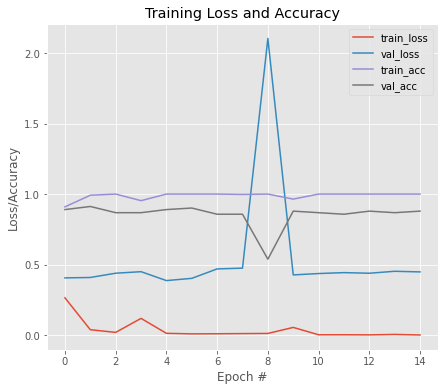


Model Performance Summary:

Best Validation accuracy:0.9120879173278809 at EPOCH:2
3/3 [==============================] - 2s 72ms/step
Accuracy: 0.8901098901098901
Sensitivity: 0.8780487804878049


Model  Accuracy  Precision    Recall        F1       AUC  \
0  InceptionV3_BL   0.89011   0.878049  0.878049  0.878049  0.889024   

   Sensitivity  Specificity     Kappa  
0     0.878049          0.9  0.778049

 Training:xception_BL,Aug:False

Epoch 1: val_loss improved from inf to 0.53210, saving model to xception_a.hdf5

Epoch 2: val_loss improved from 0.53210 to 0.50769, saving model to xception_a.hdf5

Epoch 3: val_loss improved from 0.50769 to 0.46975, saving model to xception_a.hdf5

Epoch 4: val_loss improved from 0.46975 to 0.42101, saving model to xception_a.hdf5

Epoch 5: val_loss improved from 0.42101 to 0.40596, saving model to xception_a.hdf5

Epoch 6: val_loss improved from 0.40596 to 0.40480, saving model to xception_a.hdf5

Epoch 7: val_loss did not improve from 0.40480

Epoch 8: val_loss did not improve from 0.40480

Epoch 9: val_loss improved from 0.40480 to 0.40189, saving model to xception_a.hdf5

Epoch 10: val_loss improved from 0.40189 to 0.39814, saving model to xception_a.hdf5

Epoch 11: val_loss did not improve from 0.39814

Epoch 12: val_loss improved from 0.39814 to 0.39582, saving model to xception_a.hdf5

Epoch 13: val_loss did not improve from 0.39582

Epoch 14: 

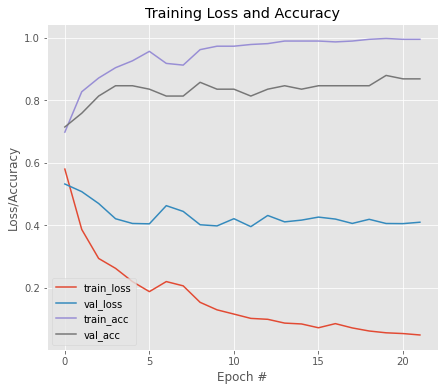


Model Performance Summary:

Best Validation accuracy:0.8791208863258362 at EPOCH:20
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.3156 - accuracy: 0.9148
Epoch 1: val_loss improved from inf to 0.61946, saving model to xception_wt.hdf5
12/12 [==============================] - 7s 339ms/step - loss: 0.3156 - accuracy: 0.9148 - val_loss: 0.6195 - val_accuracy: 0.7473
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.0659 - accuracy: 0.9973
Epoch 2: val_loss did not improve from 0.61946
12/12 [==============================] - 2s 178ms/step - loss: 0.0659 - accuracy: 0.9973 - val_loss: 0.7306 - val_accuracy: 0.7033
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.0541 - accuracy: 0.9890
Epoch 3: val_loss did not improve from 0.61946
12/12 [==============================] - 2s 179ms/step - loss: 0.0541 - accuracy: 0.9890 - val_loss: 0.6618 - val_accuracy: 0.7473
Epoch 4/30
12/12 [==============================] - ETA: 0s - los

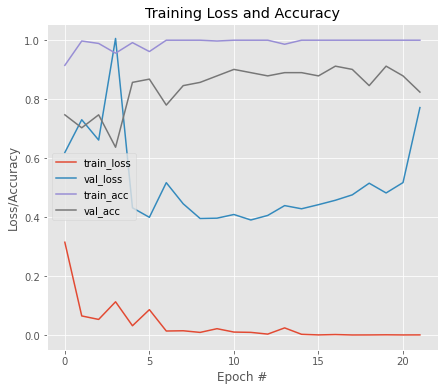


Model Performance Summary:

Best Validation accuracy:0.9120879173278809 at EPOCH:17
3/3 [==============================] - 1s 132ms/step
Accuracy: 0.8901098901098901
Sensitivity: 0.8536585365853658


Model  Accuracy  Precision    Recall     F1       AUC  Sensitivity  \
0  xception_BL   0.89011   0.897436  0.853659  0.875  0.886829     0.853659   

   Specificity    Kappa  
0         0.92  0.77707

Model  Accuracy  Precision    Recall        F1       AUC  \
0           MV  0.923077   0.925000  0.902439  0.913580  0.921220   
1           AV  0.923077   0.925000  0.902439  0.913580  0.921220   
2          WAV  0.945055   0.950000  0.926829  0.938272  0.943415   
3  DenseNet121  0.890110   0.878049  0.878049  0.878049  0.889024   
4  InceptionV3  0.890110   0.878049  0.878049  0.878049  0.889024   
5     xception  0.890110   0.897436  0.853659  0.875000  0.886829   

   Sensitivity  Specificity     Kappa  
0     0.902439         0.94  0.844292  
1     0.902439         0.94  0.844292  
2     0.926829         0.96  0.888780  
3     0.878049         0.90  0.778049  
4     0.878049         0.90  0.778049  
5     0.853659         0.92  0.777070

In [ ]:
en_obj = ENSEMBLE(['DenseNet121','InceptionV3','xception'])
en_obj.train_baselearner(data_aug=False)
en_obj.get_ensemble_acc()
en_obj.print_ensemble_performance()

In [ ]:
en_obj.base_learners_acc

In [ ]:
en_obj.ensemble_acc


In [ ]:
en_obj.print_ensemble_performance()

Model  Accuracy  Precision    Recall        F1       AUC  \
0           MV  0.934066   0.926829  0.926829  0.926829  0.933415   
1           AV  0.934066   0.926829  0.926829  0.926829  0.933415   
2          WAV  0.934066   0.948718  0.902439  0.925000  0.931220   
3        vgg16  0.868132   0.853659  0.853659  0.853659  0.866829   
4  DenseNet121  0.912088   0.902439  0.902439  0.902439  0.911220   
5  InceptionV3  0.879121   0.857143  0.878049  0.867470  0.879024   
6     xception  0.901099   0.880952  0.902439  0.891566  0.901220   
7    MobileNet  0.934066   0.972973  0.878049  0.923077  0.929024   

   Sensitivity  Specificity     Kappa  
0     0.926829         0.94  0.866829  
1     0.926829         0.94  0.866829  
2     0.902439         0.96  0.866242  
3     0.853659         0.88  0.733659  
4     0.902439         0.92  0.822439  
5     0.878049         0.88  0.756388  
6     0.902439         0.90  0.800681  
7     0.878049         0.98  0.865650

In [ ]:
en_obj.print_ensemble_performance()

Model  Accuracy  Precision    Recall        F1       AUC  \
0                 MV  0.934066   0.926829  0.926829  0.926829  0.933415   
1                 AV  0.934066   0.926829  0.926829  0.926829  0.933415   
2                WAV  0.912088   0.923077  0.878049  0.900000  0.909024   
3              vgg16  0.868132   0.853659  0.853659  0.853659  0.866829   
4        DenseNet121  0.912088   0.902439  0.902439  0.902439  0.911220   
5        InceptionV3  0.879121   0.857143  0.878049  0.867470  0.879024   
6  InceptionResNetV2  0.780220   0.756098  0.756098  0.756098  0.778049   
7          MobileNet  0.923077   0.972222  0.853659  0.909091  0.916829   

   Sensitivity  Specificity     Kappa  
0     0.926829         0.94  0.866829  
1     0.926829         0.94  0.866829  
2     0.878049         0.94  0.821656  
3     0.853659         0.88  0.733659  
4     0.902439         0.92  0.822439  
5     0.878049         0.88  0.756388  
6     0.756098         0.80  0.556098  
7     0.853659         0.98  0.842910

In [ ]:
en_obj.print_ensemble_performance()

Model  Accuracy  Precision    Recall        F1       AUC  \
0           MV  0.901099   0.900000  0.878049  0.888889  0.899024   
1           AV  0.901099   0.900000  0.878049  0.888889  0.899024   
2          WAV  0.901099   0.900000  0.878049  0.888889  0.899024   
3        vgg16  0.824176   0.820513  0.780488  0.800000  0.820244   
4  DenseNet121  0.879121   0.916667  0.804878  0.857143  0.872439   
5  InceptionV3  0.890110   0.860465  0.902439  0.880952  0.891220   
6     xception  0.835165   0.809524  0.829268  0.819277  0.834634   
7    MobileNet  0.890110   0.897436  0.853659  0.875000  0.886829   

   Sensitivity  Specificity     Kappa  
0     0.878049         0.92  0.799804  
1     0.878049         0.92  0.799804  
2     0.878049         0.92  0.799804  
3     0.780488         0.86  0.643312  
4     0.804878         0.94  0.753144  
5     0.902439         0.88  0.779019  
6     0.829268         0.84  0.667802  
7     0.853659         0.92  0.777070

In [ ]:
en_obj.print_ensemble_performance()

Model  Accuracy  Precision    Recall        F1       AUC  \
0           MV  0.835165   0.882353  0.731707  0.800000  0.825854   
1           AV  0.912088   0.902439  0.902439  0.902439  0.911220   
2          WAV  0.901099   0.880952  0.902439  0.891566  0.901220   
3        vgg16  0.813187   0.815789  0.756098  0.784810  0.808049   
4        vgg19  0.769231   0.794118  0.658537  0.720000  0.759268   
5  DenseNet121  0.890110   0.918919  0.829268  0.871795  0.884634   
6  InceptionV3  0.890110   0.878049  0.878049  0.878049  0.889024   

   Sensitivity  Specificity     Kappa  
0     0.731707         0.92  0.661878  
1     0.902439         0.92  0.822439  
2     0.902439         0.90  0.800681  
3     0.756098         0.86  0.620182  
4     0.658537         0.86  0.526629  
5     0.829268         0.94  0.776083  
6     0.878049         0.90  0.778049